In [ ]:
#!pip install shap

In [ ]:
#IMPORTING THE LIBRARIES
import numpy as np
import shap
import pandas as pd
from pandas import read_excel
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
import seaborn as sns
import os
import scipy as sp
import warnings
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
warnings.filterwarnings("ignore")
%matplotlib inline
ax = plt.gca()

########## Img dpi ############
plt.rcParams['figure.dpi'] = 200

C:\Users\Roberto\anaconda3\envs\Ciencia-de-datos\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def plot_roc_multiclass(y_train, y_test, y_proba, target_names, tittle):
  from sklearn.preprocessing import LabelBinarizer
  label_binarizer = LabelBinarizer().fit(y_train)
  y_onehot_test = label_binarizer.transform(y_test)
  y_onehot_test.shape  # (n_samples, n_classes)

  ##clases:
  n_classes = len(np.unique(y_test))
  #names
  target_names = target_names

  from sklearn.metrics import roc_curve, auc

  # store the fpr, tpr, and roc_auc for all averaging strategies
  fpr, tpr, roc_auc = dict(), dict(), dict()
  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_proba.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  #print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  fpr_grid = np.linspace(0.0, 1.0, 1000)

  # Interpolate all ROC curves at these points
  mean_tpr = np.zeros_like(fpr_grid)

  for i in range(n_classes):
      mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

  # Average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = fpr_grid
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  #print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

  from itertools import cycle

  fig, ax = plt.subplots(figsize=(6, 6))

#  plt.plot(
#      fpr["micro"],
#      tpr["micro"],
#      label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
#      color="deeppink",
#      linestyle=":",
#      linewidth=4,
#  )#

#  plt.plot(
#      fpr["macro"],
#      tpr["macro"],
#      label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
#      color="navy",
#      linestyle=":",
#      linewidth=4,
#  )

  colors = cycle(["aqua", "darkorange", "cornflowerblue"])
  for class_id, color in zip(range(n_classes), colors):
      RocCurveDisplay.from_predictions(
          y_onehot_test[:, class_id],
          y_proba[:, class_id],
          name=f"ROC curve for {target_names[class_id]}",
          color=color,
          ax=ax,
      )

  plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
  plt.axis("square")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title(tittle)
  plt.legend()
  plt.show()


# Data

## LOADING THE DATASET

In [ ]:
my_sheet = 'S1-CD' # change it to your sheet name, you can find your sheet name at the bottom left of your excel file
file_name = 'FRX-sondeo-lagunaCopia de 53572_results-MJ.xlsx' # change it to the name of your excel file
df = read_excel(file_name, sheet_name = my_sheet)

In [ ]:
df

Unnamed: 0  cm muestreo-marga  cluster      Na      Mg      Al  \
0     TEN20-S1-CD-30                 30        1  0.0004  0.0128  0.1695   
1     TEN20-S1-CD-60                 60        1  0.0000  0.0125  0.1859   
2    TEN20-S1-CD-100                100        1  0.0017  0.0116  0.1687   
3    TEN20-S1-CD-150                150        2  0.0009  0.0121  0.1953   
4    TEN20-S1-CD-205                205        1  0.0008  0.0107  0.1889   
5    TEN20-S1-CD-250                250        2  0.0000  0.0120  0.1907   
6    TEN20-S1-CD-265                265        3  0.0010  0.0127  0.2100   
7    TEN20-S1-CD-340                340        1  0.0002  0.0124  0.1814   
8    TEN20-S1-CD-380                380        1  0.0009  0.0118  0.1760   
9    TEN20-S1-CD-410                410        1  0.0004  0.0118  0.1812   
10   TEN20-S1-CD-470                470        1  0.0008  0.0113  0.1857   
11   TEN20-S1-CD-520                520        2  0.0000  0.0105  0.1965   
12   TEN20-S1-CD-550                550        2  0.0004  0.0118  0.1922   
13   TEN20-S1-CD-650                650        2  0.0007  0.0119  0.1859   
14   TEN20-S1-CD-740                740        2  0.0035  0.0116  0.1982   
15   TEN20-S1-CD-790                790        2  0.0017  0.0119  0.2019   
16   TEN20-S1-CD-820                820        2  0.0031  0.0119  0.1906   
17   TEN20-S1-CD-860                860        2  0.0030  0.0118  0.2050   
18   TEN20-S1-CD-890                890        2  0.0013  0.0118  0.1958   
19   TEN20-S1-CD-940                940        3  0.0021  0.0112  0.2170   
20  TEN20-S1-CD-1010               1010        3  0.0021  0.0101  0.2182   
21  TEN20-S1-CD-1055               1055        3  0.0018  0.0106  0.2051   
22  TEN20-S1-CD-1120               1120        3  0.0011  0.0103  0.2345   
23  TEN20-S1-CD-1180               1180        3  0.0019  0.0101  0.2173   
24  TEN20-S1-CD-1280               1280        2  0.0023  0.0112  0.1905   
25  TEN20-S1-CD-1325               1325        3  0.0026  0.0108  0.2086   
26  TEN20-S1-CD-1395               1395        2  0.0023  0.0107  0.2074   
27  TEN20-S1-CD-1425               1425        3  0.0028  0.0114  0.2052   
28  TEN20-S1-CD-1480               1480        2  0.0004  0.0123  0.2002   
29  TEN20-S1-CD-1540               1540        2  0.0003  0.0094  0.2151   
30  TEN20-S1-CD-1590               1590        2  0.0008  0.0118  0.1946   
31  TEN20-S1-CD-1660               1660        2  0.0000  0.0123  0.1898   
32  TEN20-S1-CD-1710               1710        2  0.0004  0.0124  0.1992   
33  TEN20-S1-CD-1730               1730        3  0.0004  0.0125  0.2070   
34  TEN20-S1-CD-1800               1800        2  0.0004  0.0138  0.1847   
35  TEN20-S1-CD-1840               1840        2  0.0019  0.0160  0.1903   
36  TEN20-S1-CD-1880               1880        3  0.0007  0.0125  0.2112   
37  TEN20-S1-CD-1900               1900        2  0.0065  0.0098  0.1980   
38  TEN20-S1-CD-1975               1975        2  0.0029  0.0120  0.2019   
39  TEN20-S1-CD-2020               2020        3  0.0056  0.0238  0.2122   
40  TEN20-S1-CD-2060               2060        3  0.0054  0.0145  0.2222   
41  TEN20-S1-CD-2085               2085        3  0.0033  0.0136  0.2365   
42  TEN20-S1-CD-2110               2110        3  0.0029  0.0155  0.2226   

        Si       P       S      Cl  ...      Rb      Sr       Y      Zr  \
0   0.2714  0.0053  0.0008  0.0011  ...  0.0001  0.0007  0.0000  0.0018   
1   0.2528  0.0056  0.0007  0.0010  ...  0.0001  0.0006  0.0000  0.0020   
2   0.2625  0.0052  0.0007  0.0013  ...  0.0002  0.0007  0.0001  0.0021   
3   0.2658  0.0054  0.0009  0.0009  ...  0.0001  0.0008  0.0001  0.0022   
4   0.2604  0.0075  0.0005  0.0012  ...  0.0006  0.0001  0.0021  0.0004   
5   0.2829  0.0052  0.0006  0.0012  ...  0.0002  0.0006  0.0001  0.0023   
6   0.3164  0.0050  0.0007  0.0013  ...  0.0002  0.0007  0.0001  0.0026   
7   0.2669  0.0039  0.0006  0.0012  ...  0.0002  0.0007  0.0000  

In [ ]:
df.drop(['Unnamed: 0', 'cm muestreo-marga' ], axis = 'columns', inplace=True)
#drop the minor elementes
#df.drop(['Na', 'S','Cl', 'Sc','V','Cr', 'Ni','Cu', 'Zn','Ga', 'Rb',
#         'Sr', 'Y','Zr', 'Nb','Rh', 'Hf','Ta', 'Au','Bi'], axis = 'columns', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 30 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cluster  43 non-null     int64  
 1   Na       43 non-null     float64
 2   Mg       43 non-null     float64
 3   Al       43 non-null     float64
 4   Si       43 non-null     float64
 5   P        43 non-null     float64
 6   S        43 non-null     float64
 7   Cl       43 non-null     float64
 8   K        43 non-null     float64
 9   Ca       43 non-null     float64
 10  Sc       43 non-null     float64
 11  Ti       43 non-null     float64
 12  V        43 non-null     float64
 13  Cr       43 non-null     float64
 14  Mn       43 non-null     float64
 15  Fe       43 non-null     float64
 16  Ni       43 non-null     float64
 17  Cu       35 non-null     float64
 18  Zn       43 non-null     float64
 19  Ga       3 non-null      float64
 20  Rb       43 non-null     float64
 21  Sr       43 non-nu

## TRAINING AND TESTING DATA

In [ ]:
#filling the NaNs
df = df.fillna(df.mean())

#dataset
x = df.drop(columns='cluster')

# Getting Predicting Value
y = df['cluster']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
minmax=MinMaxScaler()
x=pd.DataFrame(minmax.fit_transform(x),columns=x.columns)
x.head()

Na        Mg        Al        Si         P         S   Cl        K  \
0  0.061538  0.236111  0.011799  0.186935  0.285714  0.857143  0.4  0.15625   
1  0.000000  0.215278  0.253687  0.000000  0.339286  0.714286  0.2  0.11875   
2  0.261538  0.152778  0.000000  0.097487  0.267857  0.714286  0.8  0.33125   
3  0.138462  0.187500  0.392330  0.130653  0.303571  1.000000  0.0  0.21250   
4  0.123077  0.090278  0.297935  0.076382  0.678571  0.428571  0.6  0.13750   

         Ca   Sc  ...        Rb        Sr         Y     Zr        Nb  \
0  0.170172  0.0  ...  0.166667  0.461538  0.000000  0.350  0.166667   
1  0.063098  0.0  ...  0.166667  0.384615  0.000000  0.400  0.166667   
2  0.045889  0.0  ...  0.333333  0.461538  0.047619  0.425  0.333333   
3  0.051625  0.0  ...  0.166667  0.538462  0.047619  0.450  0.166667   
4  0.072658  0.0  ...  1.000000  0.000000  1.000000  0.000  0.166667   

             Rh   Hf    Ta   Au   Bi  
0  1.355253e-20  0.0  0.75  0.0  0.0  
1  1.355253e-20  0.0  0.75  0.0  0.0  
2  1.355253e-20  0.0  0.75  0.0  0.0  
3  1.355253e-20  0.0  1.00  0.0  0.0  
4  1.355253e-20  0.0  0.00  0.0  0.0  

[5 rows x 29 columns]

## train_test_splitting of the dataset

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=0)

In [ ]:
x_test

Na        Mg        Al        Si         P         S   Cl        K  \
30  0.123077  0.166667  0.382006  0.098492  0.214286  0.571429  0.4  0.21250   
36  0.107692  0.215278  0.626844  0.594975  0.125000  0.428571  0.8  0.57500   
27  0.430769  0.138889  0.538348  0.603015  0.125000  0.428571  0.6  0.71250   
4   0.123077  0.090278  0.297935  0.076382  0.678571  0.428571  0.6  0.13750   
10  0.123077  0.131944  0.250737  0.082412  0.357143  0.571429  0.2  0.33125   
25  0.400000  0.097222  0.588496  1.000000  0.125000  0.571429  0.8  1.00000   
28  0.061538  0.201389  0.464602  0.231156  0.214286  0.571429  0.4  0.29375   
11  0.000000  0.076389  0.410029  0.402010  0.303571  0.428571  0.6  0.26875   
37  1.000000  0.027778  0.432153  0.113568  0.910714  0.000000  0.2  0.00000   
31  0.000000  0.201389  0.311209  0.187940  0.285714  0.428571  0.4  0.38750   
29  0.046154  0.000000  0.684366  0.324623  0.196429  0.428571  0.6  0.23750   

          Ca   Sc  ...        Rb        Sr         Y     Zr        Nb  \
30  0.003824  0.0  ...  0.166667  0.384615  0.047619  0.350  0.166667   
36  0.043977  0.0  ...  0.500000  0.538462  0.047619  0.575  0.500000   
27  0.032505  0.0  ...  0.500000  0.615385  0.047619  0.625  0.500000   
4   0.072658  0.0  ...  1.000000  0.000000  1.000000  0.000  0.166667   
10  0.001912  0.0  ...  0.333333  0.384615  0.047619  0.425  0.166667   
25  0.022945  0.0  ...  0.666667  0.461538  0.047619  0.700  0.500000   
28  0.043977  0.0  ...  0.333333  0.538462  0.047619  0.450  0.333333   
11  0.030593  0.0  ...  0.166667  0.384615  0.047619  0.450  0.333333   
37  0.405354  0.0  ...  0.000000  1.000000  0.047619  0.250  0.000000   
31  0.015296  0.0  ...  0.333333  0.384615  0.047619  0.400  0.166667   
29  0.015296  0.0  ...  0.166667  0.384615  0.000000  0.375  0.166667   

              Rh   Hf    Ta   Au   Bi  
30  1.355253e-20  0.0  0.75  0.0  0.0  
36  1.355253e-20  0.0  0.50  0.0  0.0  
27  1.355253e-20  0.0  0.75  0.0  0.0  
4   1.355253e-20  0.0  0.00  0.0  0.0  
10  1.355253e-20  0.0  0.75  0.0  0.0  
25  0.000000e+00  0.0  0.75  0.0  0.0  
28  1.355253e-20  0.0  0.75  0.0  0.0  
11  1.355253e-20  0.0  0.75  0.0  0.0  
37  1.355253e-20  0.0  1.00  0.0  0.0  
31  1.355253e-20  0.0  0.75  0.0  0.0  
29  0.000000e+00  0.0  0.75  0.0  0.0  

[11 rows x 29 columns]

In [ ]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

32
11
32
11


# MODELS

## 1. SVC

### Gridsearch SVC

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import numpy as np
from pprint import pprint

# Define hyperparameter grid for SVC
param_grid_svc = {
    'C': [0.1, 1, 5, 10],
    'gamma': [0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly']
}

# Print grid
pprint(param_grid_svc)

# Define model
svc = SVC(probability=True)  # probability=True if you want to use SHAP later

# Define GridSearchCV
grid_search_svc = GridSearchCV(estimator=svc, param_grid=param_grid_svc,
                               cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV (X_train and y_train assumed defined)
grid_search_svc.fit(x_train, y_train)

# Best parameters found
print("Best parameters found:", grid_search_svc.best_params_)

{'C': [0.1, 1, 5, 10],
 'gamma': [0.1, 0.01, 0.001],
 'kernel': ['linear', 'rbf', 'poly']}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found: {'C': 5, 'gamma': 0.1, 'kernel': 'linear'}


### SCV model train

In [ ]:
svc = SVC(probability=True, C=5, gamma=0.1, kernel='linear')
svc.fit(x_train, y_train)

SVC(C=5, gamma=0.1, kernel='linear', probability=True)

#### SVC Classification Report

In [ ]:
y_pred=svc.predict(x_test)
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print("Classification Report is:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
print("Training Score:\n",svc.score(x_train,y_train)*100)
print("Mean Squared Error:\n",mean_squared_error(y_test,y_pred))
print("R2 score is:\n",r2_score(y_test,y_pred))

Classification Report is:
               precision    recall  f1-score   support

           1       1.00      0.50      0.67         2
           2       0.83      0.83      0.83         6
           3       0.75      1.00      0.86         3

    accuracy                           0.82        11
   macro avg       0.86      0.78      0.79        11
weighted avg       0.84      0.82      0.81        11

Confusion Matrix:
 [[1 1 0]
 [0 5 1]
 [0 0 3]]
Training Score:
 100.0
Mean Squared Error:
 0.18181818181818182
R2 score is:
 0.5925925925925926


#### SVC Confusion matrix

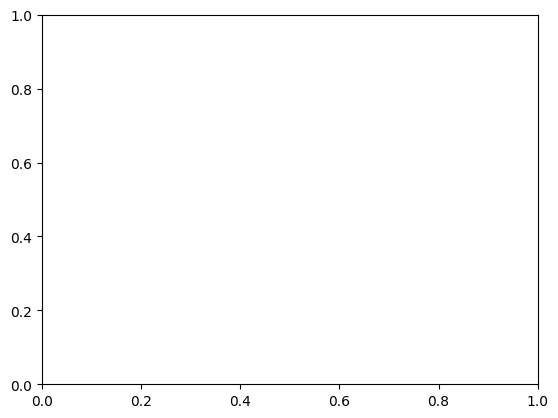

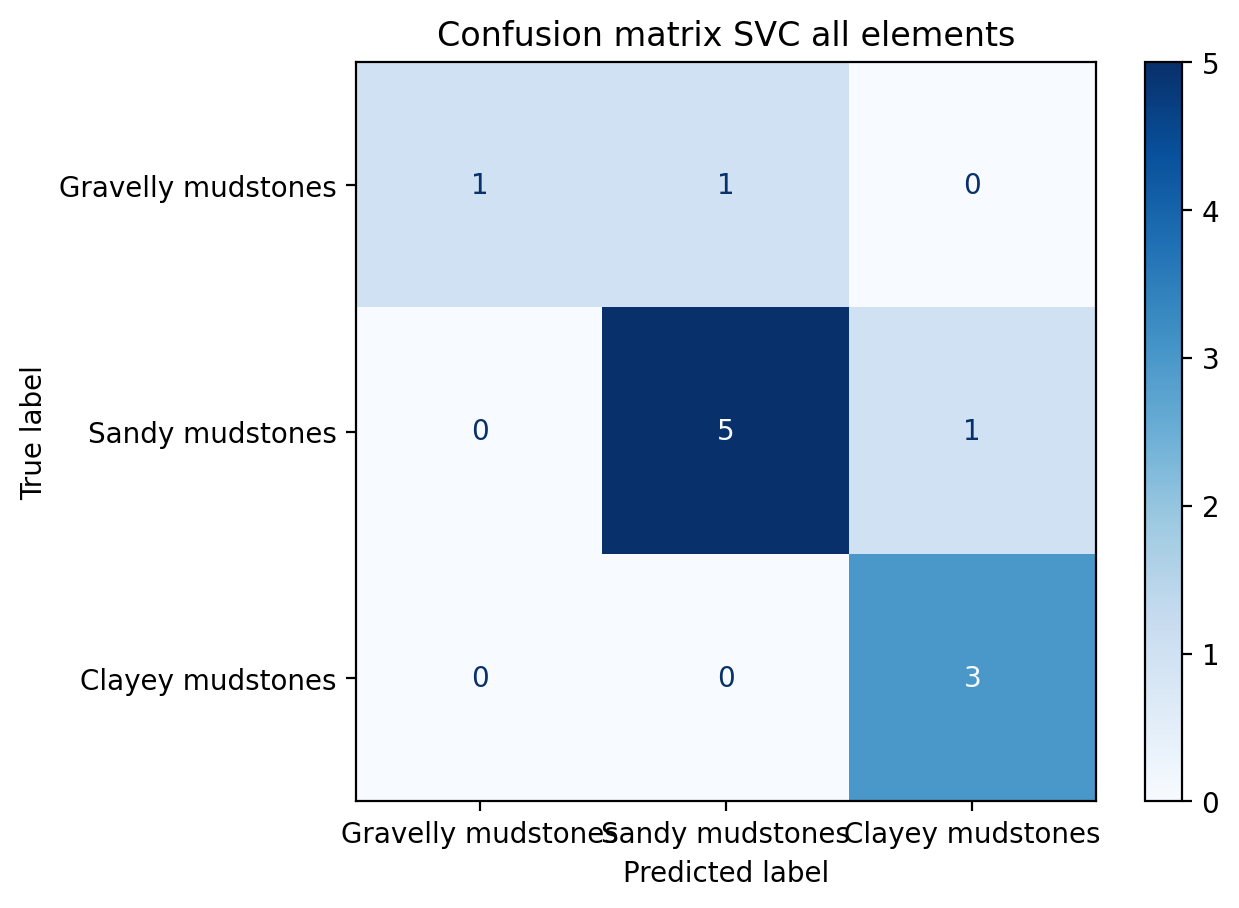

In [ ]:
title_options = [
    ("Confusion matrix SVC all elements", None)
]
for title, normalize in title_options:
    display = ConfusionMatrixDisplay.from_estimator(
        svc,
        x_test,
        y_test,
        display_labels=['Gravelly mudstones', 'Sandy mudstones', 'Clayey mudstones'] ,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    display.ax_.set_title(title)

plt.show()

#### SVC ROC

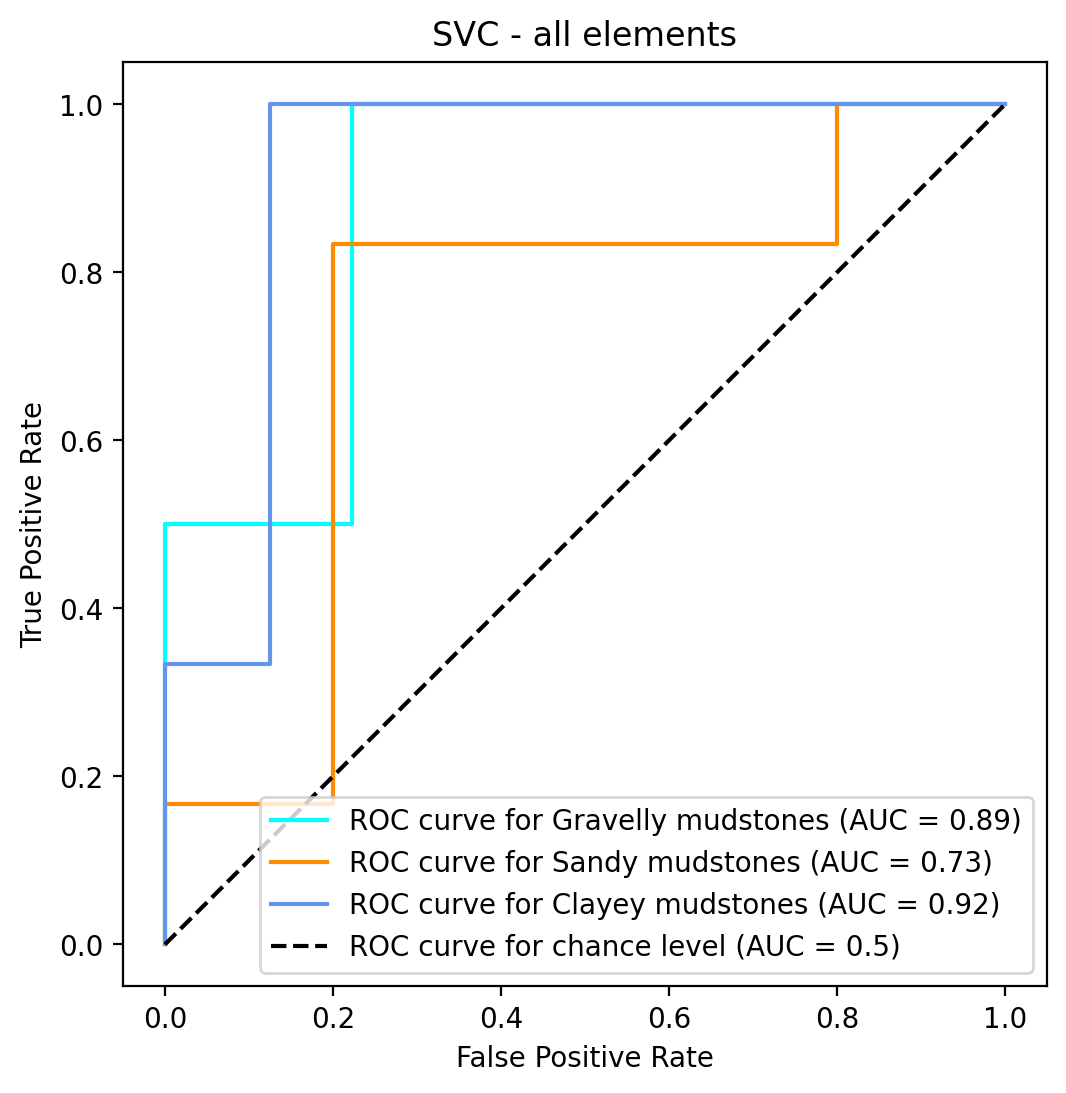

In [ ]:
svc_roc = plot_roc_multiclass(y_train, y_test, svc.predict_proba(x_test), ['Gravelly mudstones', 'Sandy mudstones', 'Clayey mudstones'], "SVC - all elements")
svc_roc

In [ ]:
print(accuracy_score(y_test,y_pred)*100)

81.81818181818183


## 2. Naive Bayes

### Gridsearch GNB

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
import numpy as np
from pprint import pprint

# Define hyperparameter grid for GaussianNB
param_grid_gnb = {
    'var_smoothing': np.logspace(0, -9, num=10)
}

# Print grid
pprint(param_grid_gnb)

# Define model
gnb = GaussianNB()

# Define GridSearchCV
grid_search_gnb = GridSearchCV(estimator=gnb, param_grid=param_grid_gnb,
                               cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV (X_train and y_train assumed defined)
grid_search_gnb.fit(x_train, y_train)

# Best parameters found
print("Best parameters found:", grid_search_gnb.best_params_)

{'var_smoothing': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07,
       1.e-08, 1.e-09])}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found: {'var_smoothing': np.float64(0.1)}


#### GNB model train

In [ ]:
gnb = GaussianNB(var_smoothing=0.1)
gnb.fit(x_train,y_train)

GaussianNB(var_smoothing=0.1)

#### GNB Classification Report

In [ ]:
y_pred=gnb.predict(x_test)
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print("Classification Report is:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
print("Training Score:\n",gnb.score(x_train,y_train)*100)
print("Mean Squared Error:\n",mean_squared_error(y_test,y_pred))
print("R2 score is:\n",r2_score(y_test,y_pred))

Classification Report is:
               precision    recall  f1-score   support

           1       0.33      0.50      0.40         2
           2       0.67      0.67      0.67         6
           3       1.00      0.67      0.80         3

    accuracy                           0.64        11
   macro avg       0.67      0.61      0.62        11
weighted avg       0.70      0.64      0.65        11

Confusion Matrix:
 [[1 1 0]
 [2 4 0]
 [0 1 2]]
Training Score:
 87.5
Mean Squared Error:
 0.36363636363636365
R2 score is:
 0.185185185185185


#### GNB Confusion matrix

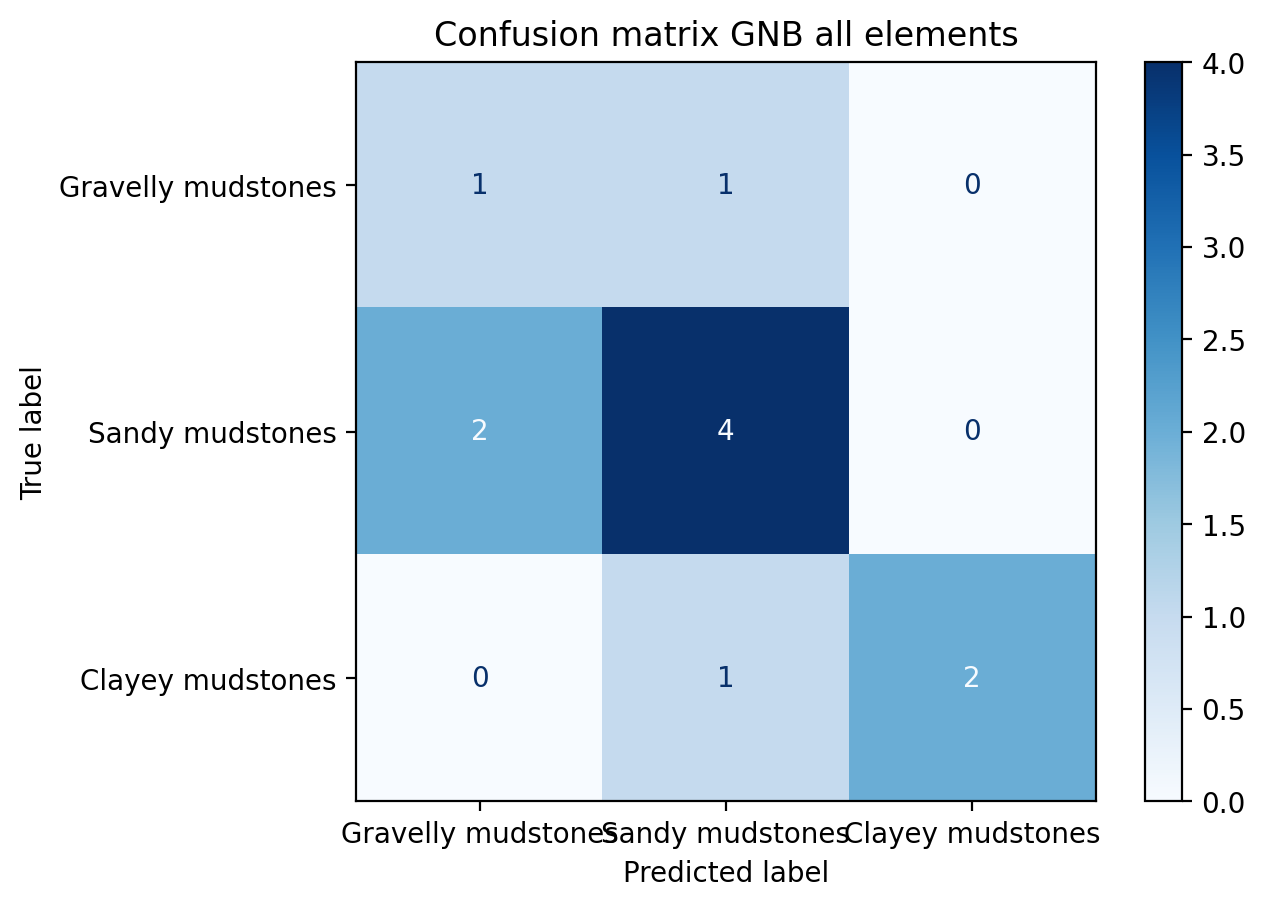

In [ ]:
title_options = [
    ("Confusion matrix GNB all elements", None)
]
for title, normalize in title_options:
    display = ConfusionMatrixDisplay.from_estimator(
        gnb,
        x_test,
        y_test,
        display_labels=['Gravelly mudstones', 'Sandy mudstones', 'Clayey mudstones'] ,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    display.ax_.set_title(title)

plt.show()

#### GNB ROC

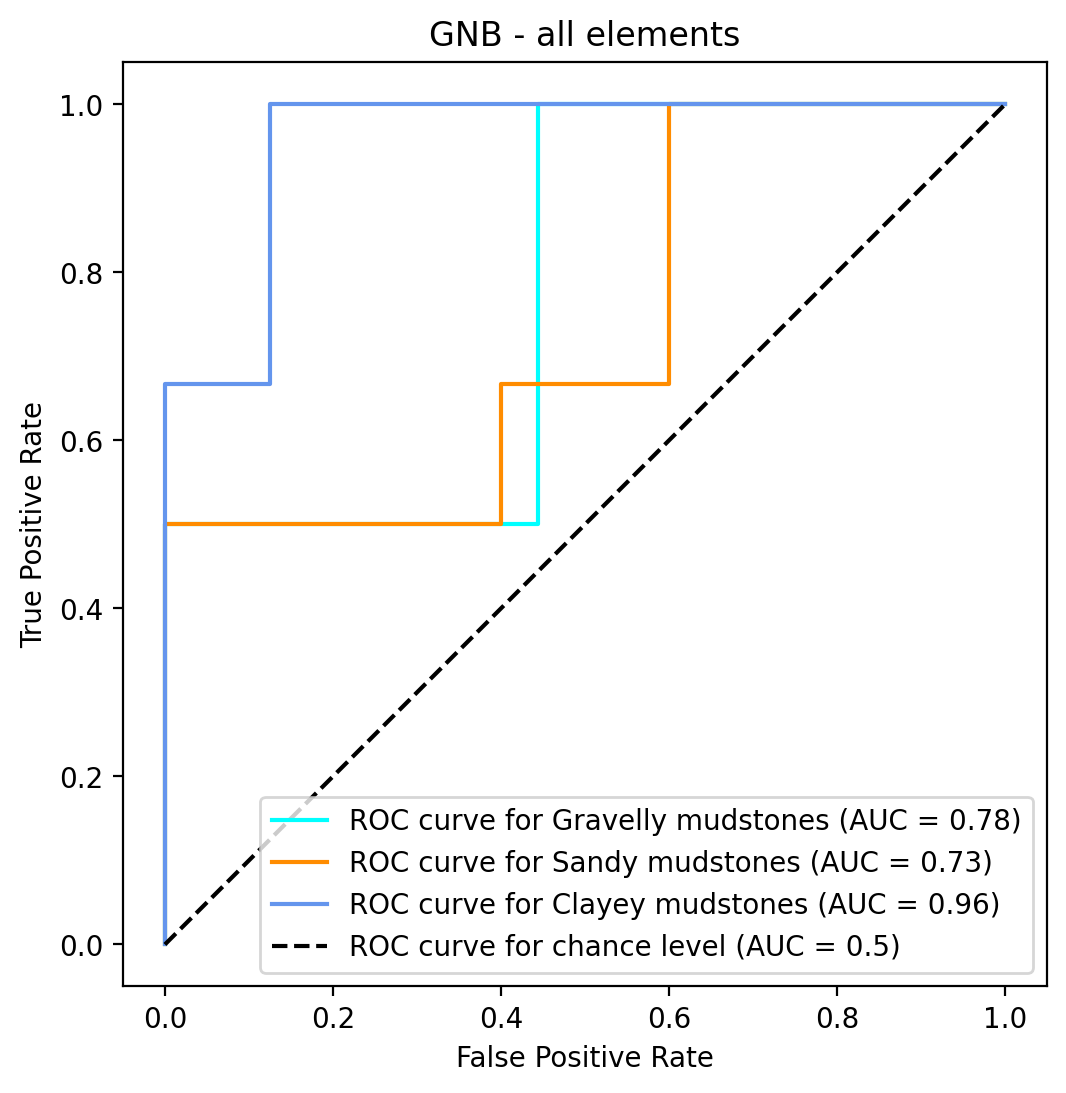

In [ ]:
gnb_roc = plot_roc_multiclass(y_train, y_test, gnb.predict_proba(x_test), ['Gravelly mudstones', 'Sandy mudstones', 'Clayey mudstones'], "GNB - all elements")
gnb_roc

In [ ]:
print("Accuracy Score:\n",gnb.score(x_train,y_train)*100)

Accuracy Score:
 87.5


## 3. RandomForestClassifier

### Gridsearch RFC

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]

# Number of features to consider at every split
max_features = ['sqrt', 'log2']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the grid
param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

# Print grid
pprint(param_grid)

# Define model
rf = RandomForestClassifier()

# Define GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV (X_train and y_train assumed defined)
grid_search.fit(x_train, y_train)

# Best parameters found
print("Best parameters found:", grid_search.best_params_)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['sqrt', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
Fitting 5 folds for each of 4320 candidates, totalling 21600 fits
Best parameters found: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}


### RFC model train

In [ ]:
# Update (June 2025): In scikit-learn version >= 1.1, 'auto' is no longer a valid option for the 'max_features' parameter in RandomForestClassifier.
# In older versions, 'auto' was equivalent to 'sqrt' for classification tasks.
# To ensure compatibility with current versions and maintain the intended behavior, we explicitly set max_features='sqrt'.
rfc = RandomForestClassifier(
    bootstrap=True,
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=800
)
rfc.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=800)

#### RFC Classification Report

In [ ]:
y_pred=rfc.predict(x_test)
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print("Classification Report is:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
print("Training Score:\n",rfc.score(x_train,y_train)*100)
print("Mean Squared Error:\n",mean_squared_error(y_test,y_pred))
print("R2 score is:\n",r2_score(y_test,y_pred))

Classification Report is:
               precision    recall  f1-score   support

           1       0.67      1.00      0.80         2
           2       1.00      0.83      0.91         6
           3       1.00      1.00      1.00         3

    accuracy                           0.91        11
   macro avg       0.89      0.94      0.90        11
weighted avg       0.94      0.91      0.91        11

Confusion Matrix:
 [[2 0 0]
 [1 5 0]
 [0 0 3]]
Training Score:
 100.0
Mean Squared Error:
 0.09090909090909091
R2 score is:
 0.7962962962962963


#### RFC Confusion matrix

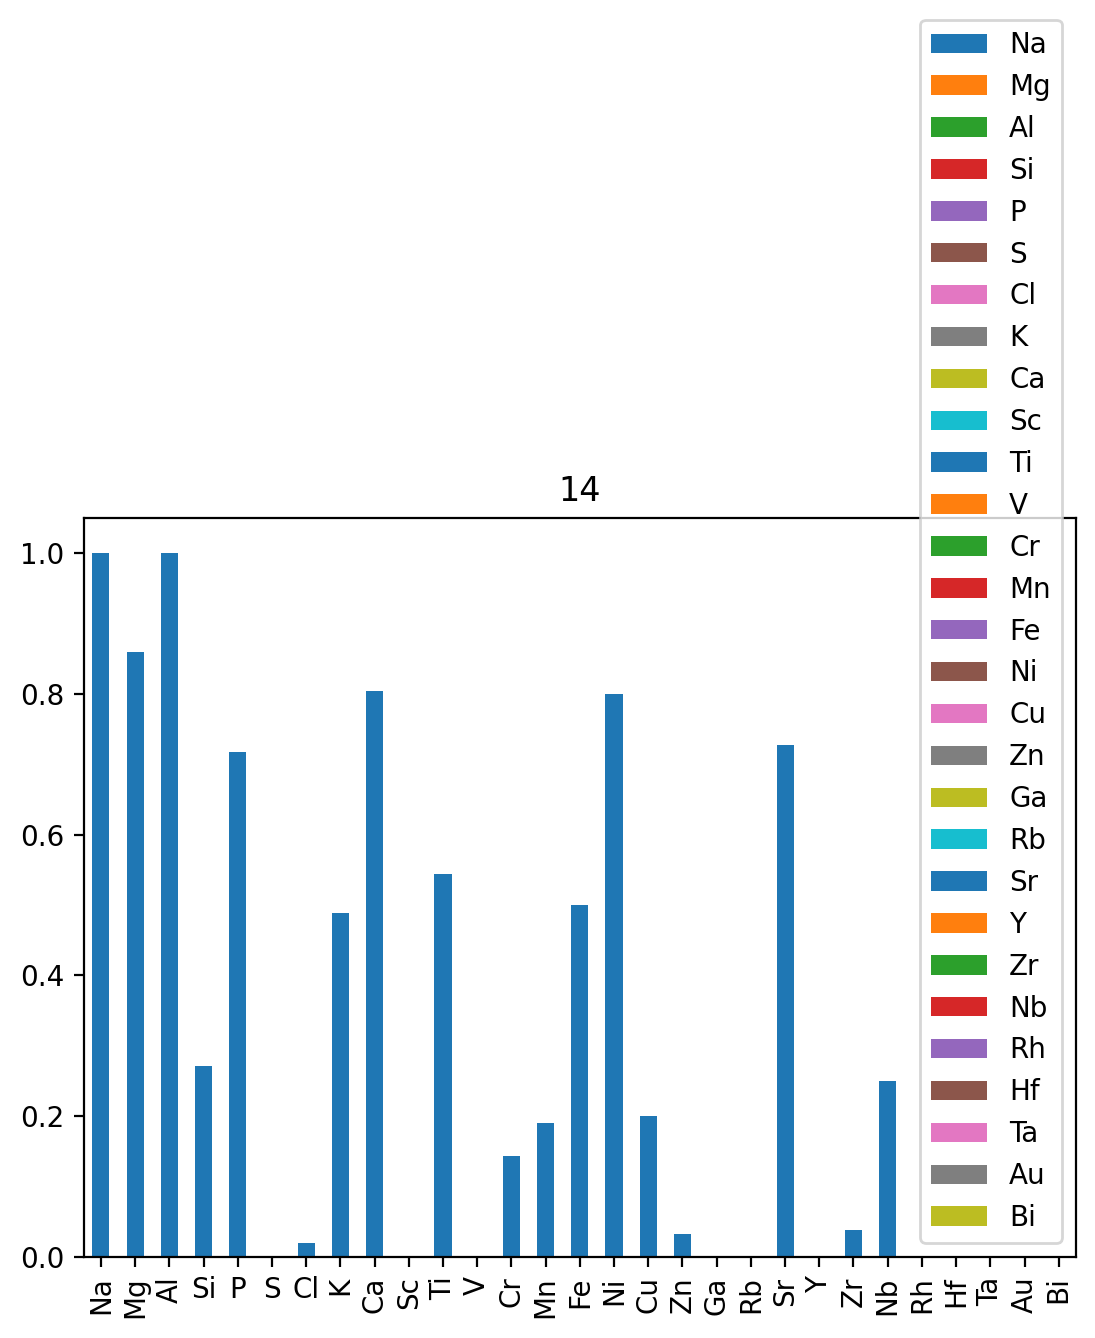

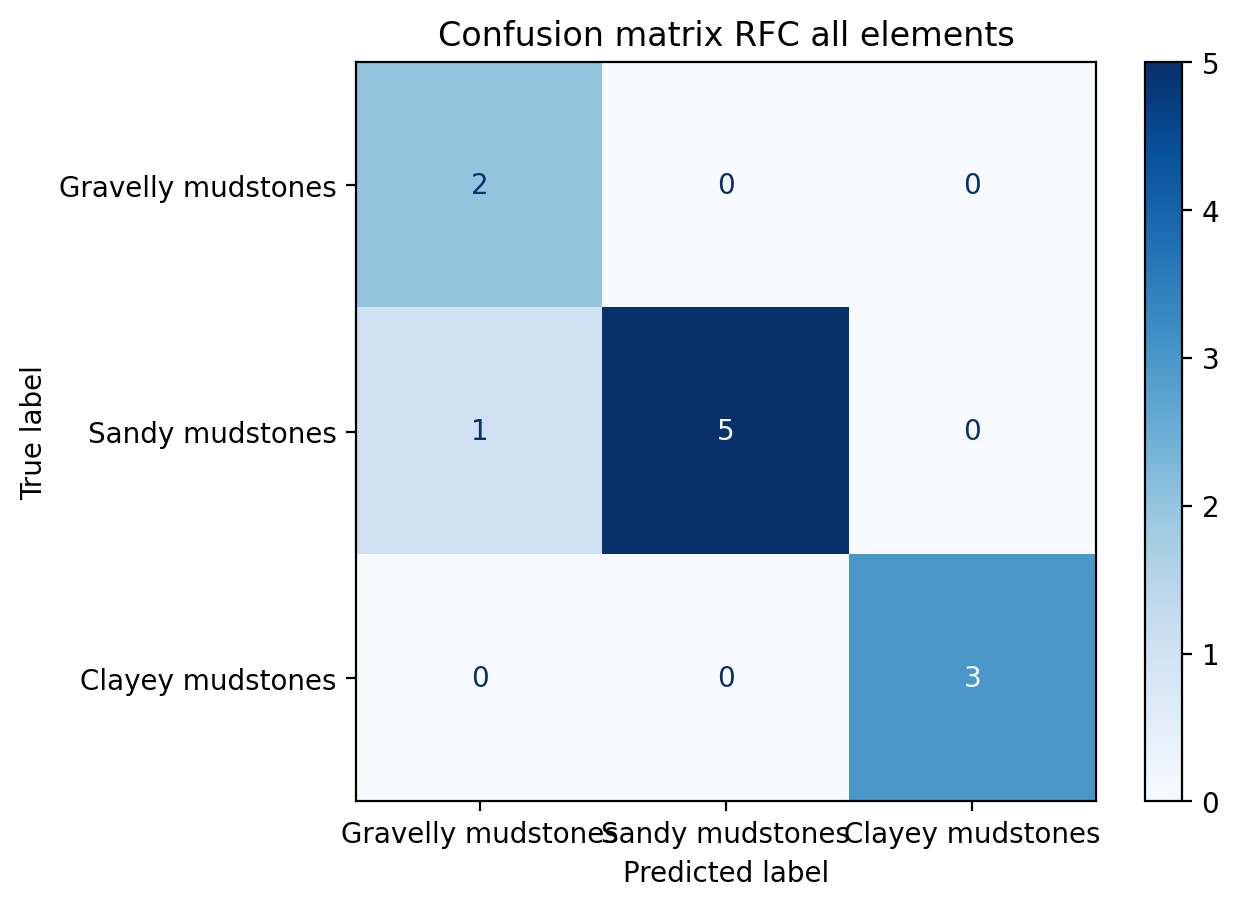

In [ ]:
title_options = [
    ("Confusion matrix RFC all elements", None)
]
for title, normalize in title_options:
    display = ConfusionMatrixDisplay.from_estimator(
        rfc,
        x_test,
        y_test,
        display_labels=['Gravelly mudstones', 'Sandy mudstones', 'Clayey mudstones'] ,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    display.ax_.set_title(title)

plt.show()

#### RFC ROC

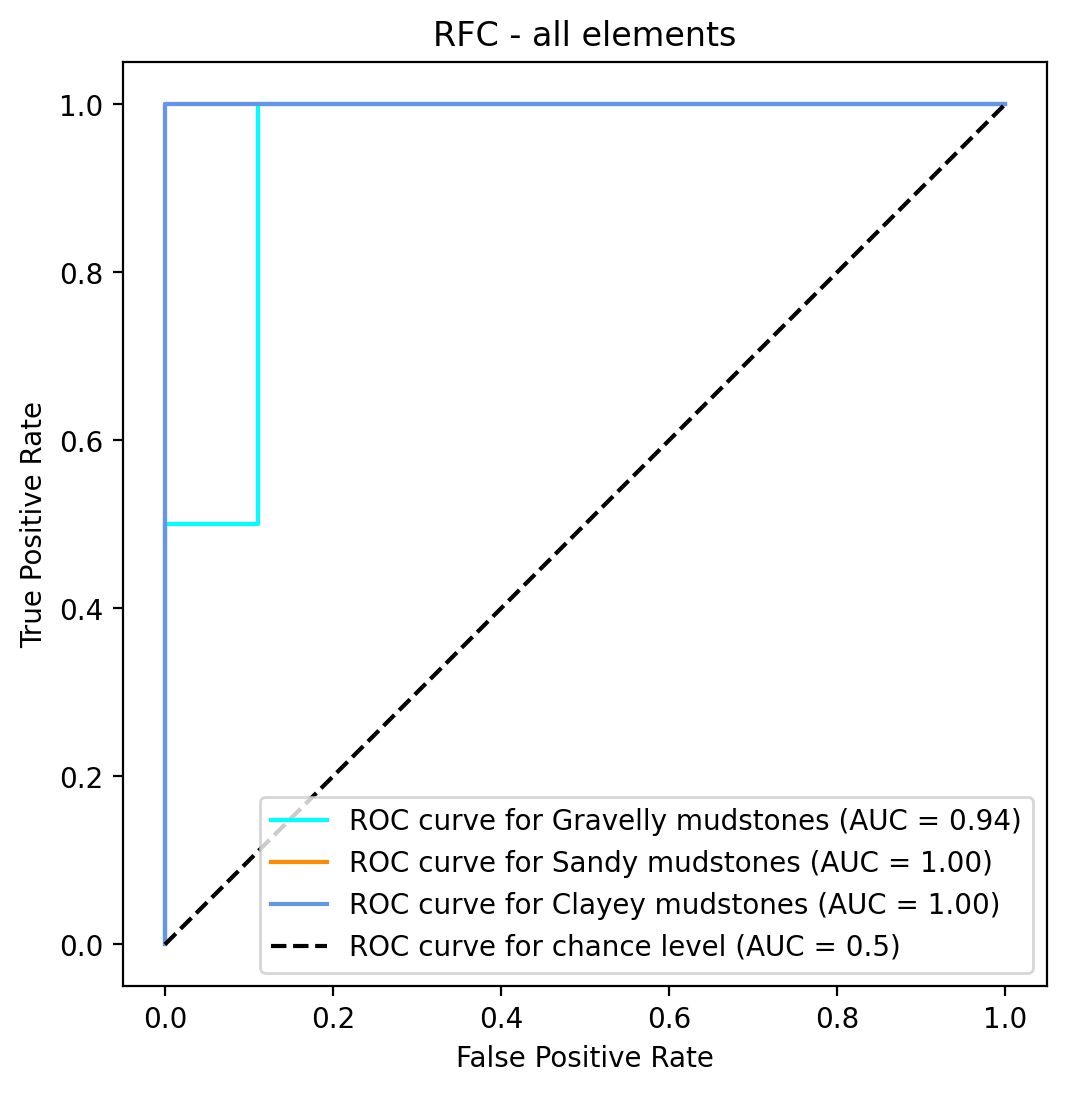

In [ ]:
rfc_roc = plot_roc_multiclass(y_train, y_test, rfc.predict_proba(x_test), ['Gravelly mudstones', 'Sandy mudstones', 'Clayey mudstones'], "RFC - all elements")
rfc_roc

### RFC XAI

In [ ]:
# Fits the explainer
explainer = shap.Explainer(rfc.predict, x_train)
# Calculates the SHAP values - It takes some time
shap_values = explainer(x_test)

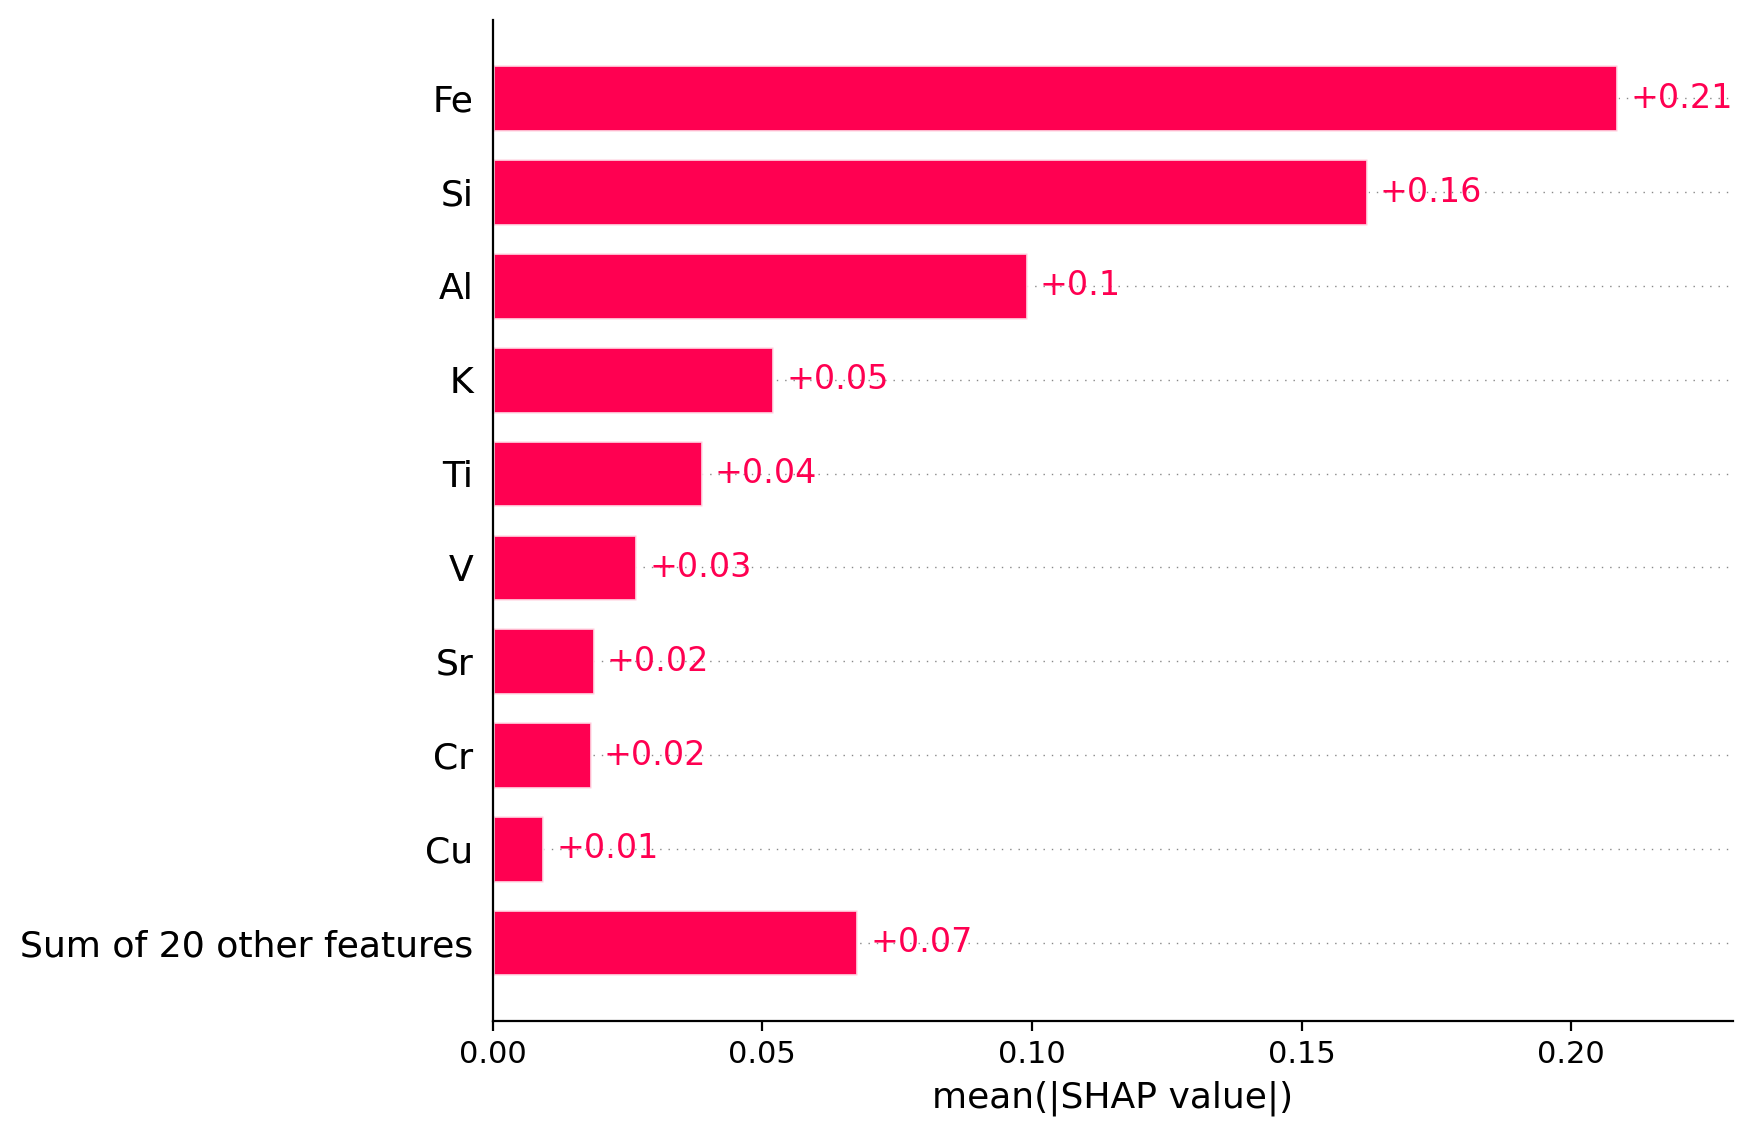

In [ ]:
shap.plots.bar(shap_values)

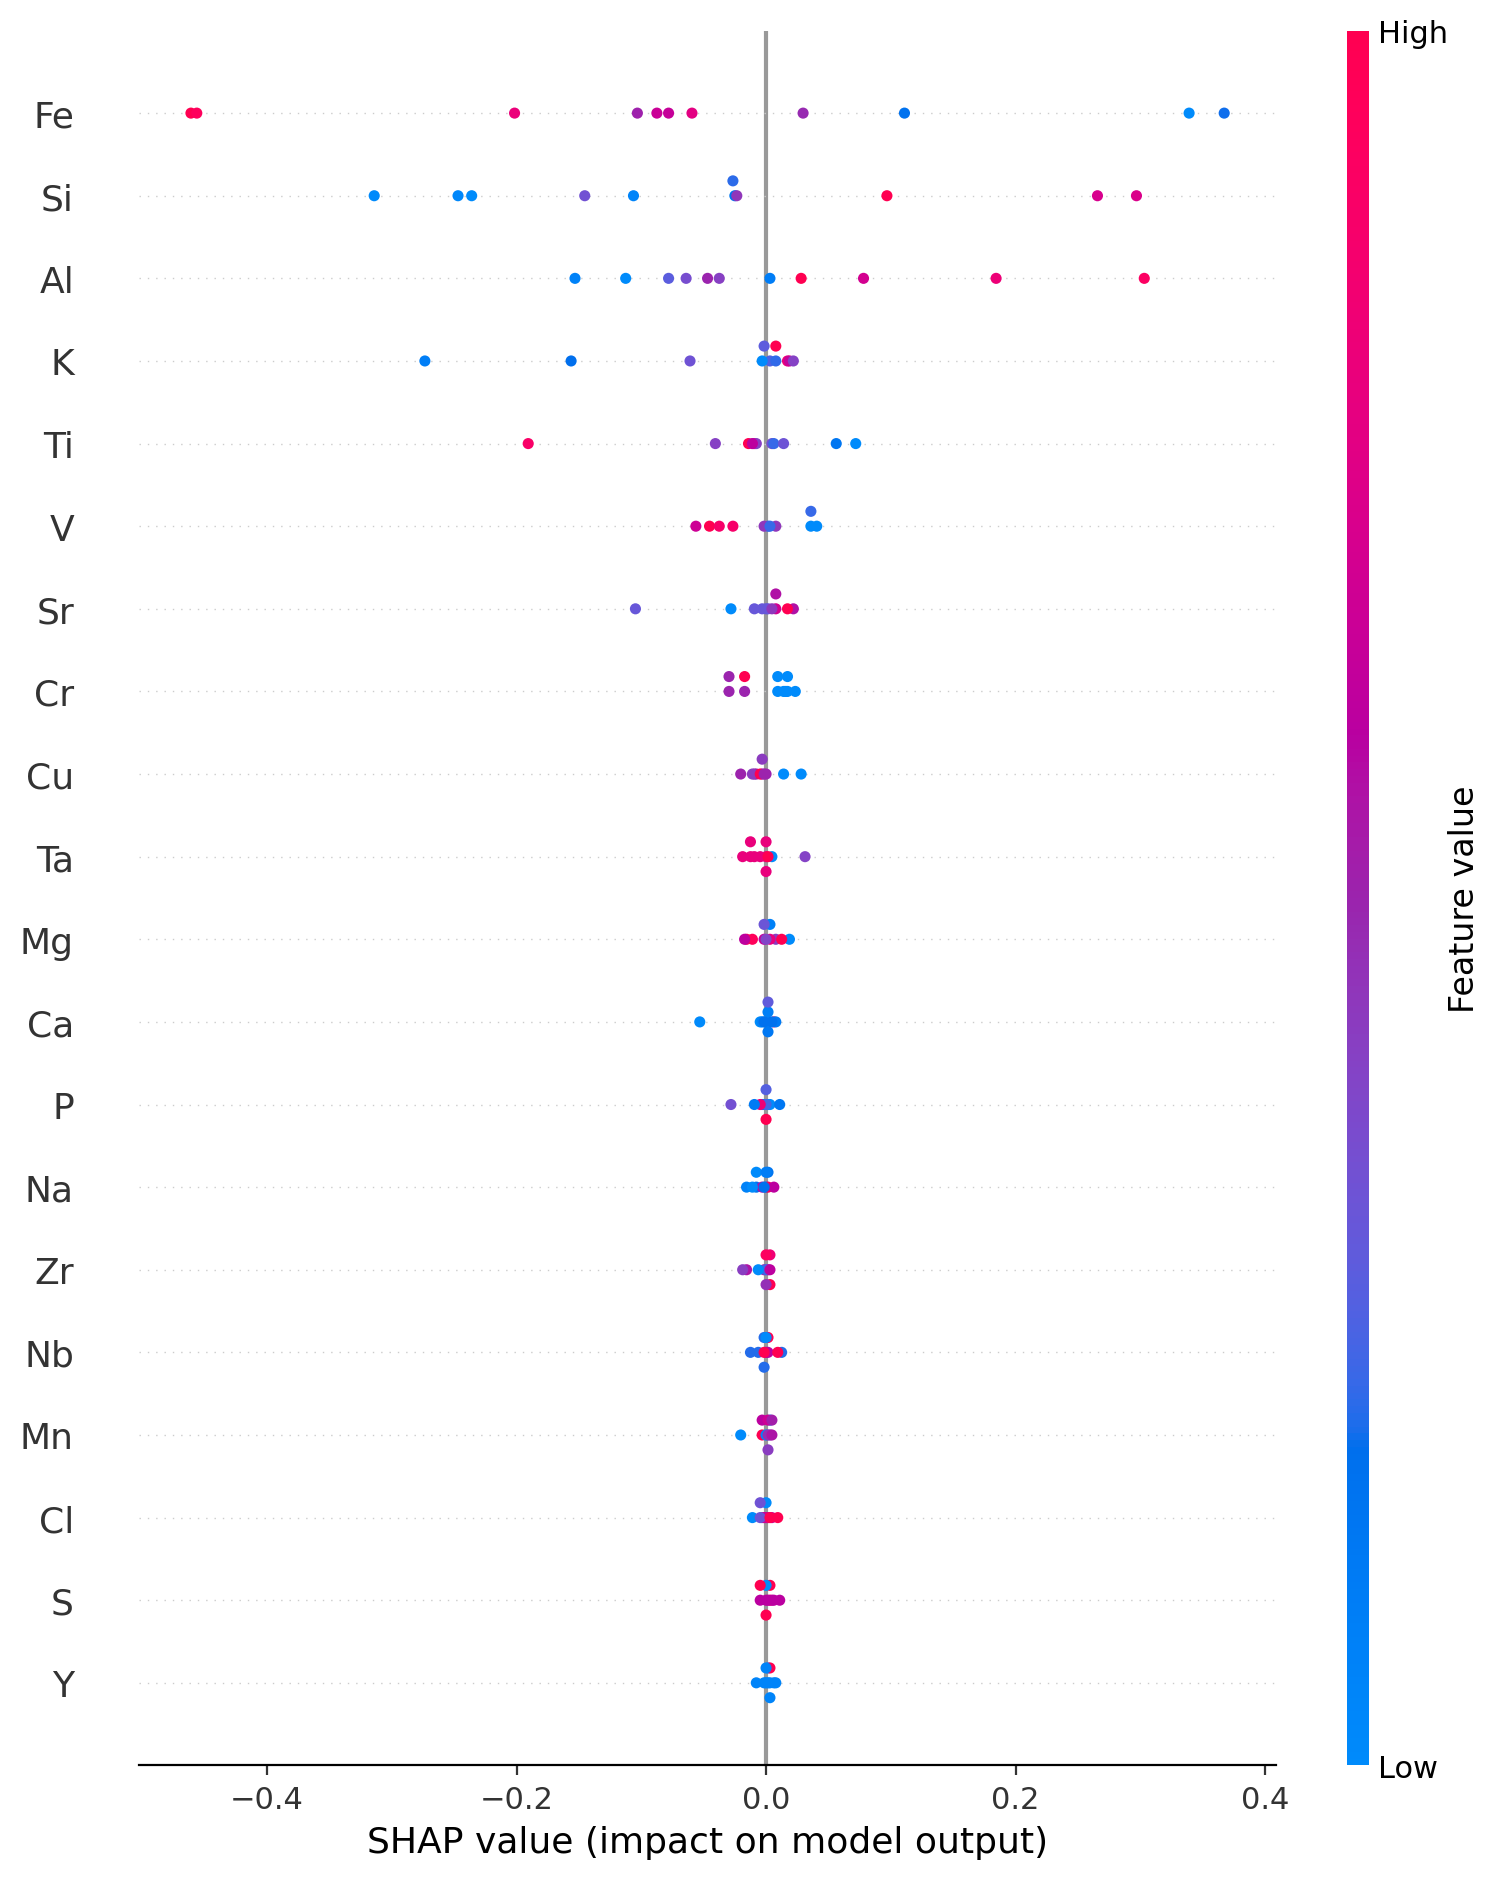

In [ ]:
shap.summary_plot(shap_values)

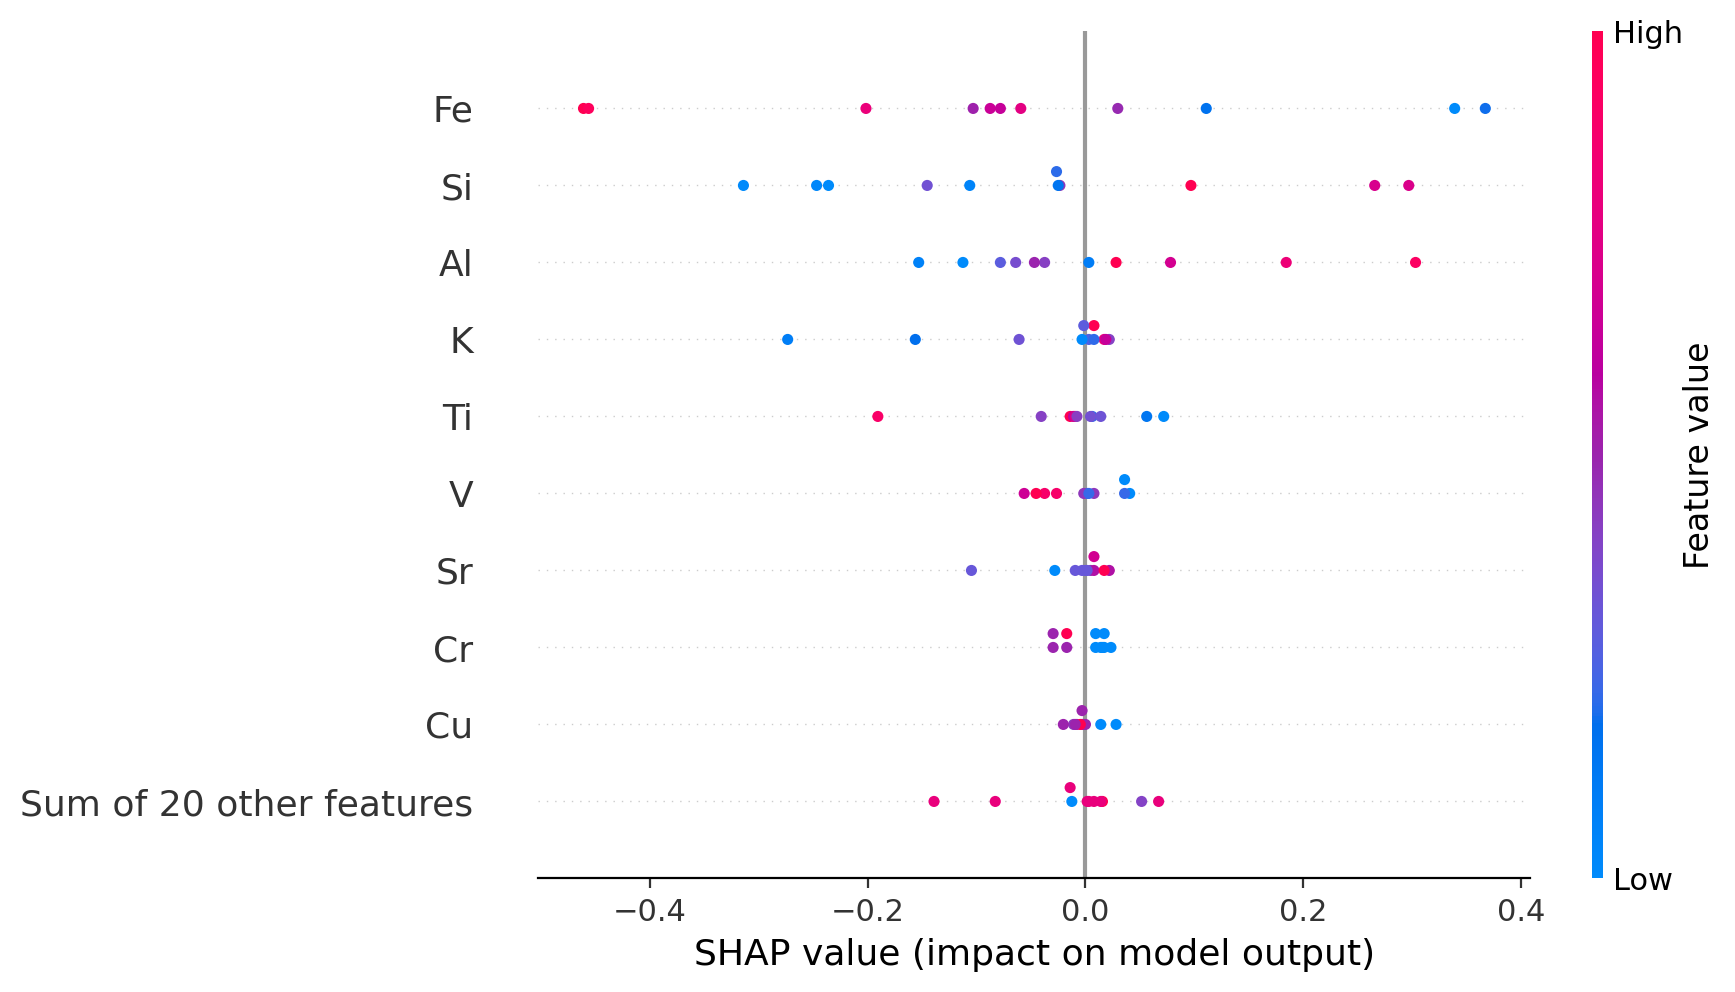

In [ ]:
# or
shap.plots.beeswarm(shap_values)

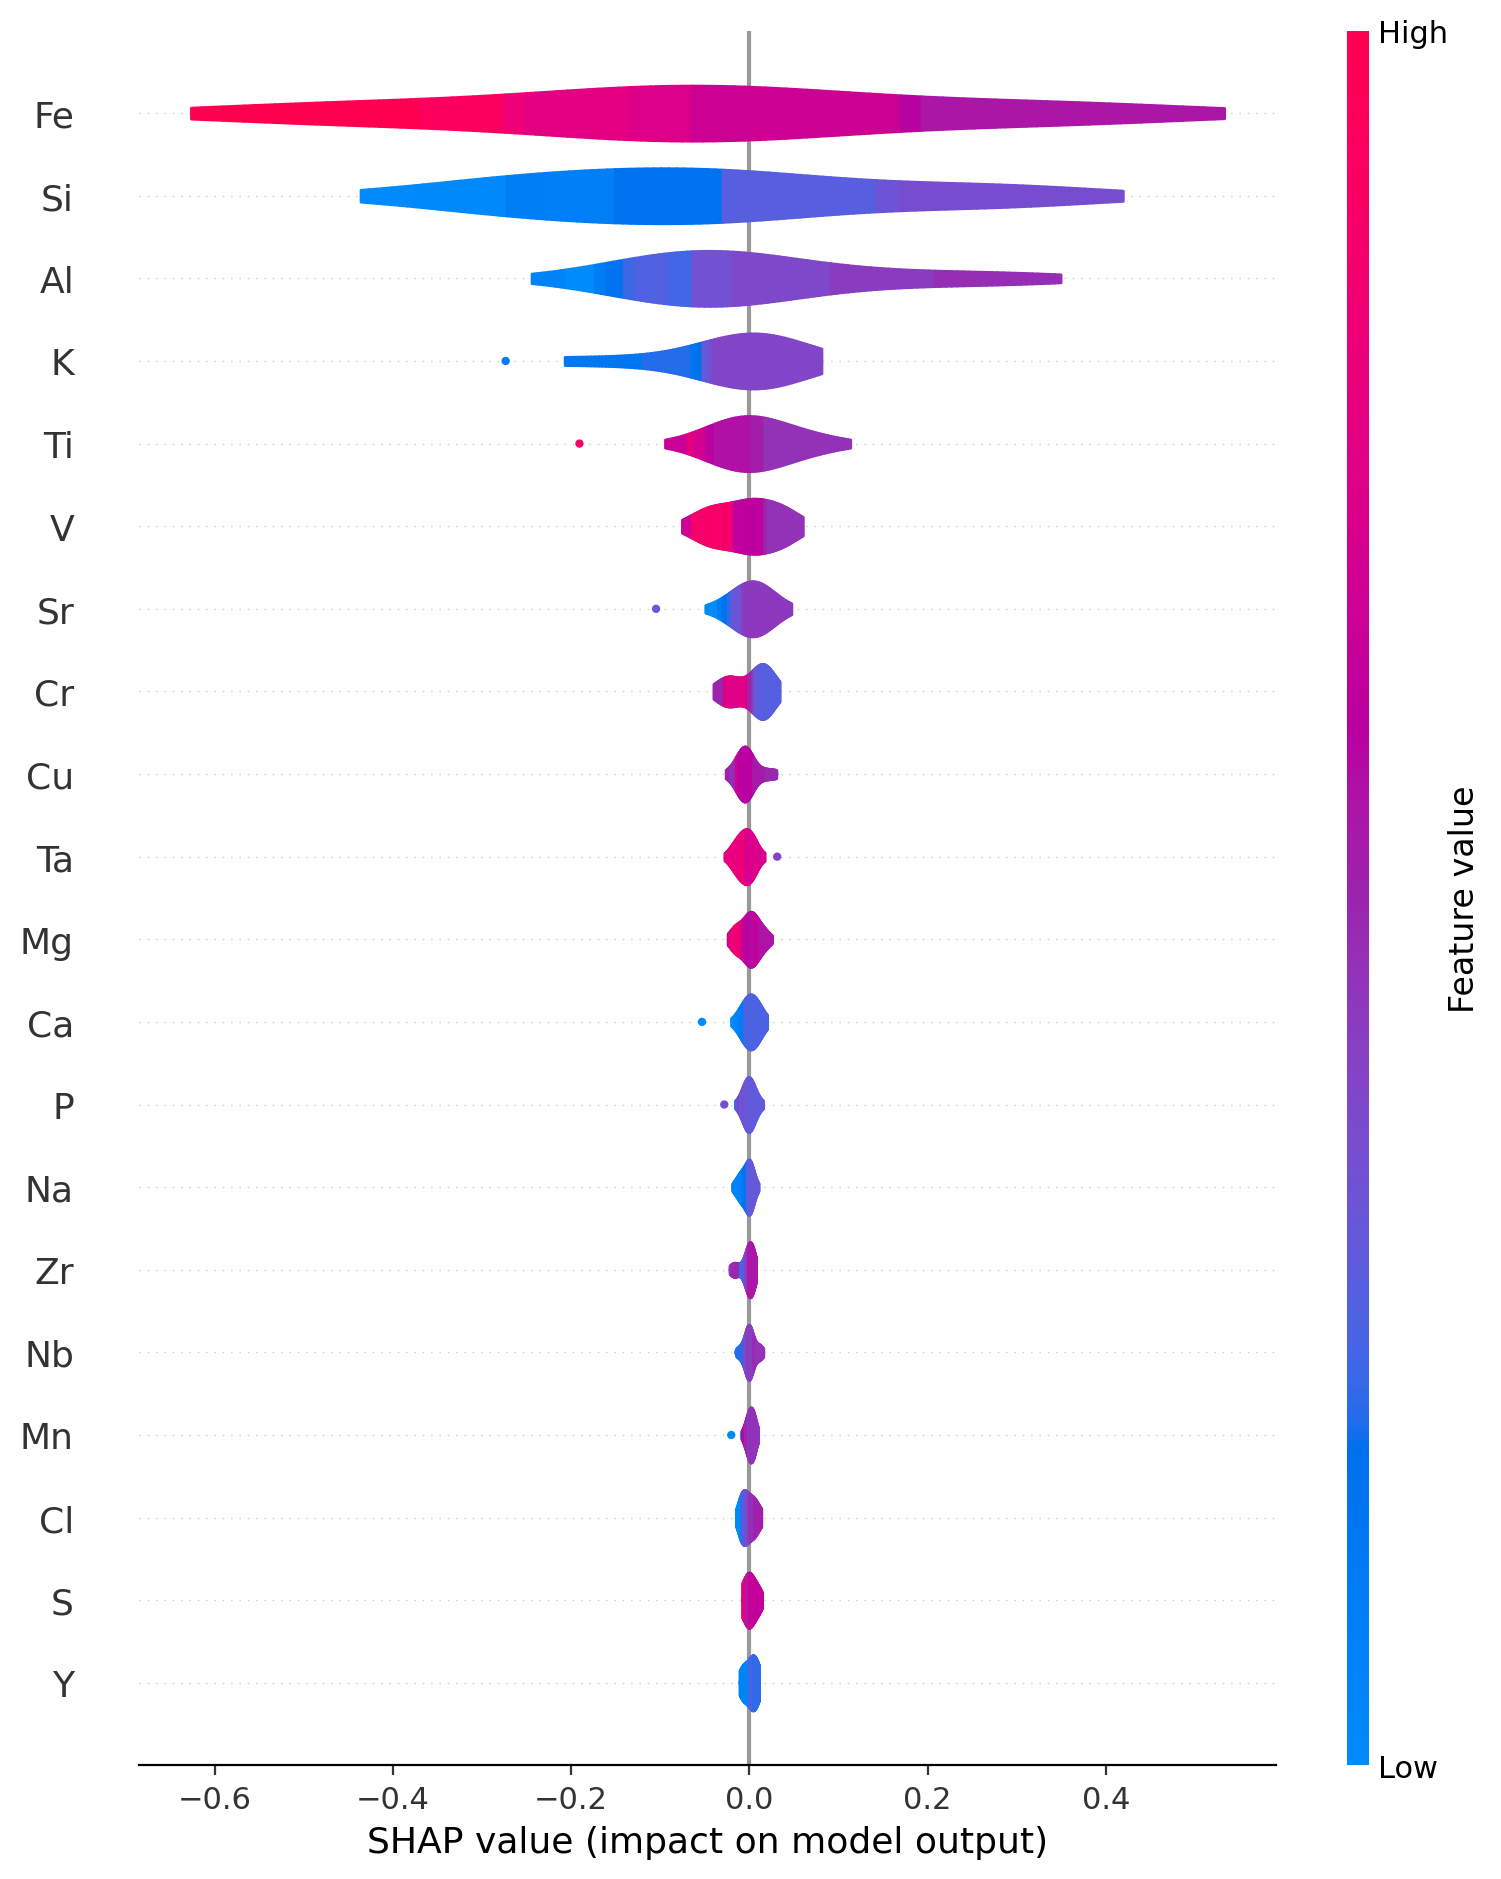

In [ ]:
shap.summary_plot(shap_values, plot_type='violin')

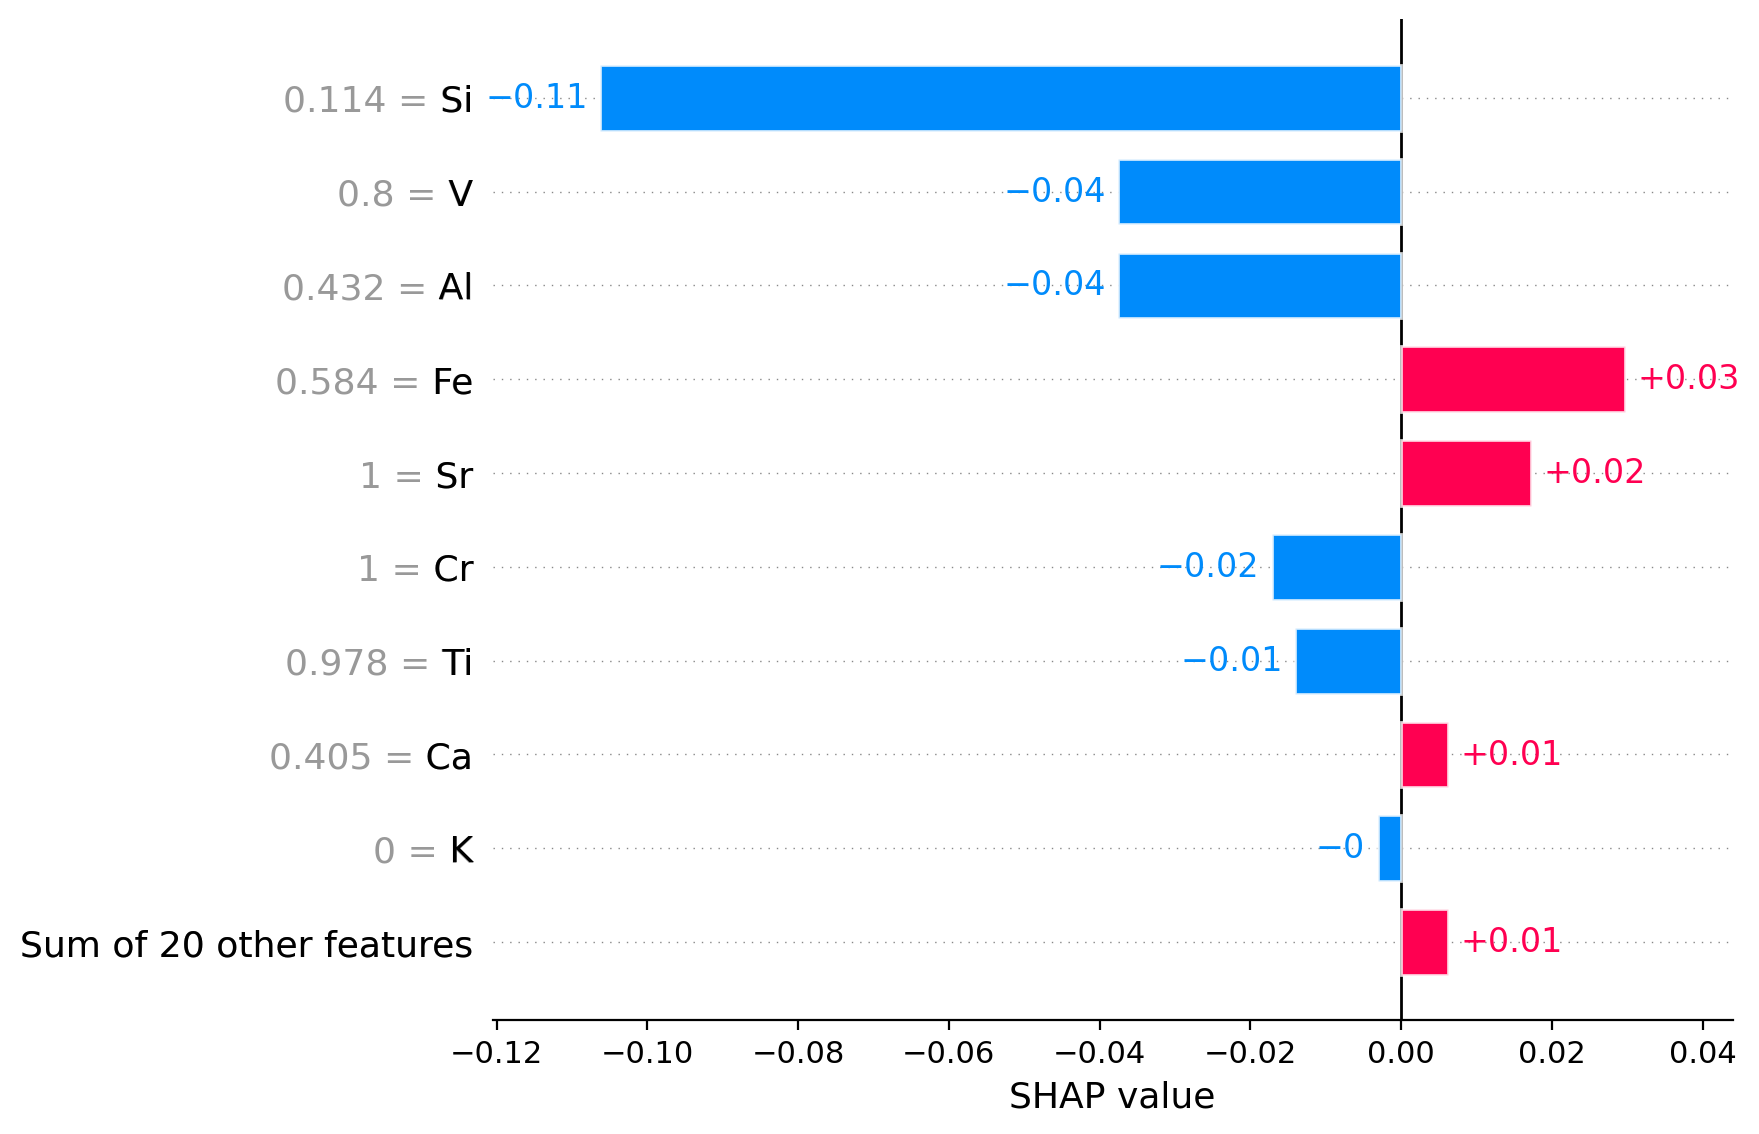

In [ ]:
#Local bar plot
shap.plots.bar(shap_values[8])

In [ ]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

# Write in a function
def shap_plot(j):
    explainerModel = shap.TreeExplainer(rfc)
    shap_values_Model = explainerModel.shap_values(x)
    p = shap.force_plot(explainerModel.expected_value[j], shap_values_Model[:,:,j], x)
    return(p)

In [ ]:
shap.initjs()
shap_plot(0)

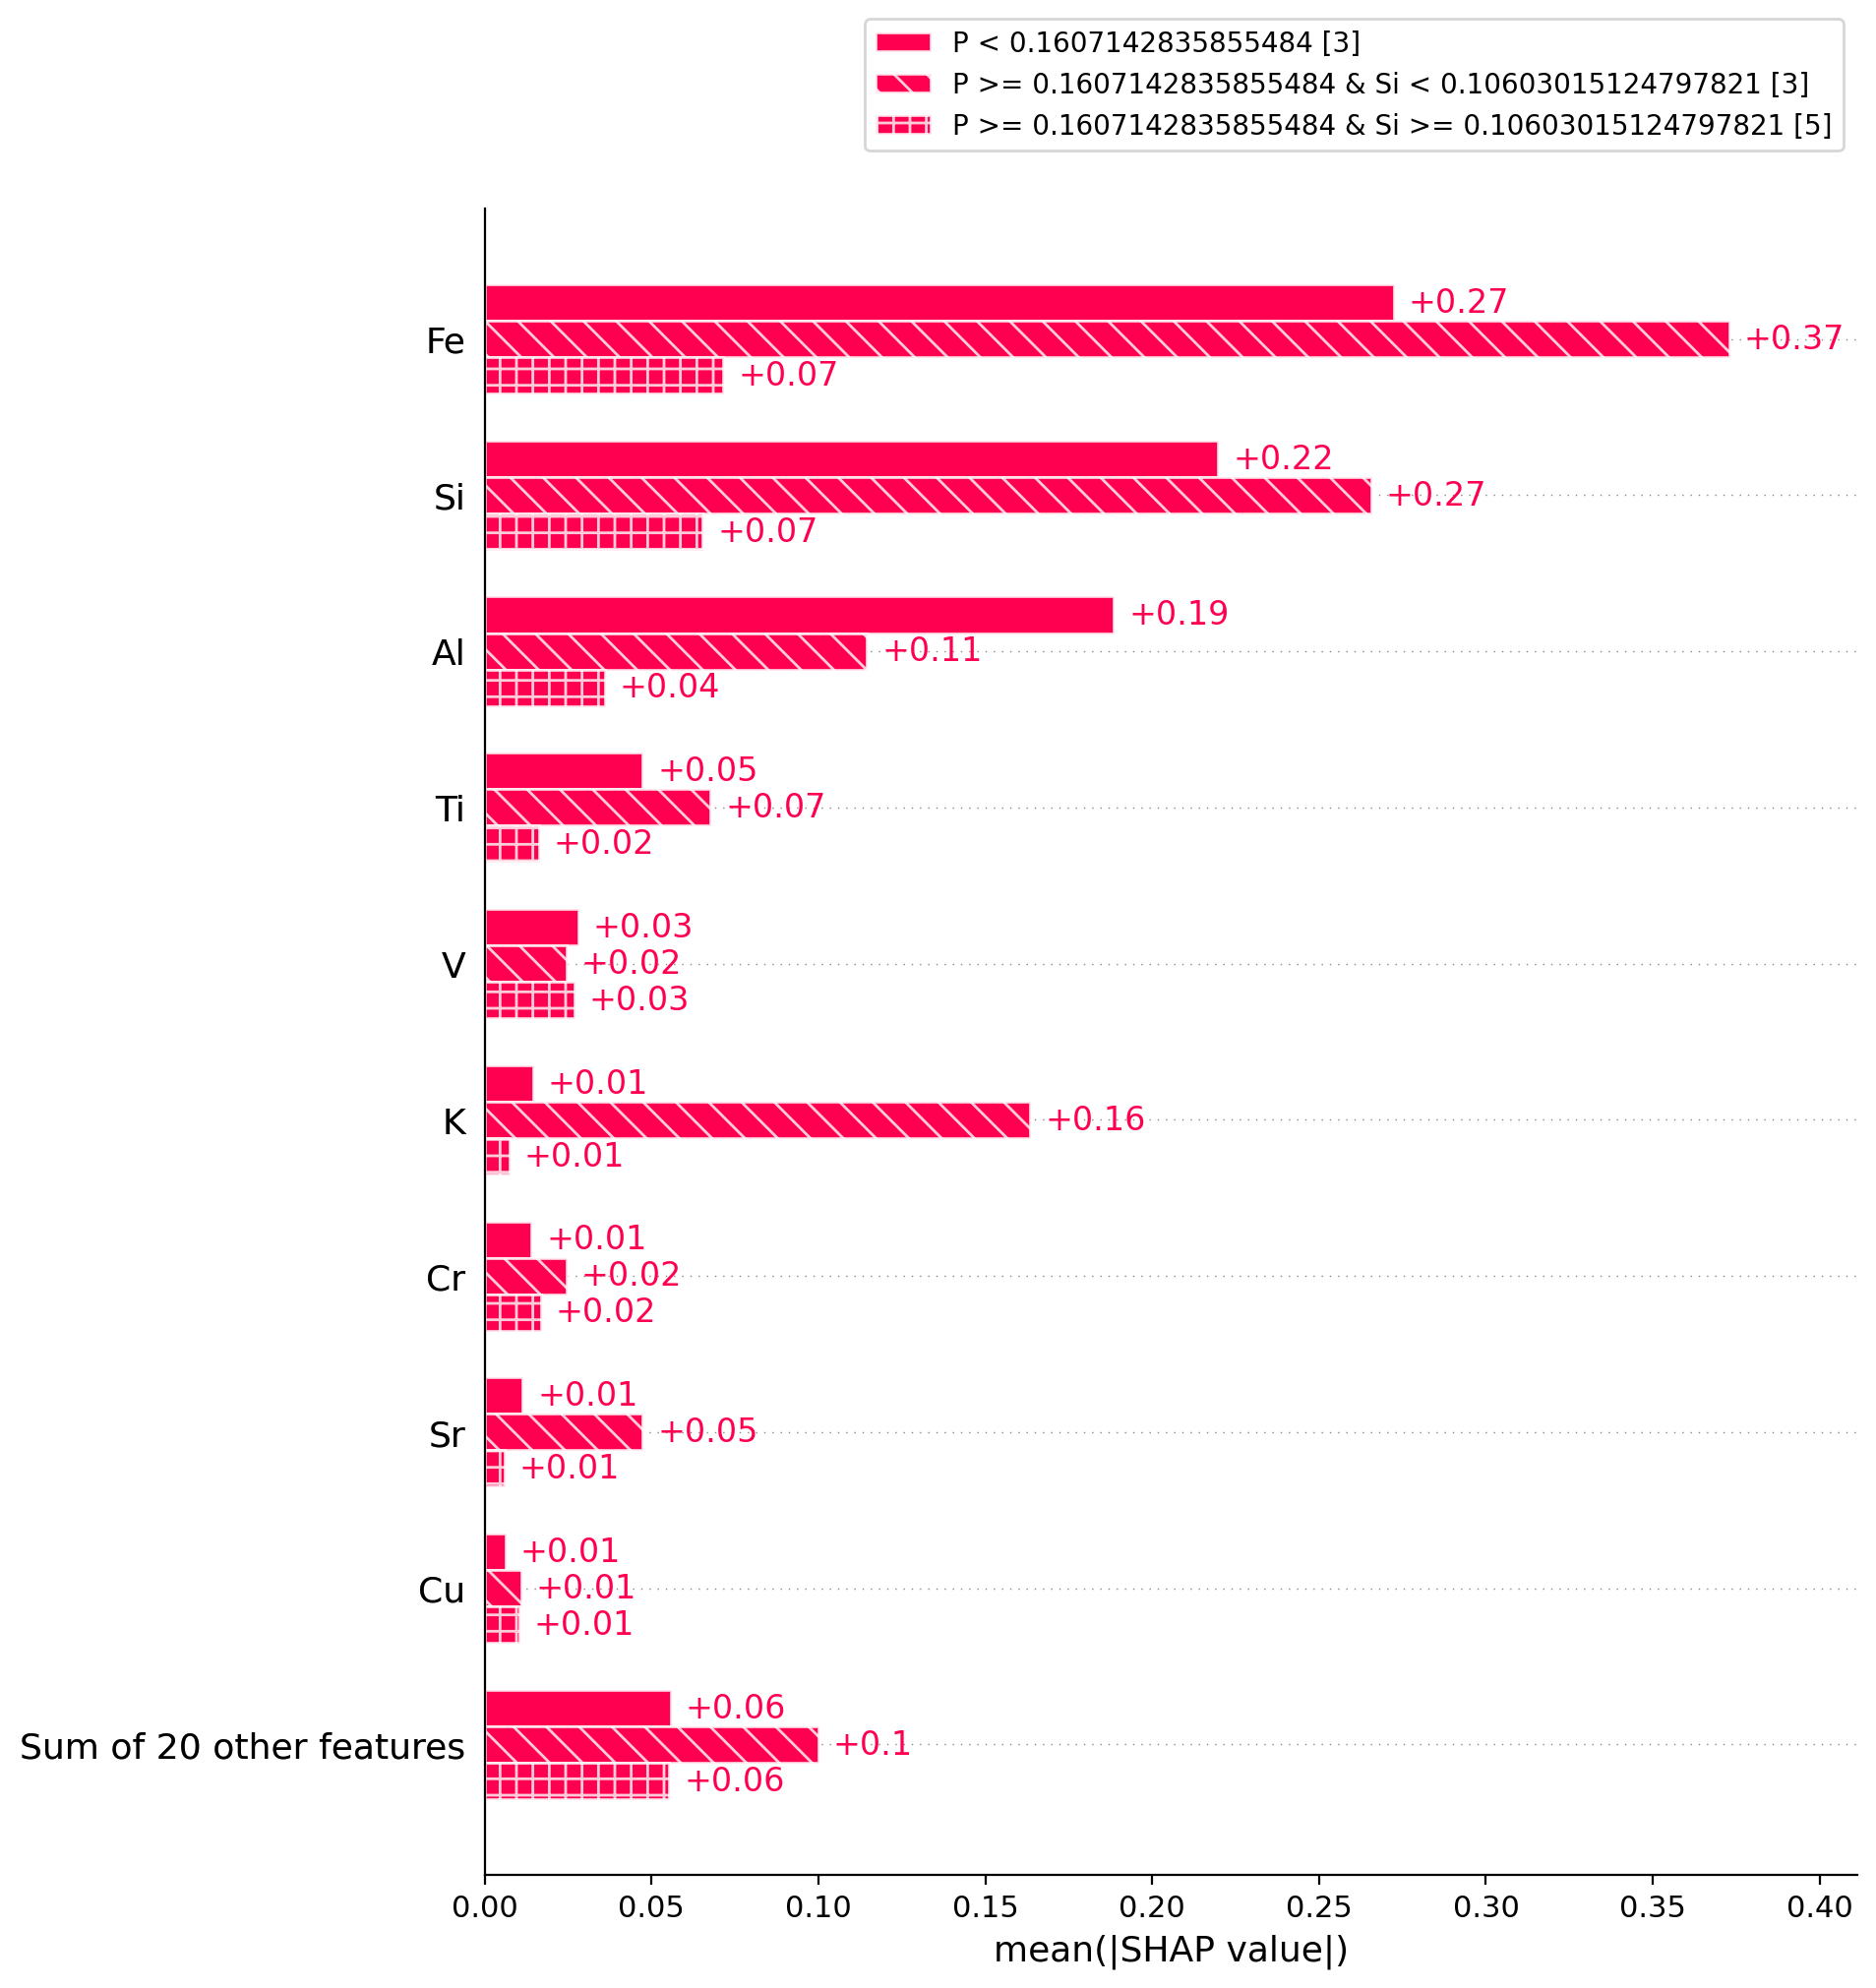

In [ ]:
#shap.plots.bar(shap_values.cohorts(3).abs.mean(0))
shap.plots.bar(shap_values.cohorts(3).abs.mean(0), show=False)
fig = plt.gcf() # gcf means "get current figure"
fig.set_figheight(11)
fig.set_figwidth(9)
#plt.rcParams['font.size'] = '12'
ax = plt.gca() #gca means "get current axes"
leg = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102))
plt.show()

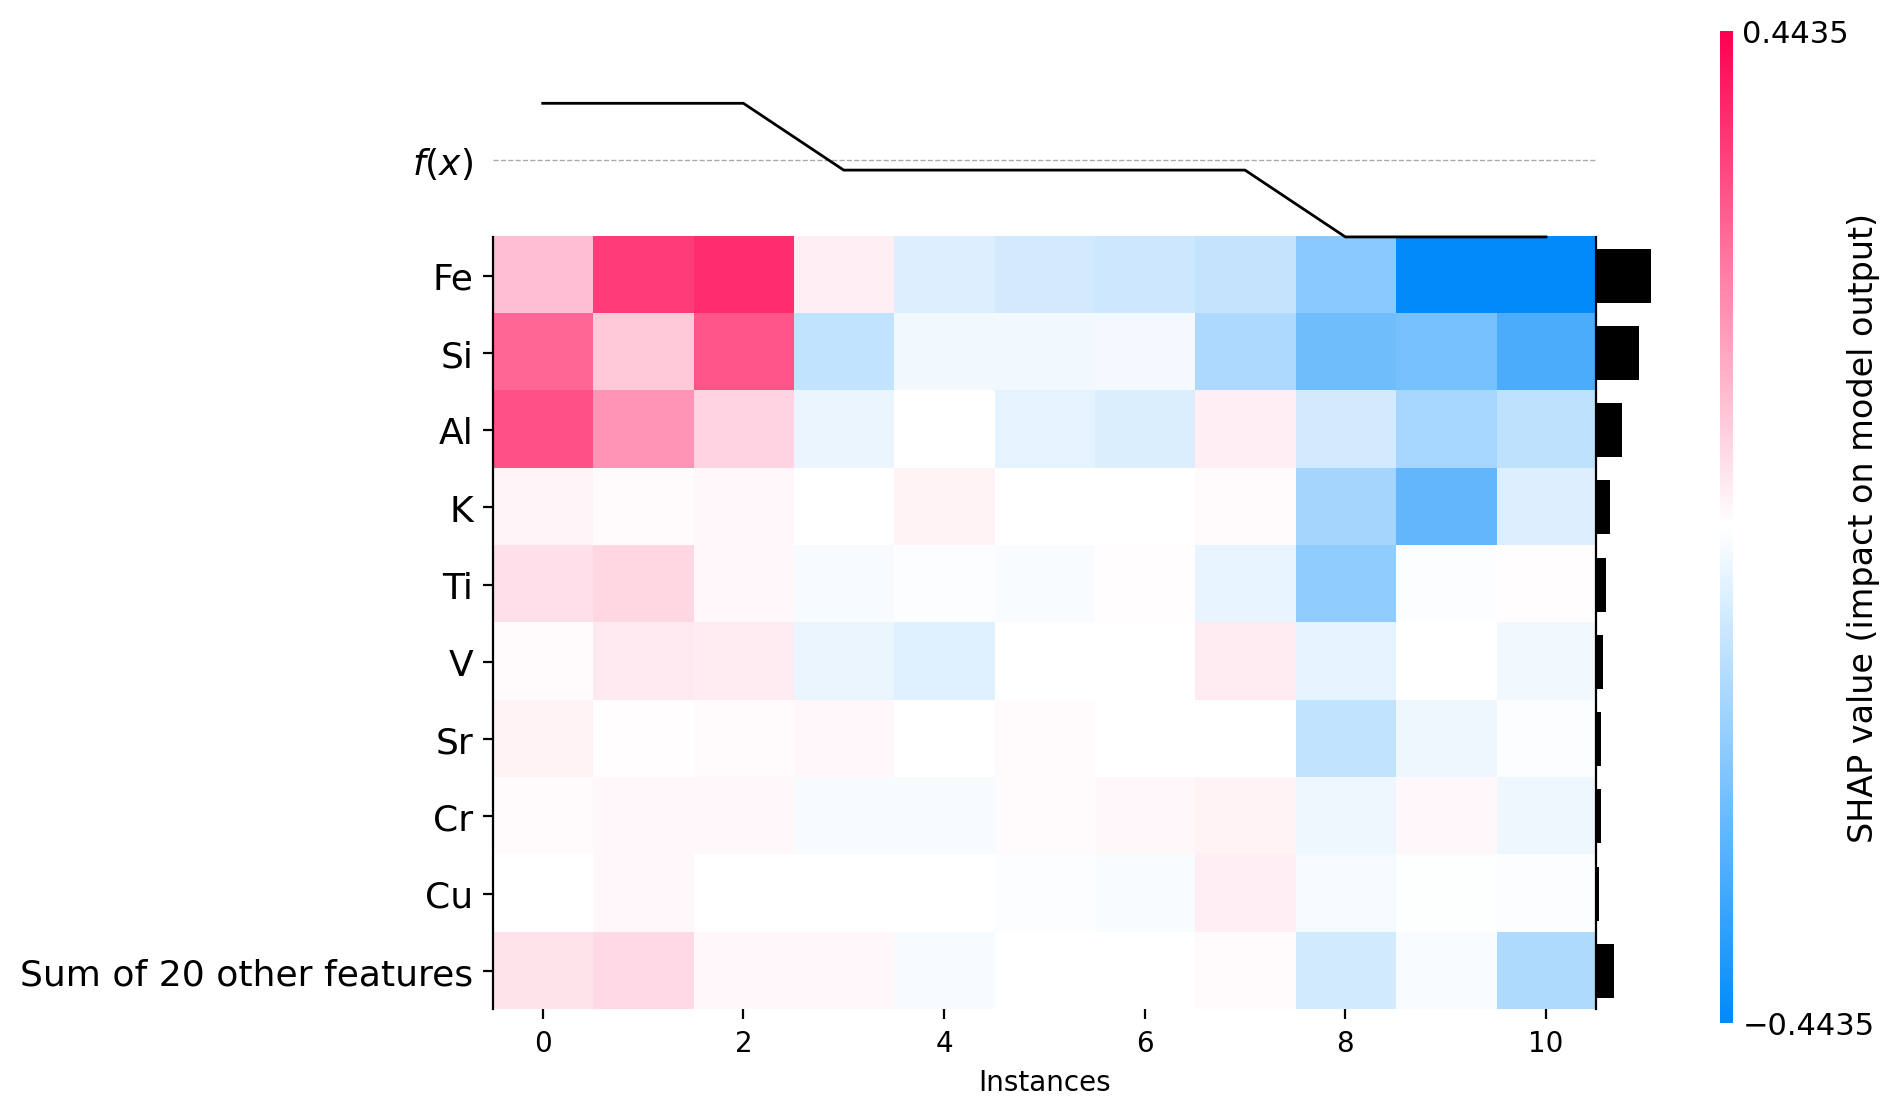

<Axes: xlabel='Instances'>

In [ ]:
shap.plots.heatmap(shap_values[0:])

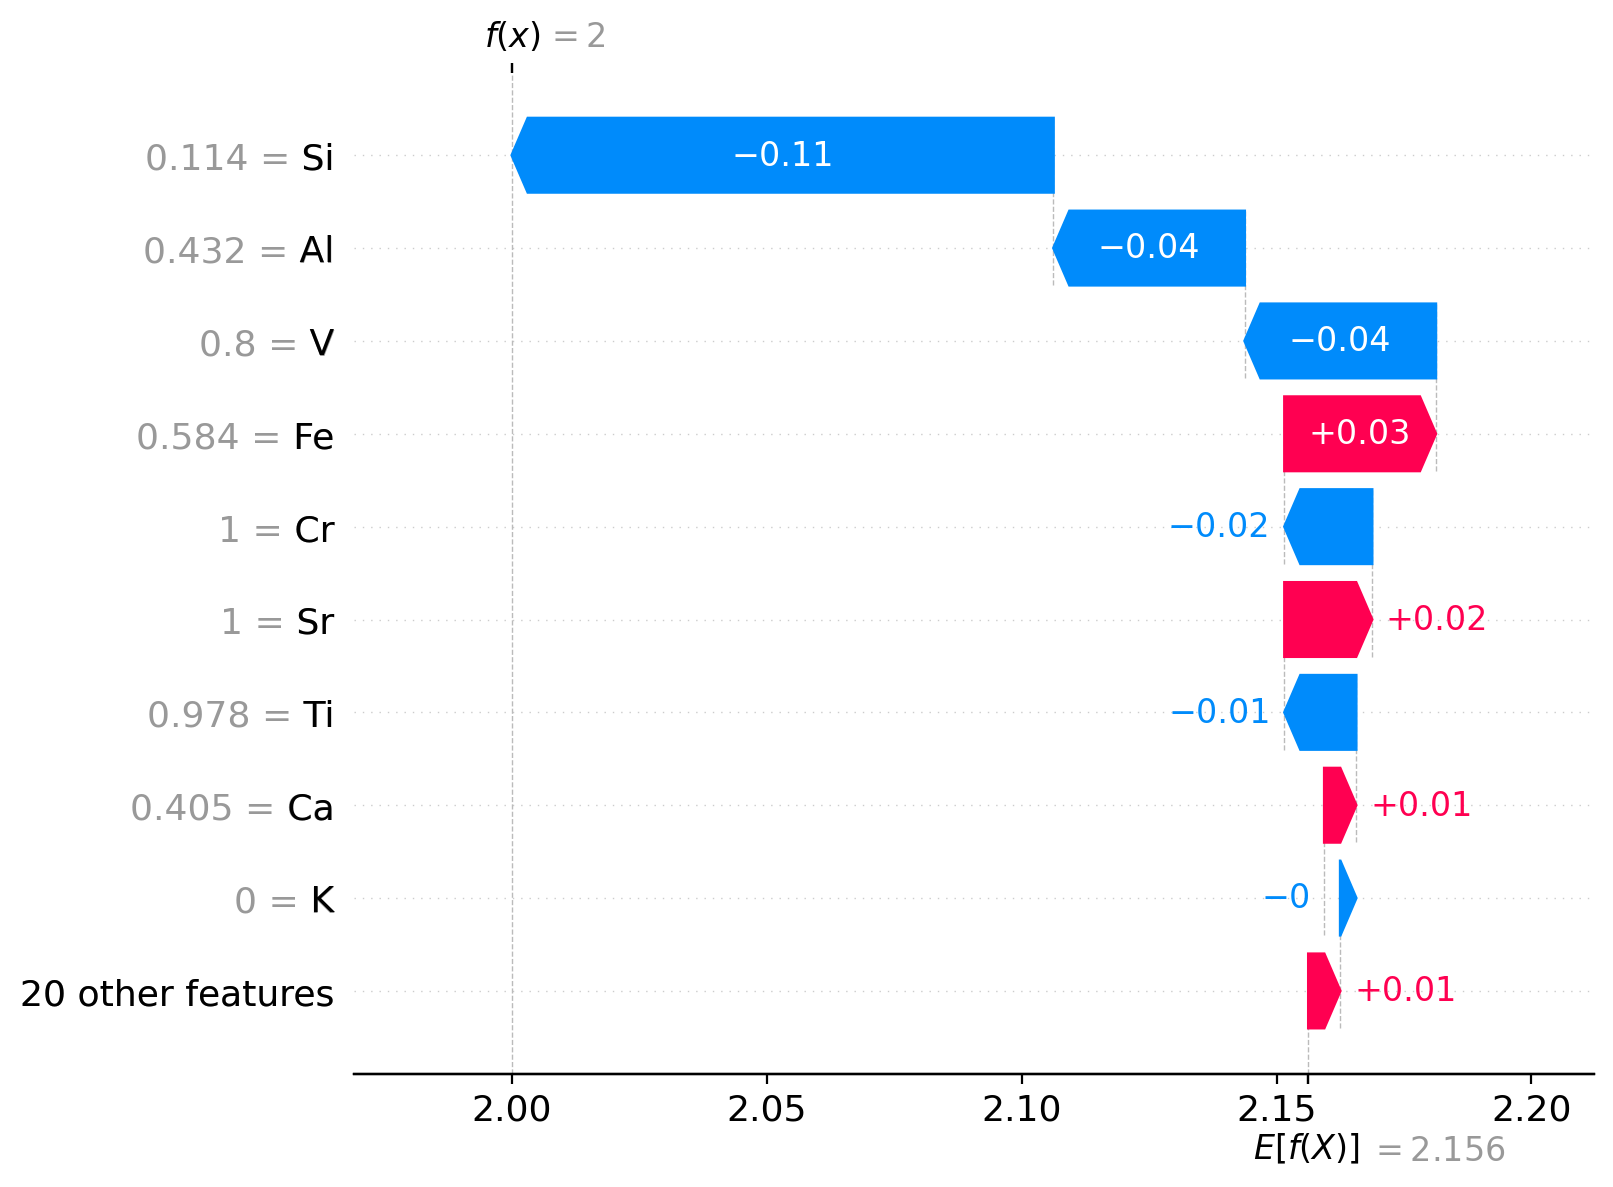

In [ ]:
#Waterfall plot
shap.plots.waterfall(shap_values[8])
#The waterfall plot has the same information, represented in a different manner.
#Here we can see how the sum of all the SHAP values equals the difference between
#the prediction f(x) and the expected value E[f(x)].

In [ ]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(rfc)
multi_shap_values = explainer.shap_values(x)

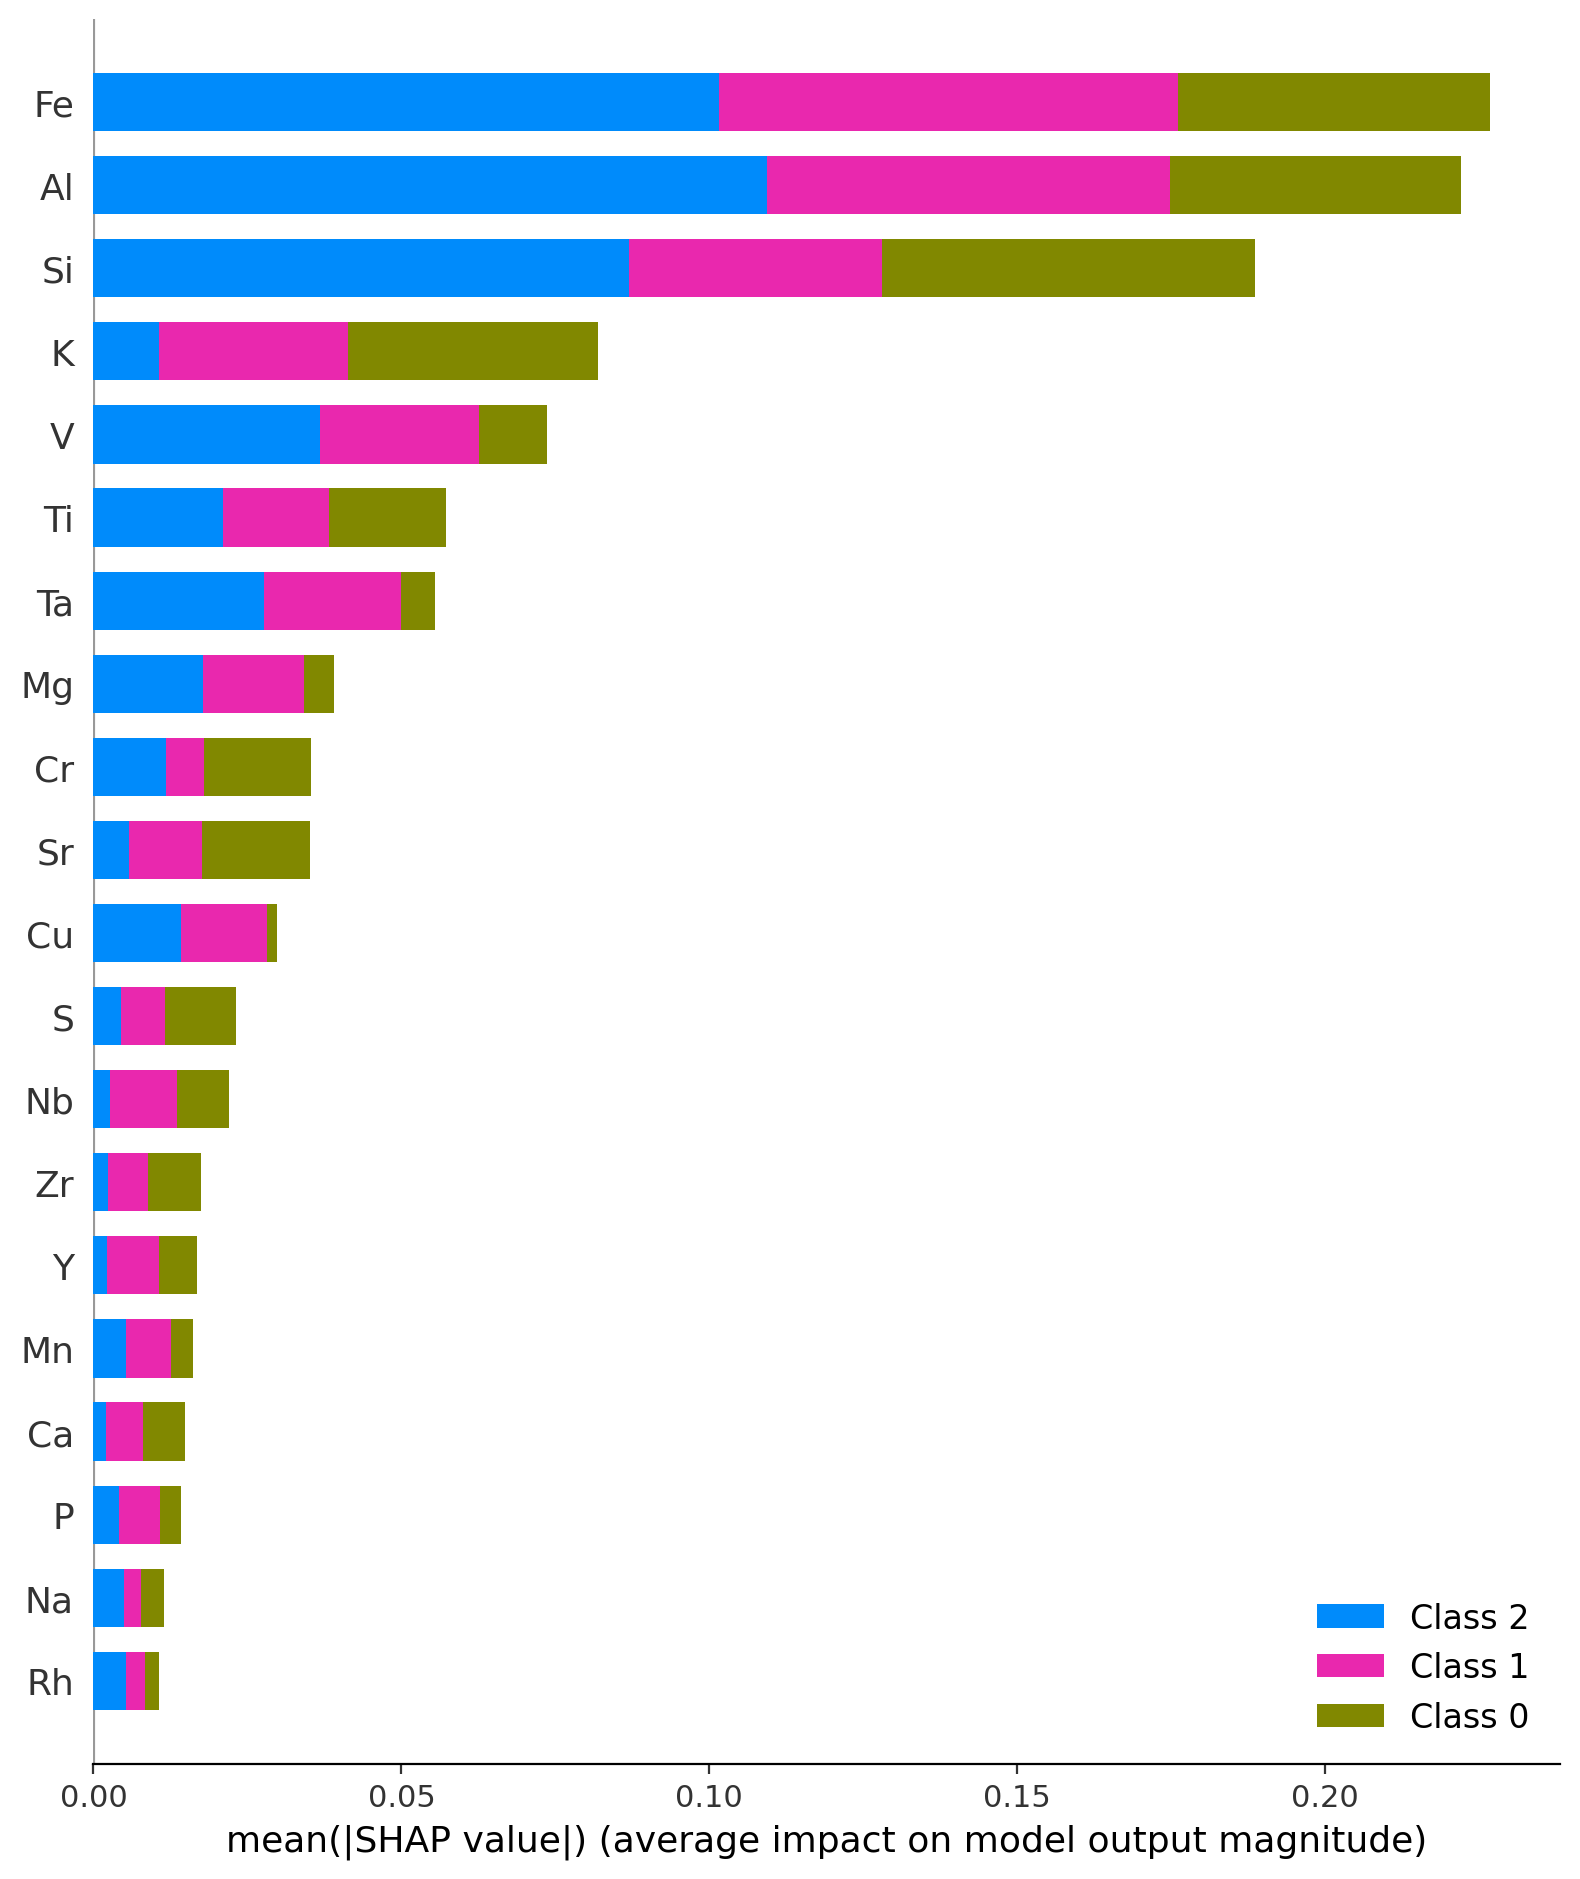

In [ ]:
shap.summary_plot(multi_shap_values, x_test, plot_type="bar")

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], multi_shap_values[:,:,0], x)

In [ ]:
# visualize the first prediction's explaination with default colors
shap.initjs()
shap.force_plot(explainer.expected_value[0], multi_shap_values[:,:,0][0,:], x.iloc[0,:])

In [ ]:
# visualize the first prediction's explaination with default colors
shap.initjs()
shap.force_plot(explainer.expected_value[1], multi_shap_values[:,:,1][0,:], x.iloc[0,:])

In [ ]:
# visualize the first prediction's explaination with default colors
shap.initjs()
shap.force_plot(explainer.expected_value[2], multi_shap_values[:,:,2][0,:], x.iloc[0,:])

In [ ]:
# visualize the first prediction's explaination with default colors
#shap.initjs()
#shap.force_plot(explainer.expected_value[2], shap_values[2][0,:], x.iloc[0,:])

In [ ]:
df_imp = df.copy()
df_imp.drop(['cluster' ], axis = 'columns', inplace=True)

pd.DataFrame(df_imp.columns, rfc.feature_importances_*100)

0
1.914072   Na
3.811011   Mg
18.412774  Al
16.073780  Si
1.703934    P
1.908533    S
0.727031   Cl
4.964750    K
2.179803   Ca
0.036905   Sc
5.135629   Ti
4.756743    V
2.709121   Cr
1.834769   Mn
21.822612  Fe
0.677242   Ni
1.587645   Cu
0.664919   Zn
0.000000   Ga
0.595400   Rb
2.093282   Sr
1.097080    Y
1.626586   Zr
1.545655   Nb
0.293333   Rh
0.000000   Hf
1.827389   Ta
0.000000   Au
0.000000   Bi

In [ ]:
# Predict the classes on the test data
y_pred = rfc.predict(x_test)

In [ ]:
# Predict the classes on the test data, and return the probabilities for each class
y_proba = rfc.predict_proba(x_test)

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [ ]:
print(accuracy_score(y_test,y_pred)*100)

90.9090909090909


## 4. AdaBoostClassifier

### Gridsearch AdaBoost

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from pprint import pprint

# Define hyperparameter grid for AdaBoost
param_grid_ada = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'learning_rate': [0.01, 0.1, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

# Print grid
pprint(param_grid_ada)

# Define model
ada = AdaBoostClassifier()

# Define GridSearchCV
grid_search_ada = GridSearchCV(estimator=ada, param_grid=param_grid_ada,
                               cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV (X_train and y_train assumed defined)
grid_search_ada.fit(x_train, y_train)

# Best parameters found
print("Best parameters found:", grid_search_ada.best_params_)

{'algorithm': ['SAMME', 'SAMME.R'],
 'learning_rate': [0.01, 0.1, 1.0],
 'n_estimators': [50, 100, 200, 500, 1000]}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found: {'algorithm': 'SAMME', 'learning_rate': 0.01, 'n_estimators': 200}


### AdaBoost model train

In [ ]:
adb = AdaBoostClassifier(algorithm='SAMME', learning_rate=0.01, n_estimators=200)
adb.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME', learning_rate=0.01, n_estimators=200)

#### AdaBoost Classification Report

In [ ]:
y_pred=adb.predict(x_test)
from sklearn import metrics
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print("Classification Report is:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
print("Training Score:\n",adb.score(x_train,y_train)*100)
print("Mean Squared Error:\n",mean_squared_error(y_test,y_pred))
print("R2 score is:\n",r2_score(y_test,y_pred))

Classification Report is:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         3

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

Confusion Matrix:
 [[2 0 0]
 [0 6 0]
 [0 0 3]]
Training Score:
 100.0
Mean Squared Error:
 0.0
R2 score is:
 1.0


#### AdaBoost Confusion matrix

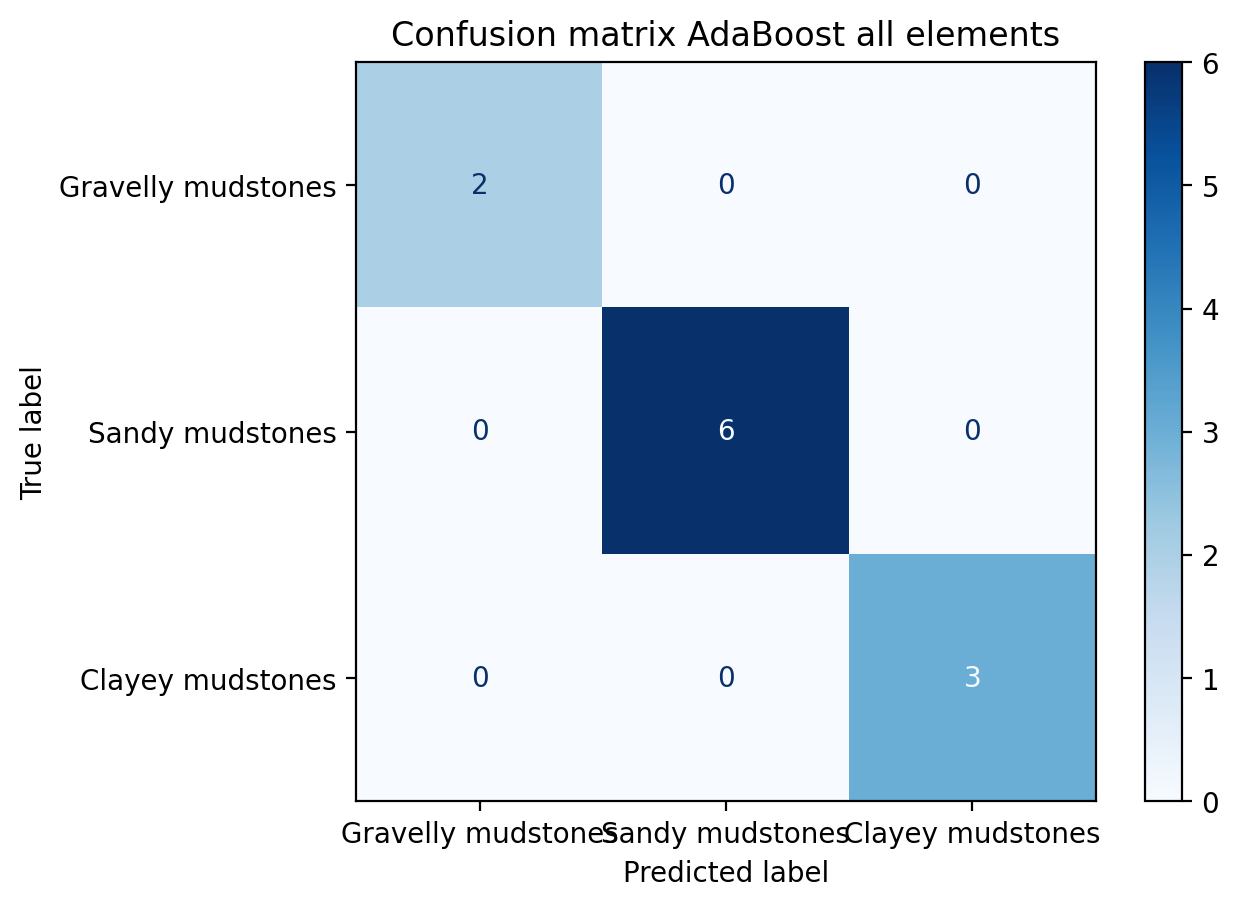

In [ ]:
title_options = [
    ("Confusion matrix AdaBoost all elements", None)
]
for title, normalize in title_options:
    display = ConfusionMatrixDisplay.from_estimator(
        adb,
        x_test,
        y_test,
        display_labels=['Gravelly mudstones', 'Sandy mudstones', 'Clayey mudstones'] ,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    display.ax_.set_title(title)

plt.show()

#### AdaBoost ROC

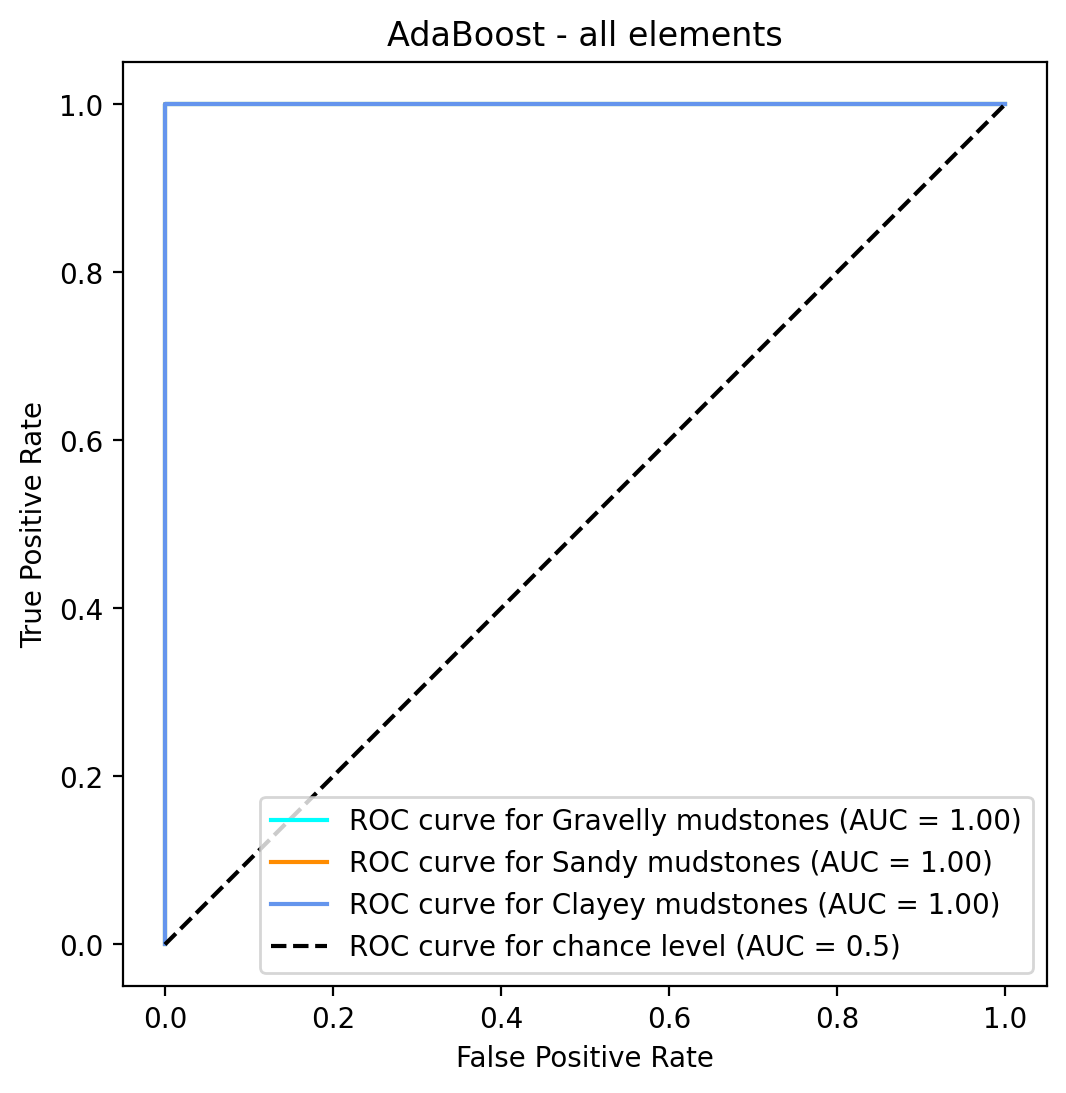

In [ ]:
adb_roc = plot_roc_multiclass(y_train, y_test, adb.predict_proba(x_test), ['Gravelly mudstones', 'Sandy mudstones', 'Clayey mudstones'], "AdaBoost - all elements")
adb_roc

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, target_names=['Gravelly mudstones', 'Sandy mudstones', 'Clayey mudstones'])
print(report)

                    precision    recall  f1-score   support

Gravelly mudstones       1.00      1.00      1.00         2
   Sandy mudstones       1.00      1.00      1.00         6
  Clayey mudstones       1.00      1.00      1.00         3

          accuracy                           1.00        11
         macro avg       1.00      1.00      1.00        11
      weighted avg       1.00      1.00      1.00        11



In [ ]:
from sklearn.metrics import roc_auc_score

# Generate class membership probabilities
y_preb_probs = adb.predict_proba(x_test)

roc_auc_score(y_test, y_preb_probs, average="weighted", multi_class="ovr")

1.0

In [ ]:
from sklearn.metrics import roc_auc_score

def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):

    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:

        #creating a list of all the classes except the current class
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [ ]:
roc_auc_dict = roc_auc_score_multiclass(y_test, y_pred)
roc_auc_dict

{1: 1.0, 2: 1.0, 3: 1.0}

In [ ]:
print(accuracy_score(y_test,y_pred)*100)

100.0


In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [ ]:
data = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
#data

### AdaBoost XAI

In [ ]:
# Fits the explainer
explainer = shap.Explainer(adb.predict, x_train)
# Calculates the SHAP values - It takes some time
shap_values = explainer(x_test)

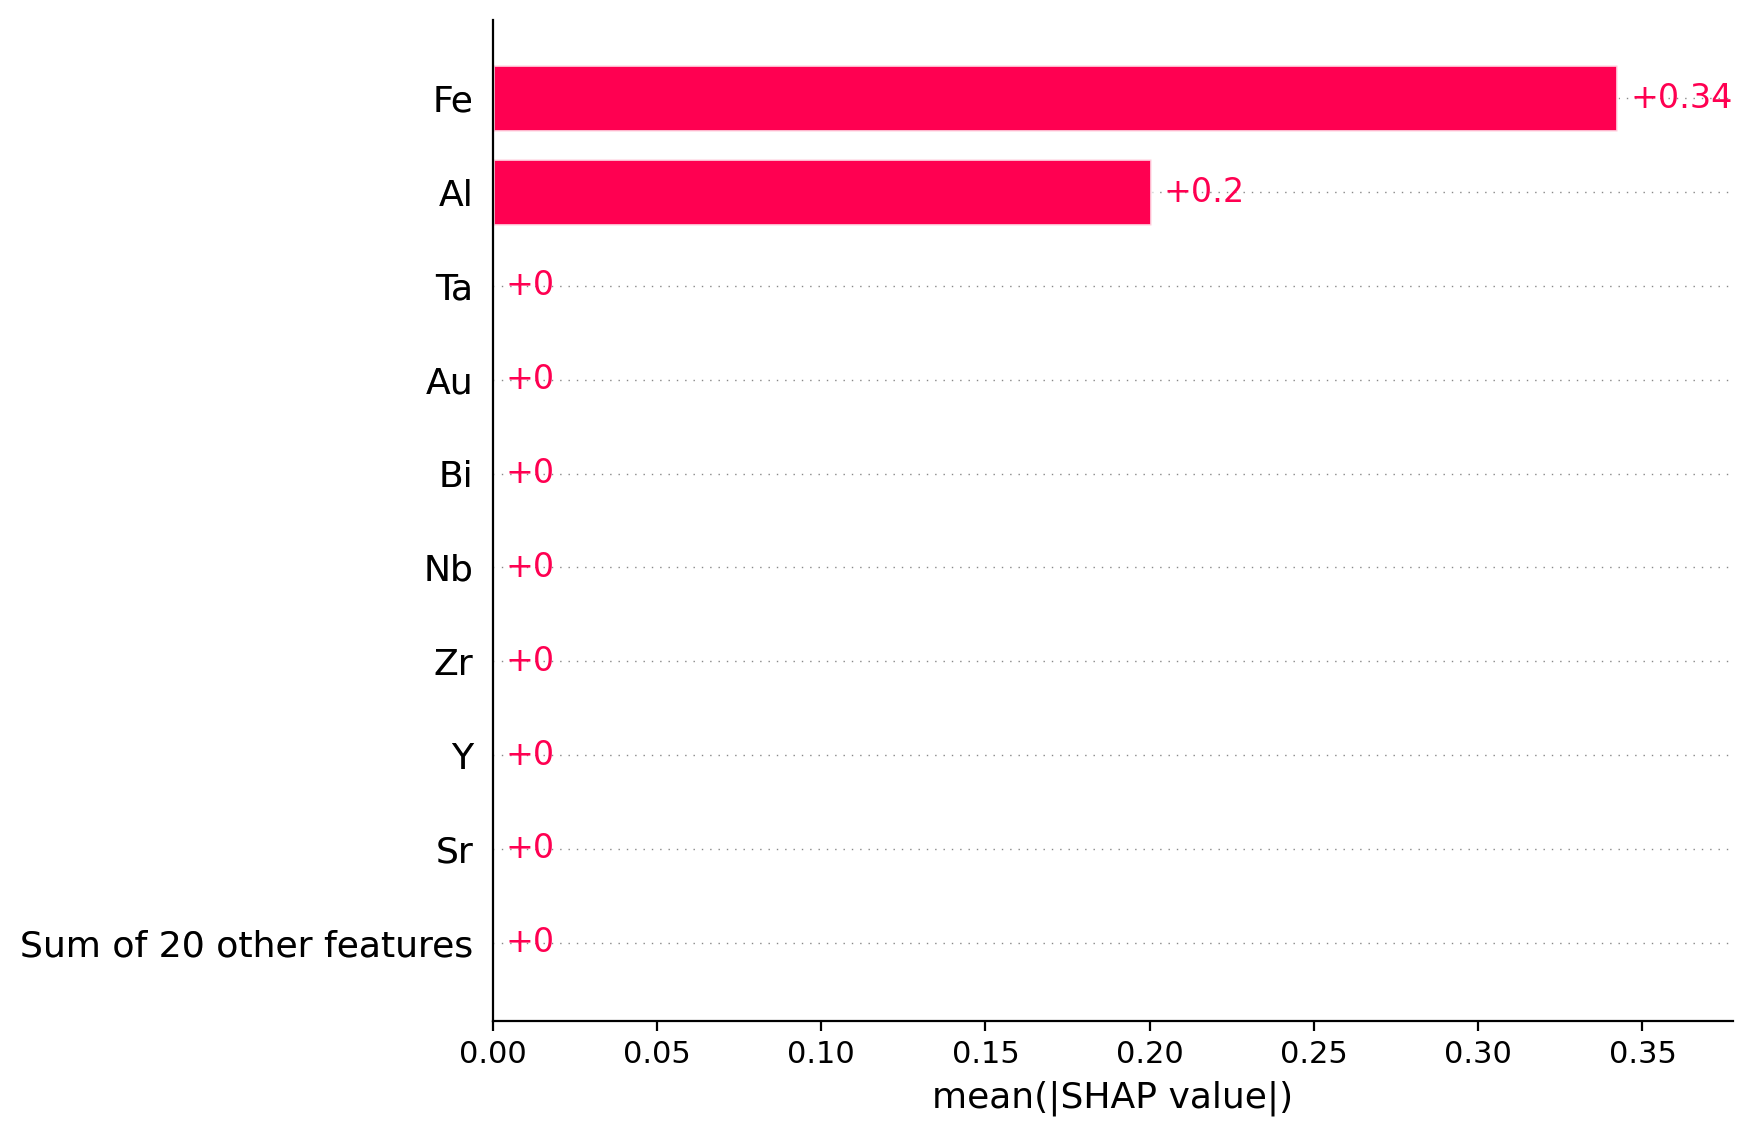

In [ ]:
shap.plots.bar(shap_values)

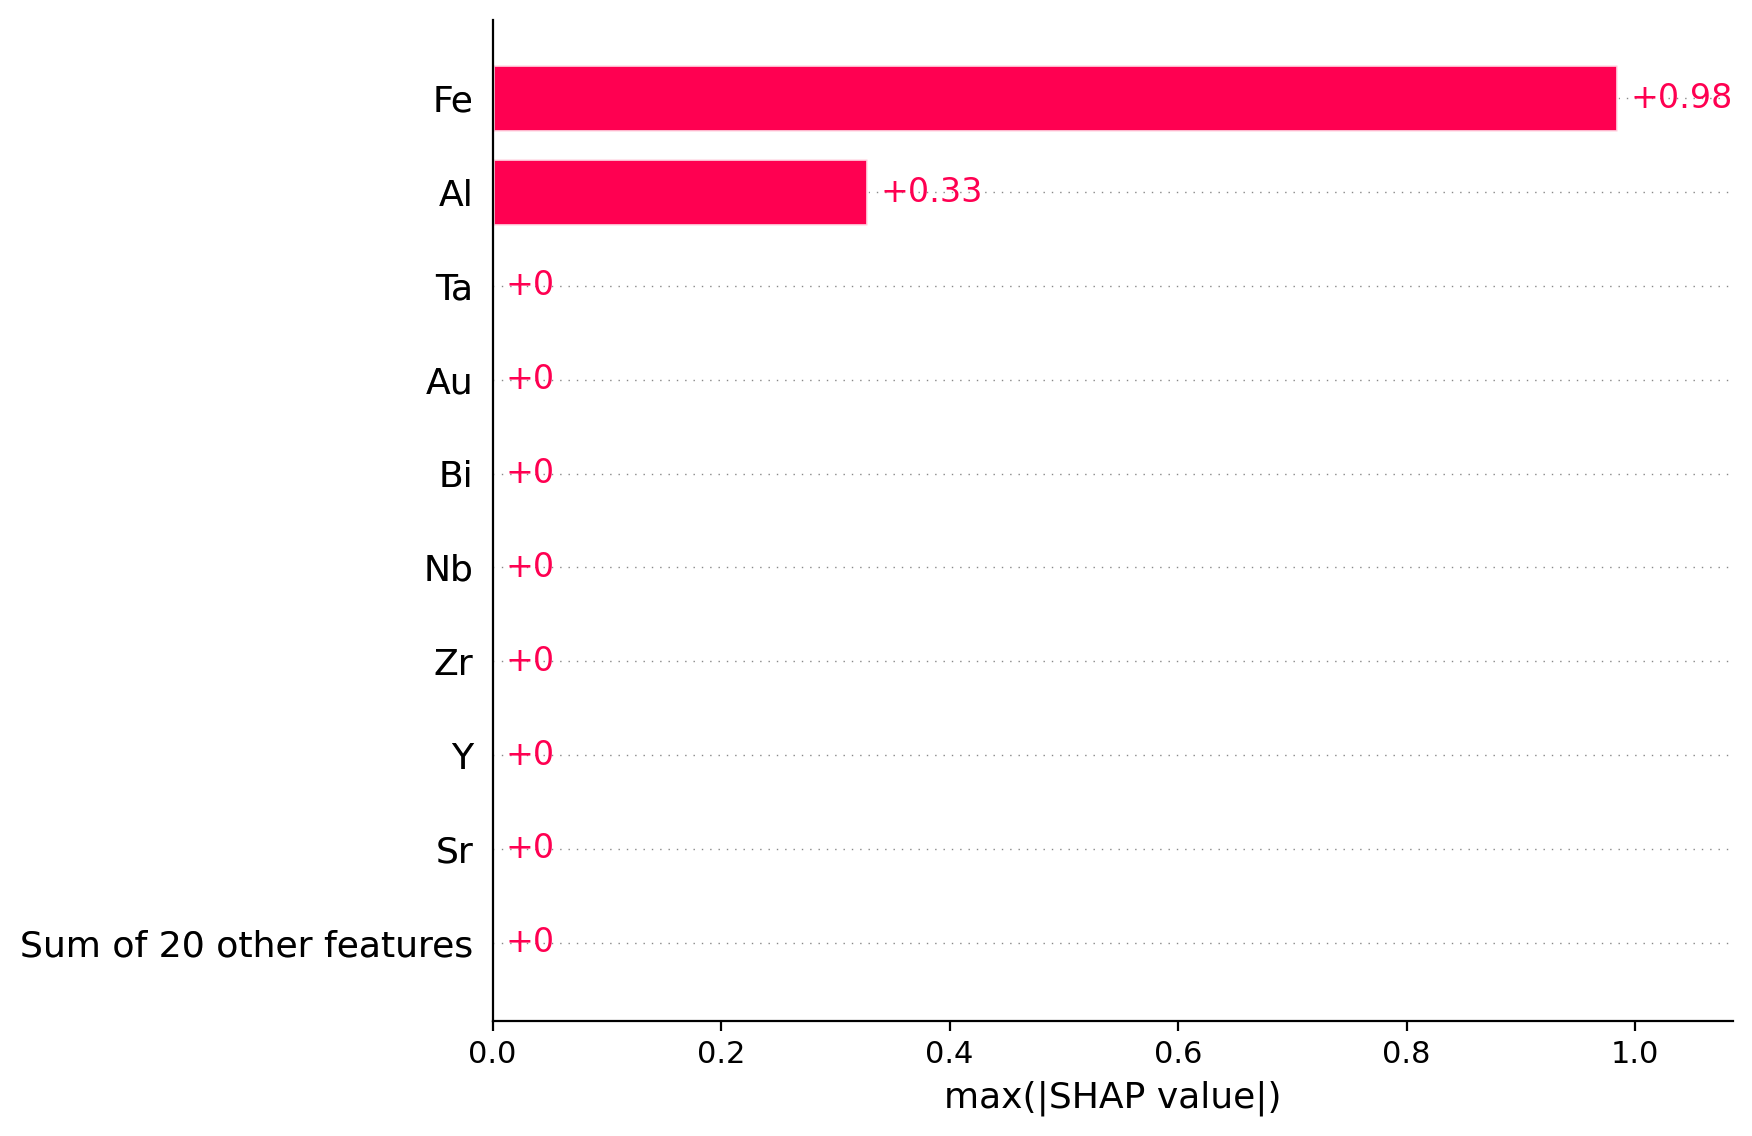

In [ ]:
shap.plots.bar(shap_values.abs.max(0))

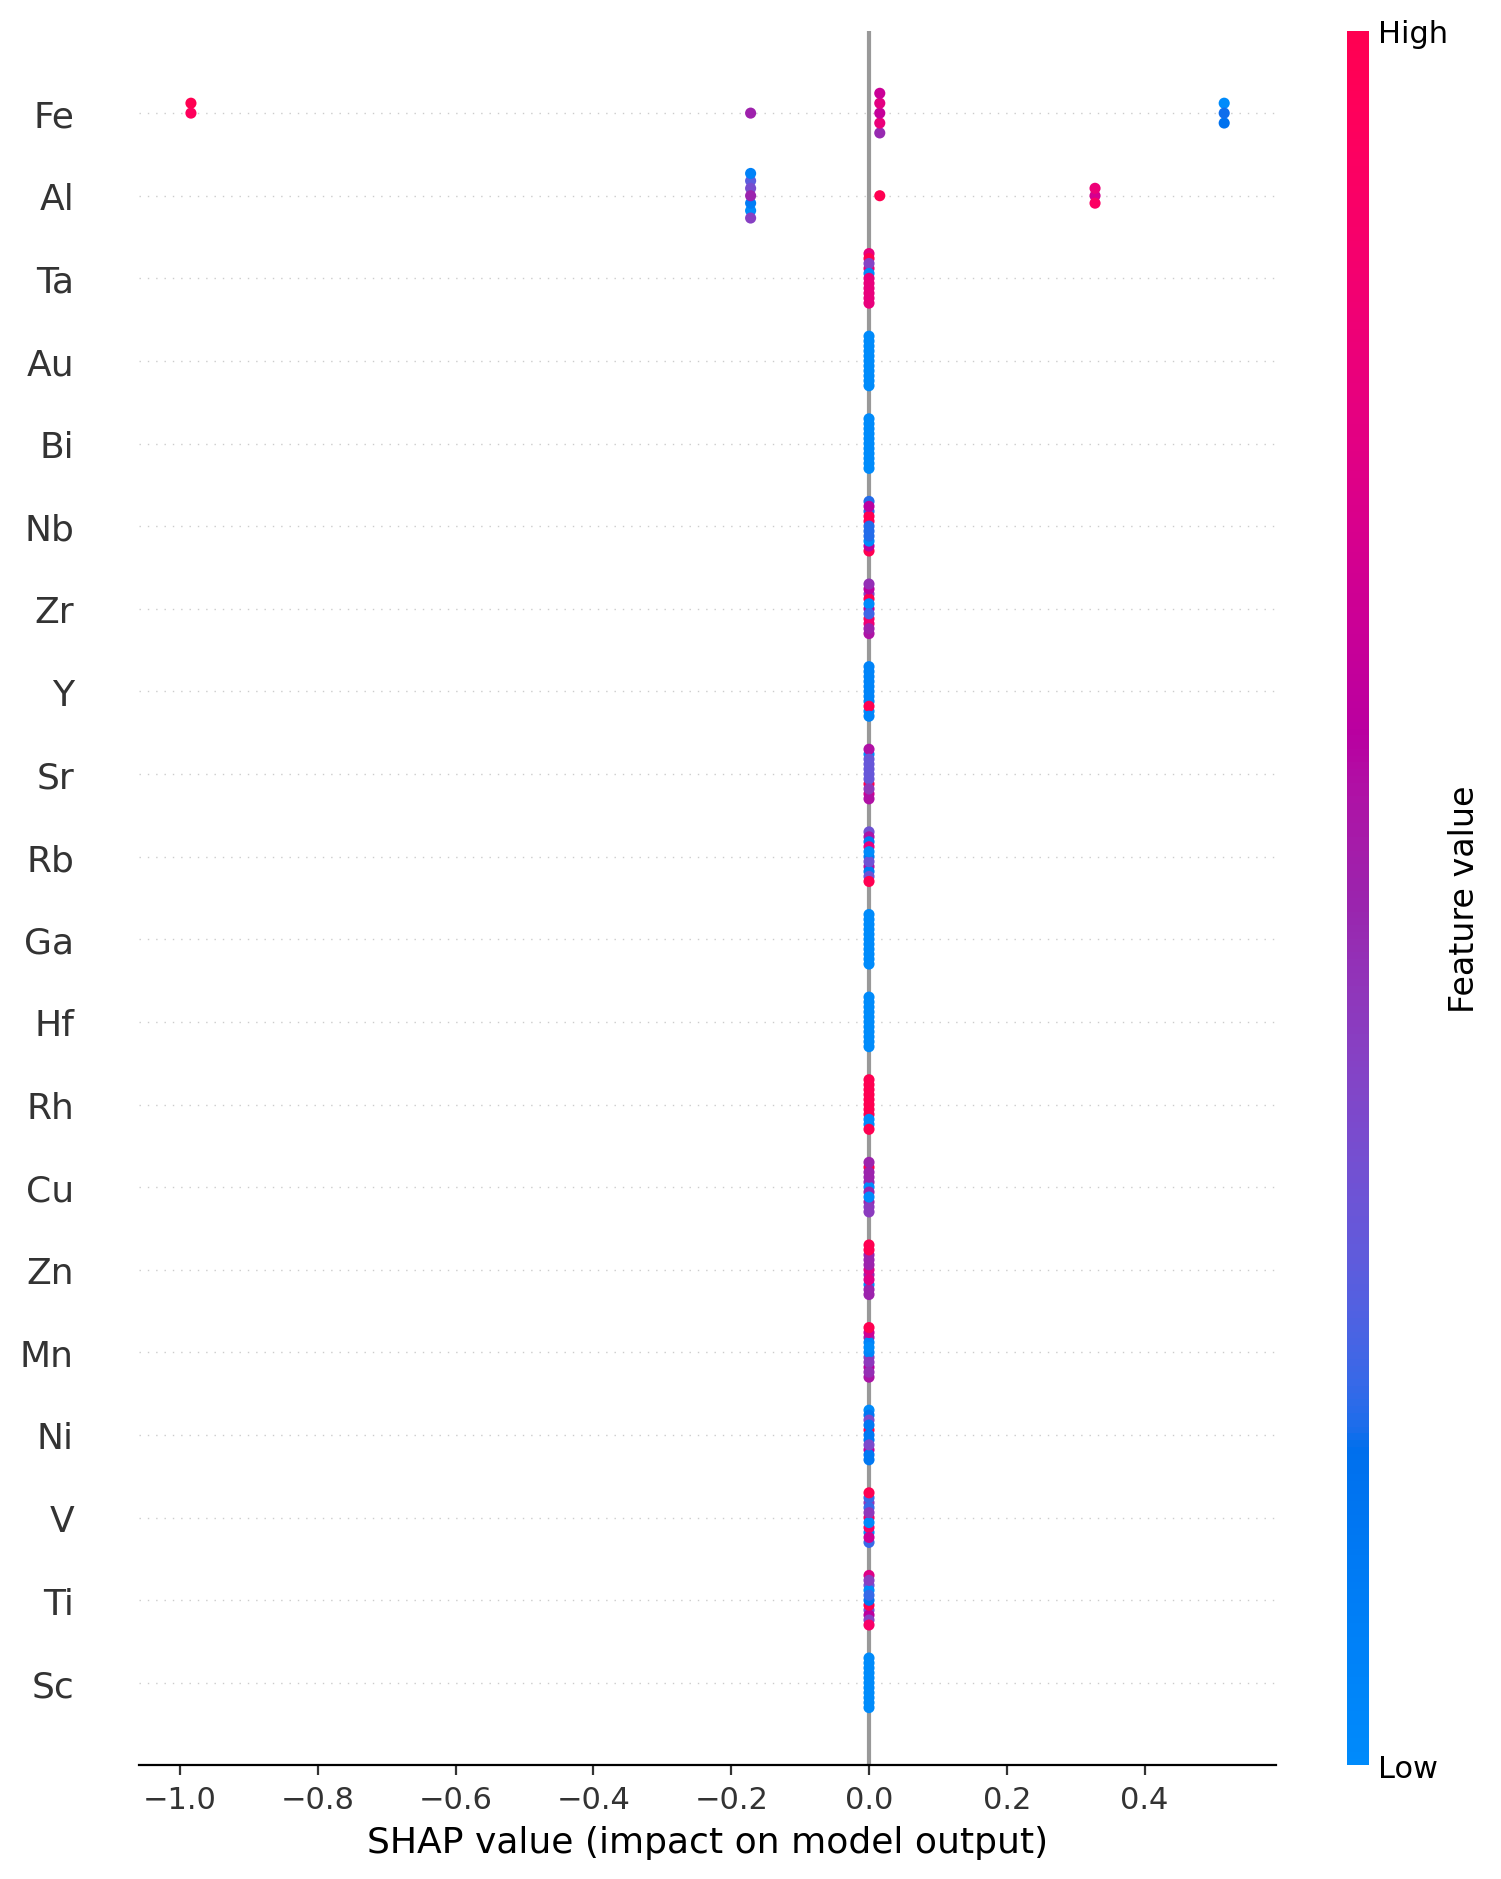

In [ ]:
shap.summary_plot(shap_values)

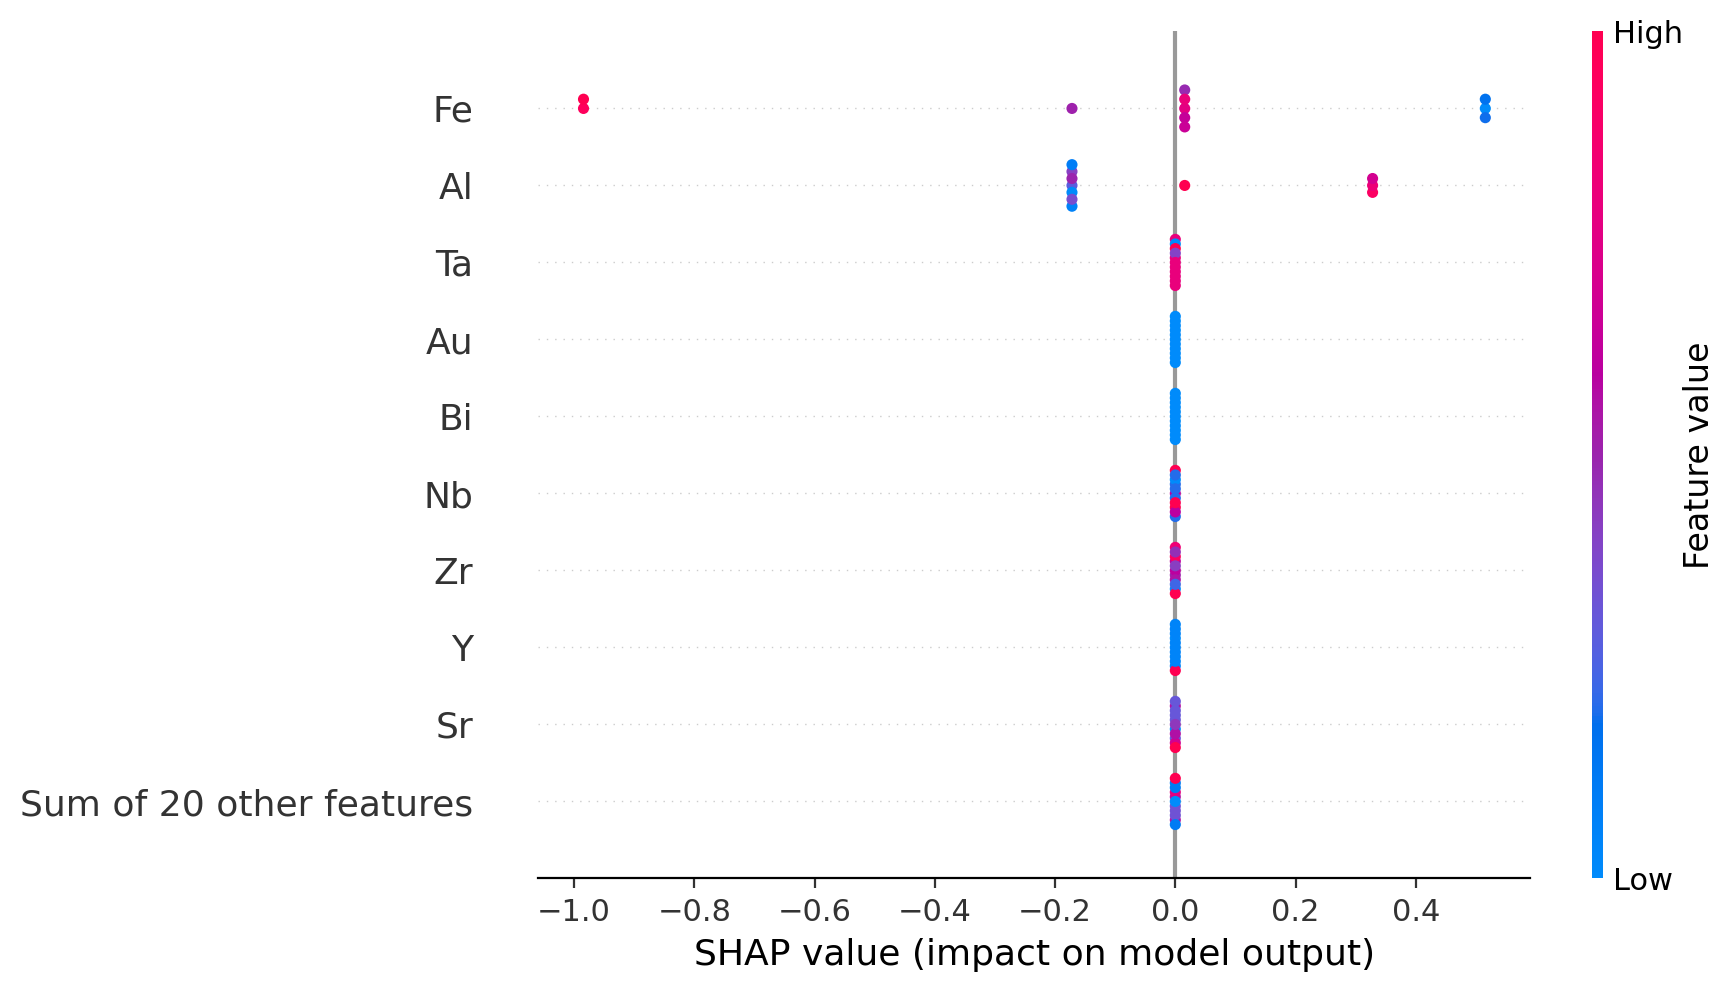

In [ ]:
# or
shap.plots.beeswarm(shap_values)

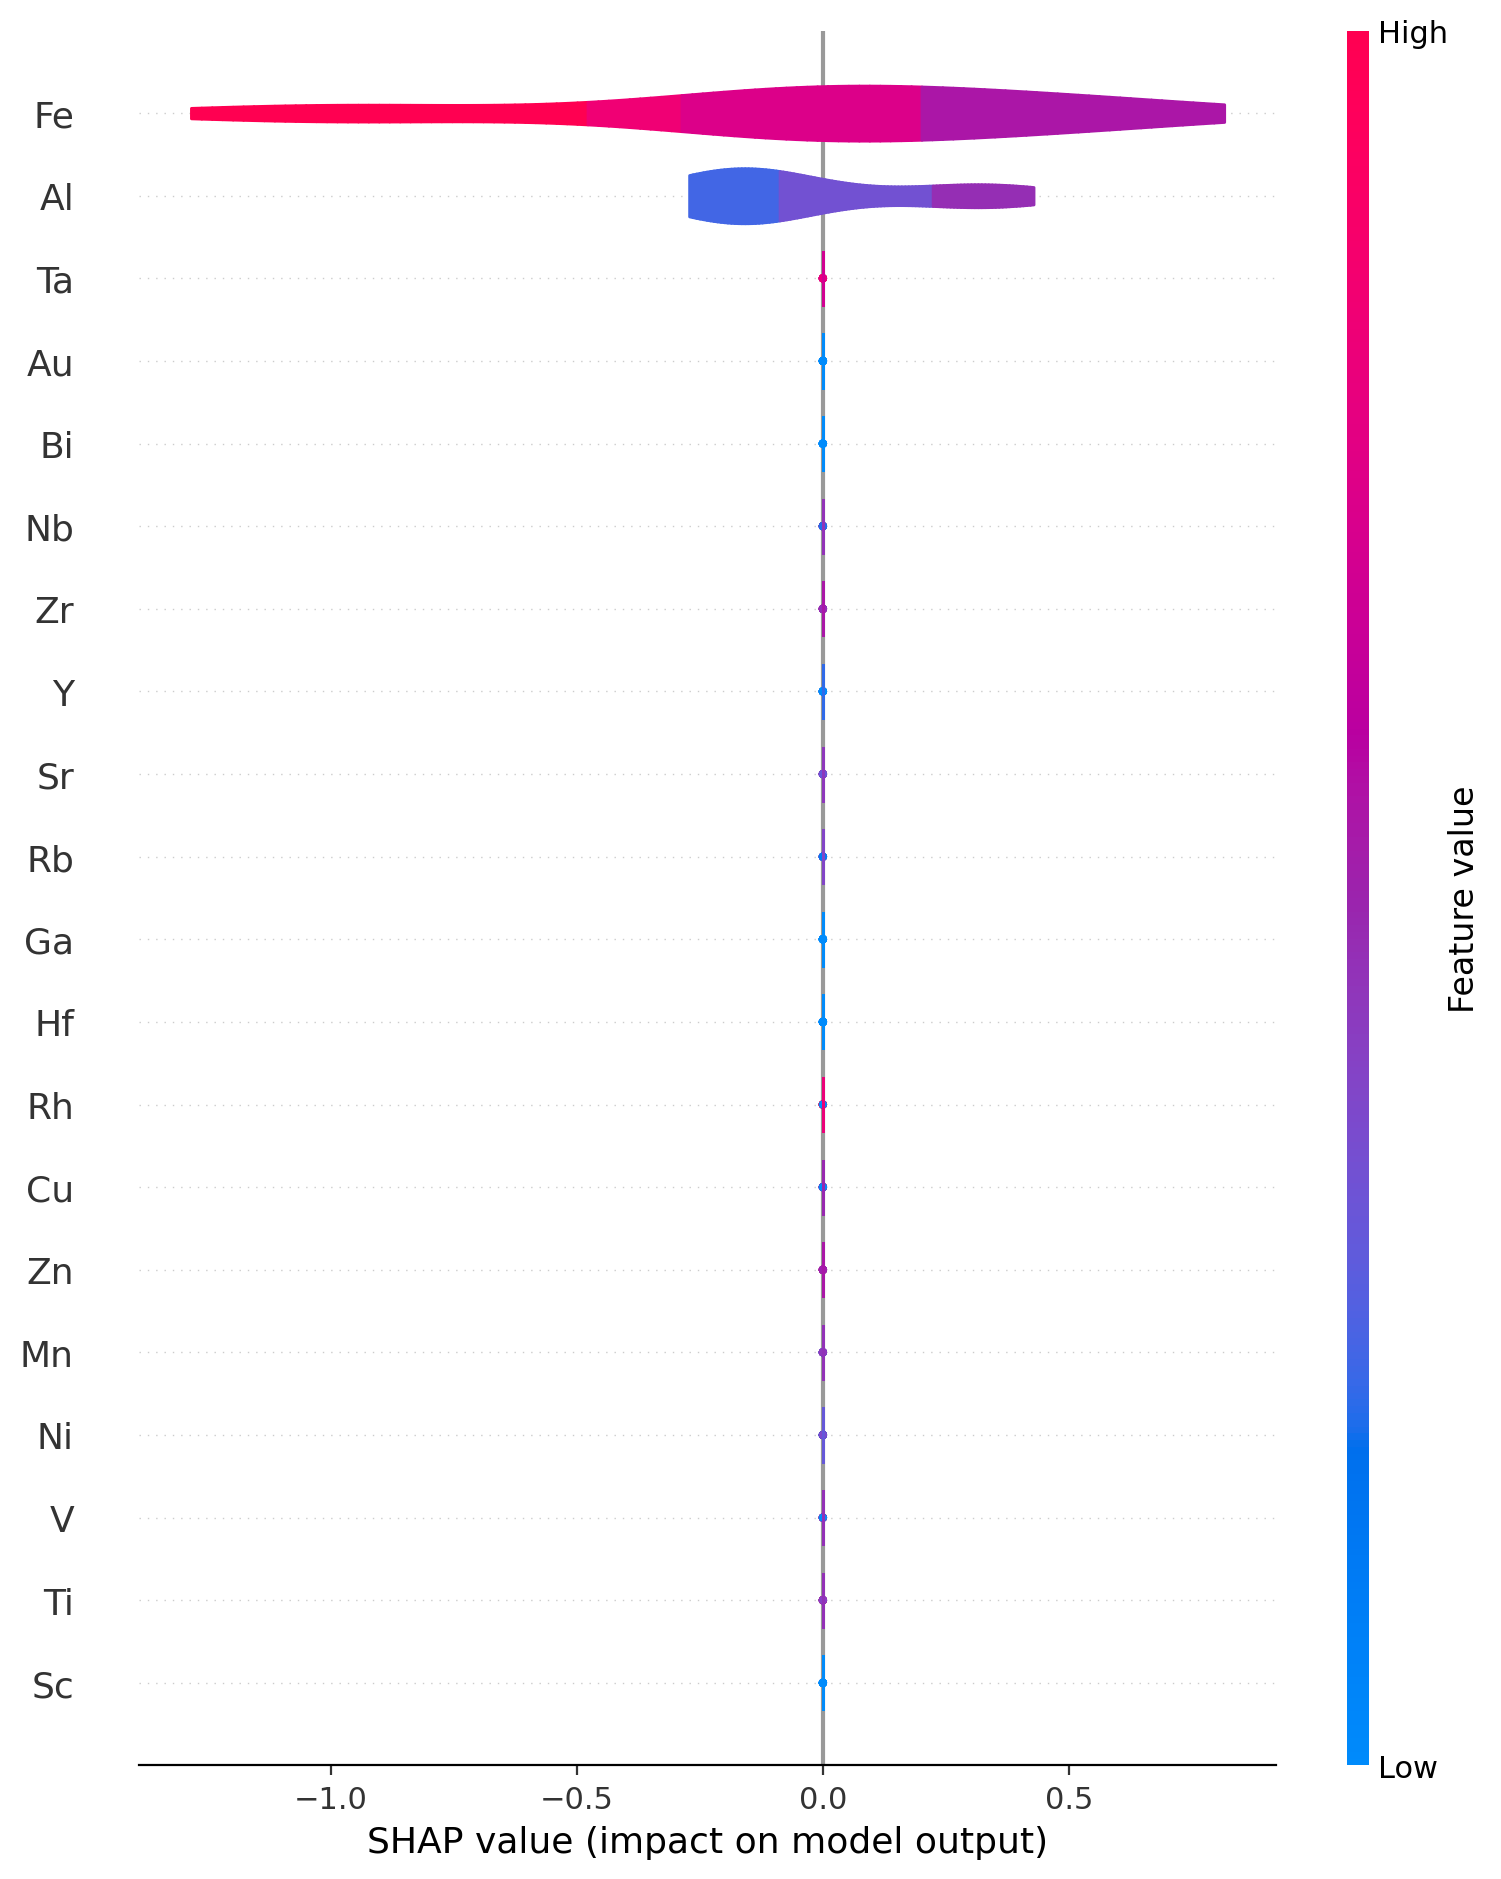

In [ ]:
shap.summary_plot(shap_values, plot_type='violin')

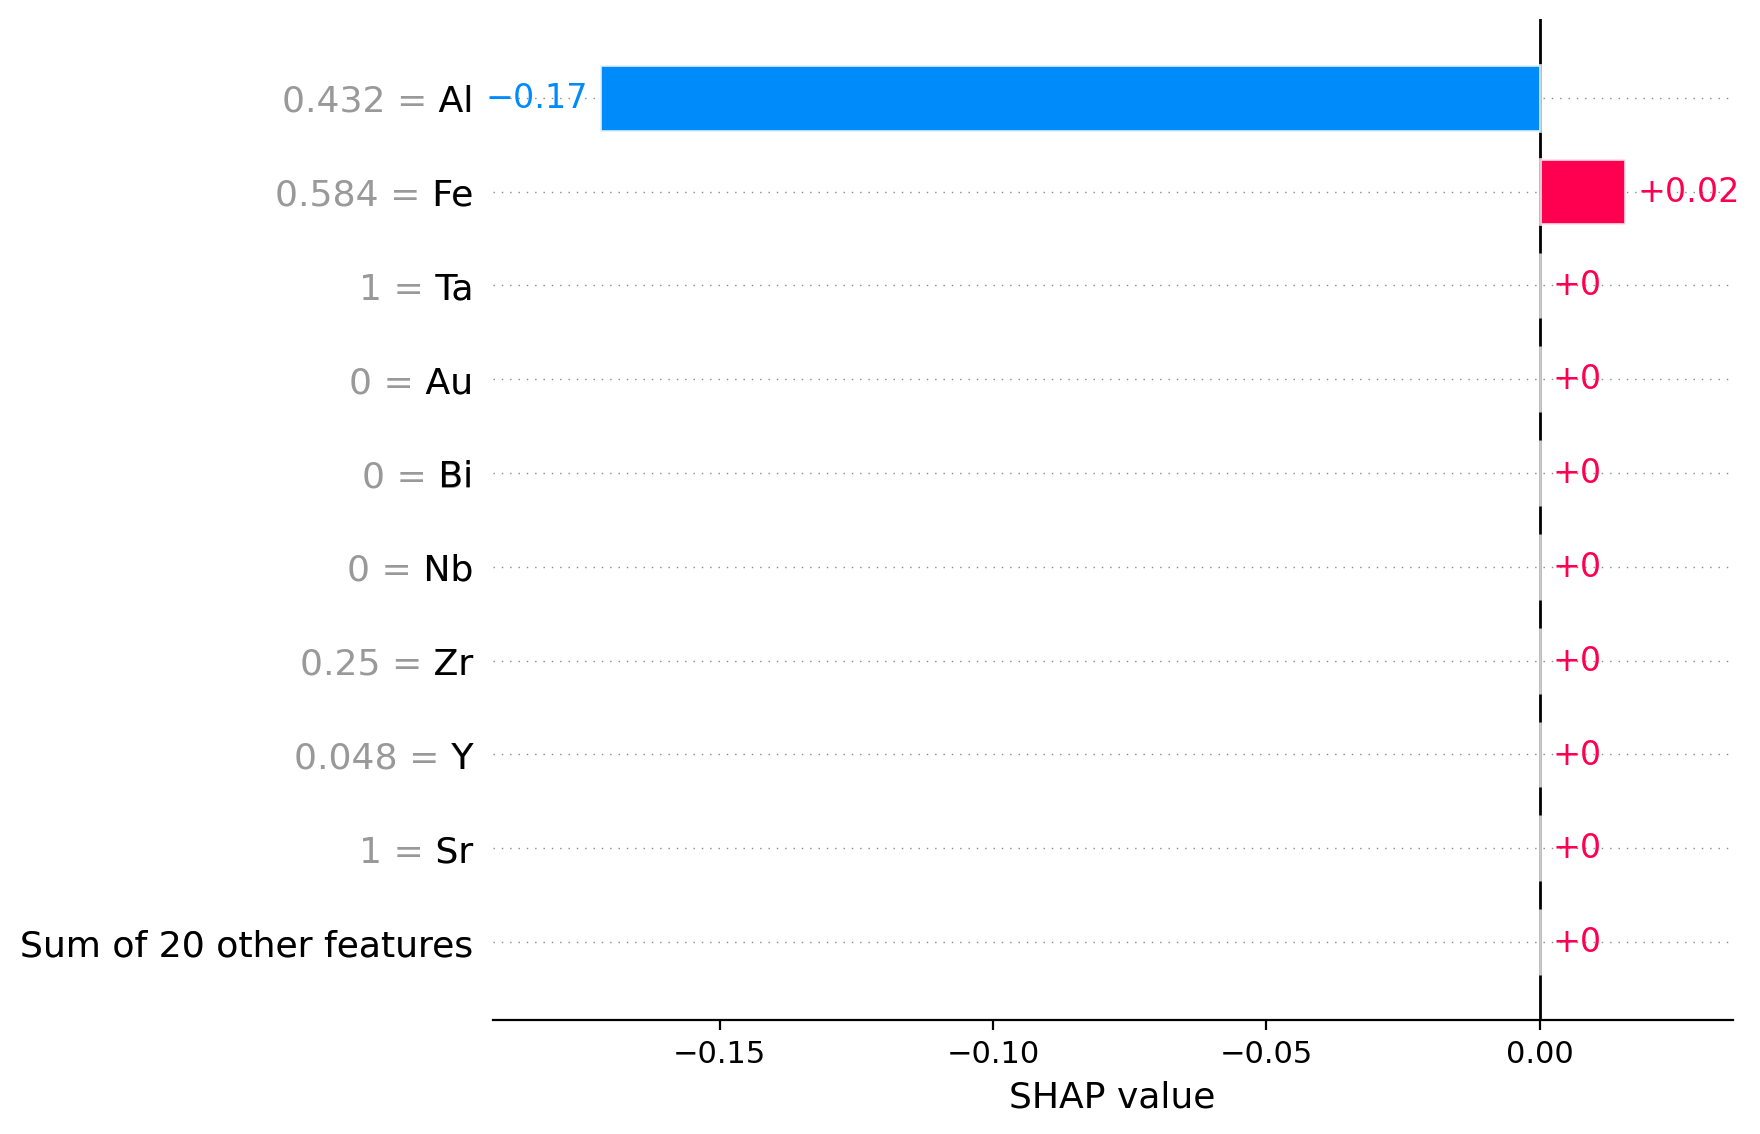

In [ ]:
#Local bar plot
shap.plots.bar(shap_values[8])

In [ ]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

# Write in a function
def shap_plot(j):
    explainerModel = shap.TreeExplainer(rfc)
    shap_values_Model = explainerModel.shap_values(x)
    p = shap.force_plot(explainerModel.expected_value[j], shap_values_Model[:,:,j], x)
    return(p)

In [ ]:
shap.initjs()
shap_plot(0)

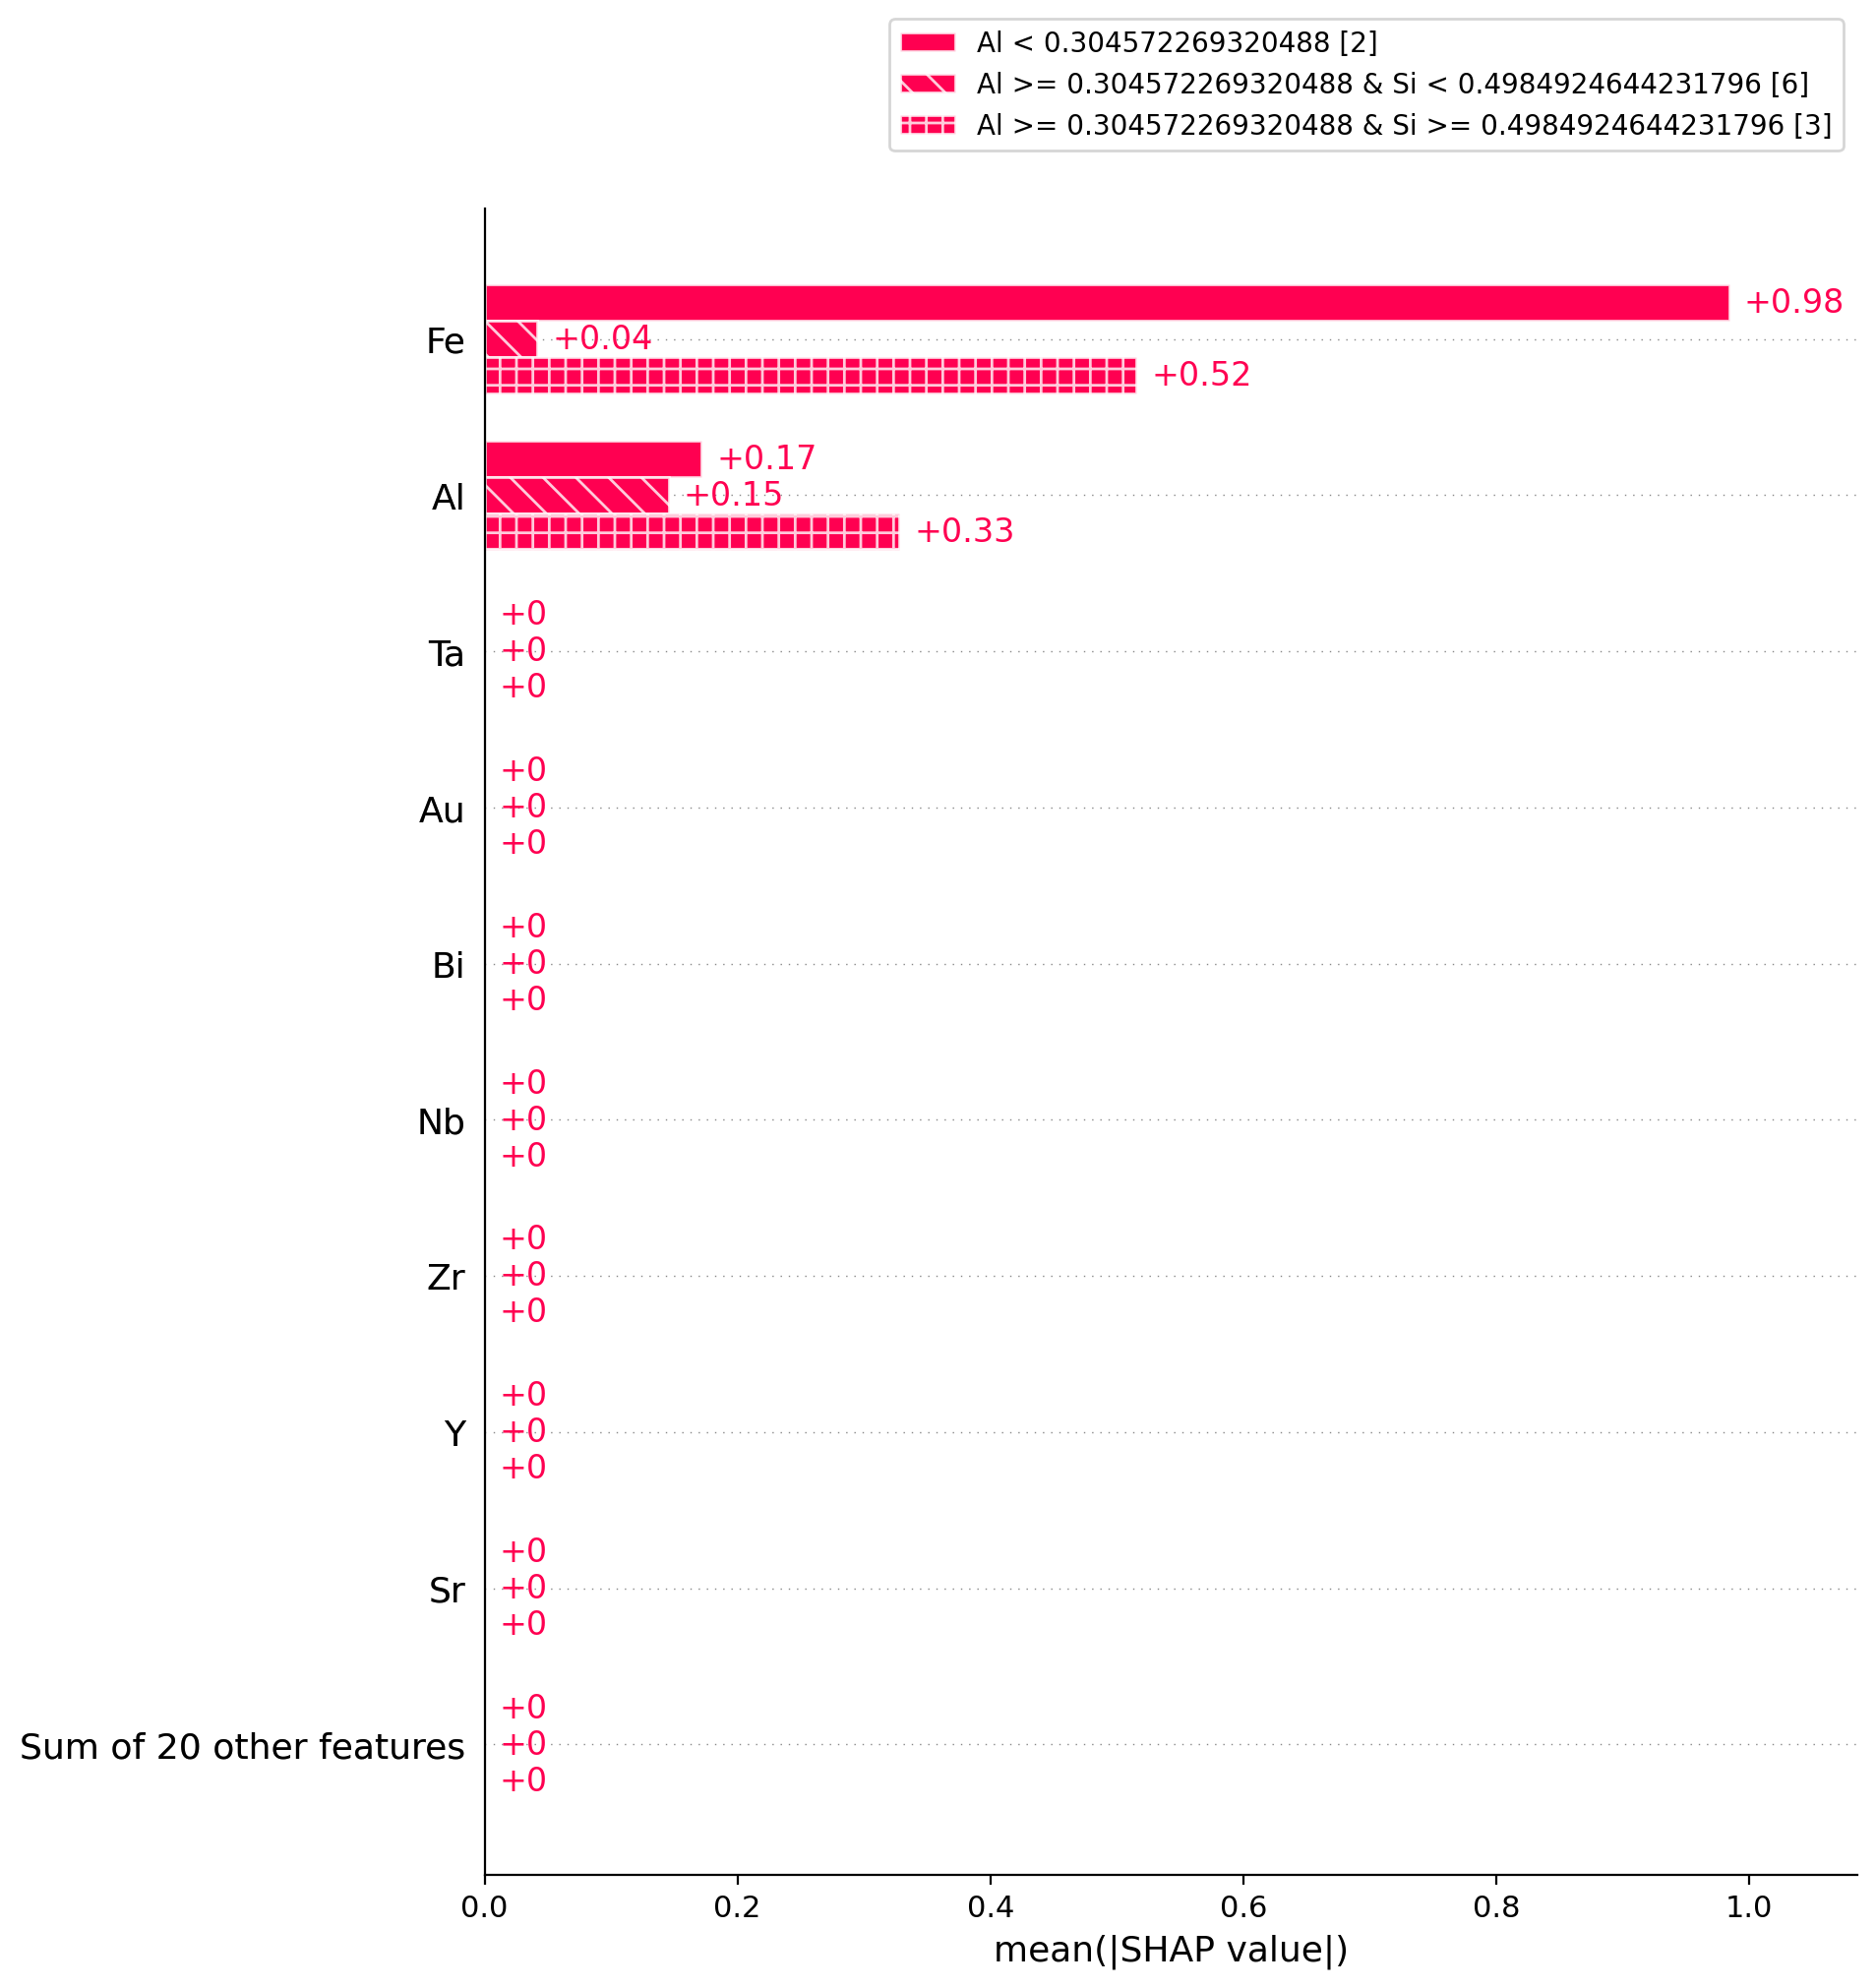

In [ ]:
#shap.plots.bar(shap_values.cohorts(3).abs.mean(0))
shap.plots.bar(shap_values.cohorts(3).abs.mean(0), show=False)
fig = plt.gcf() # gcf means "get current figure"
fig.set_figheight(11)
fig.set_figwidth(9)
#plt.rcParams['font.size'] = '12'
ax = plt.gca() #gca means "get current axes"
leg = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102))
plt.show()

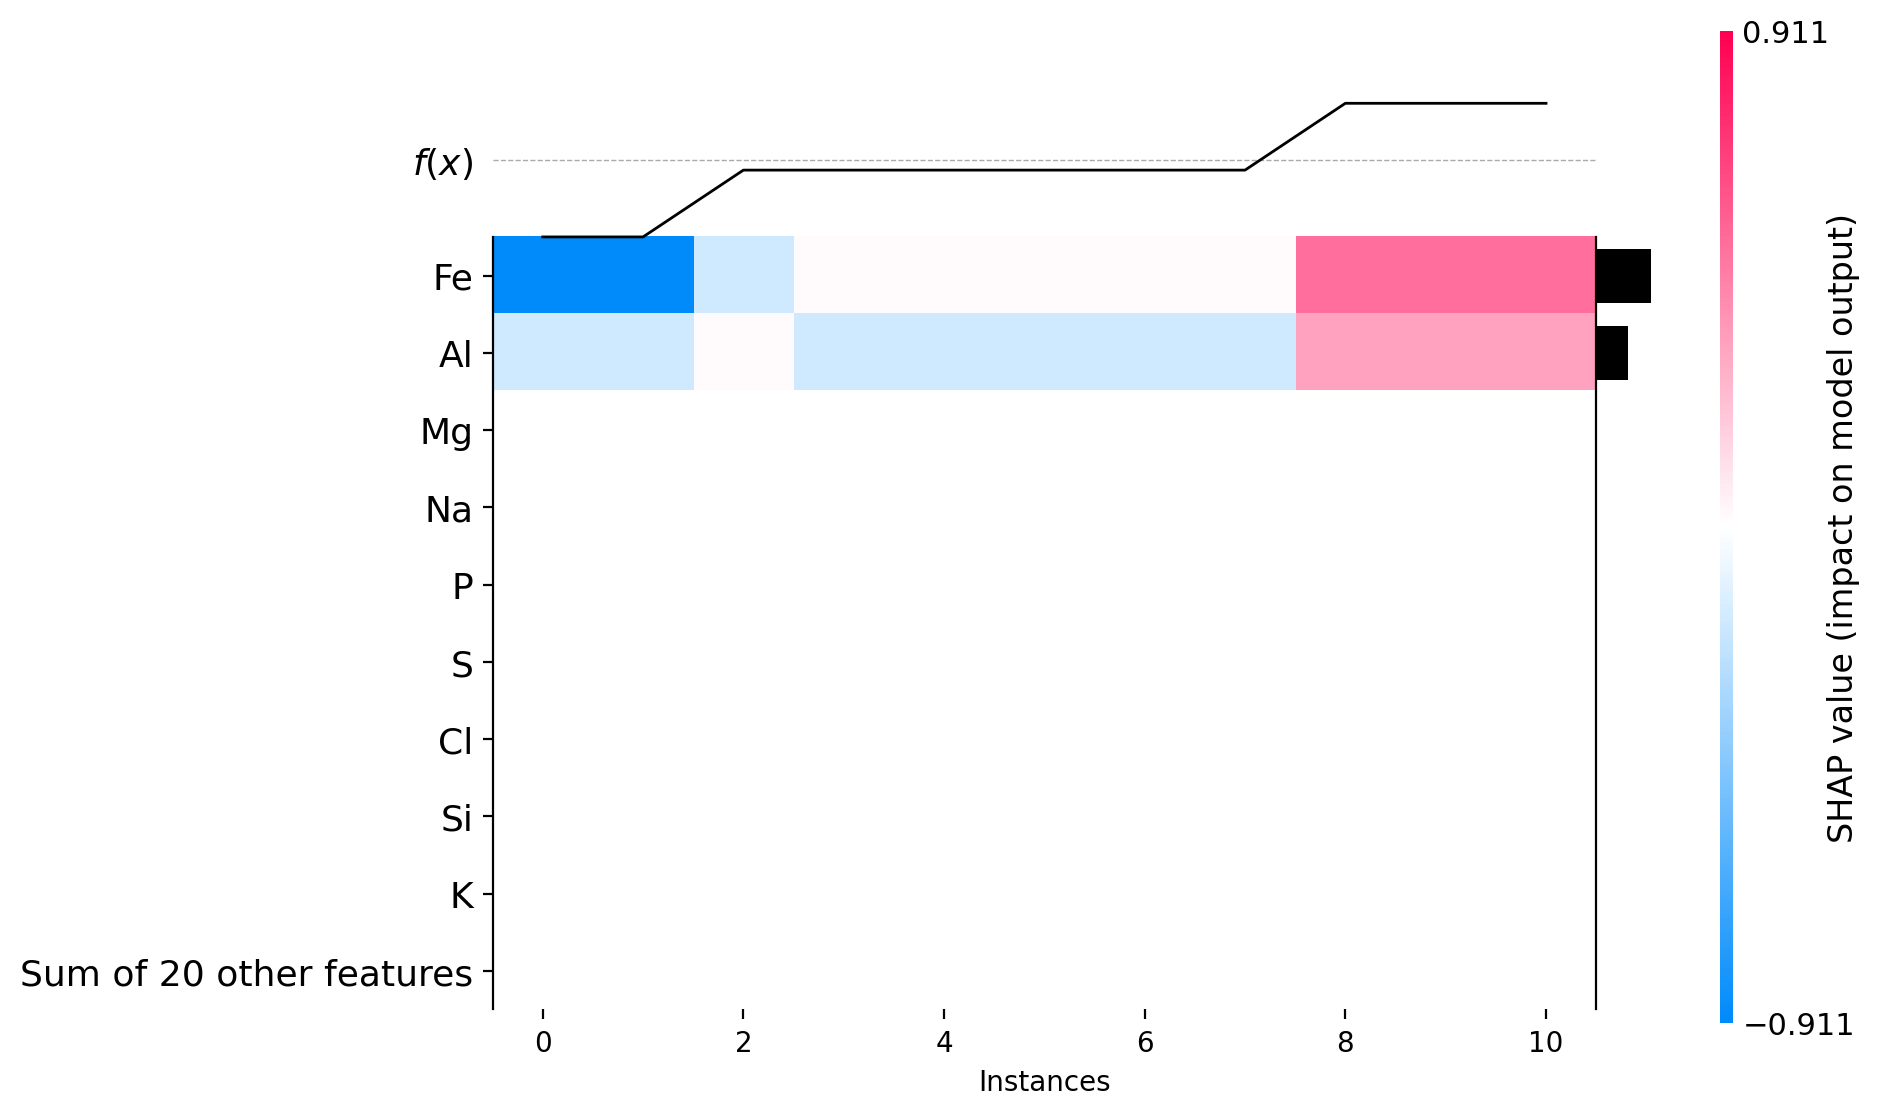

<Axes: xlabel='Instances'>

In [ ]:
shap.plots.heatmap(shap_values[0:])

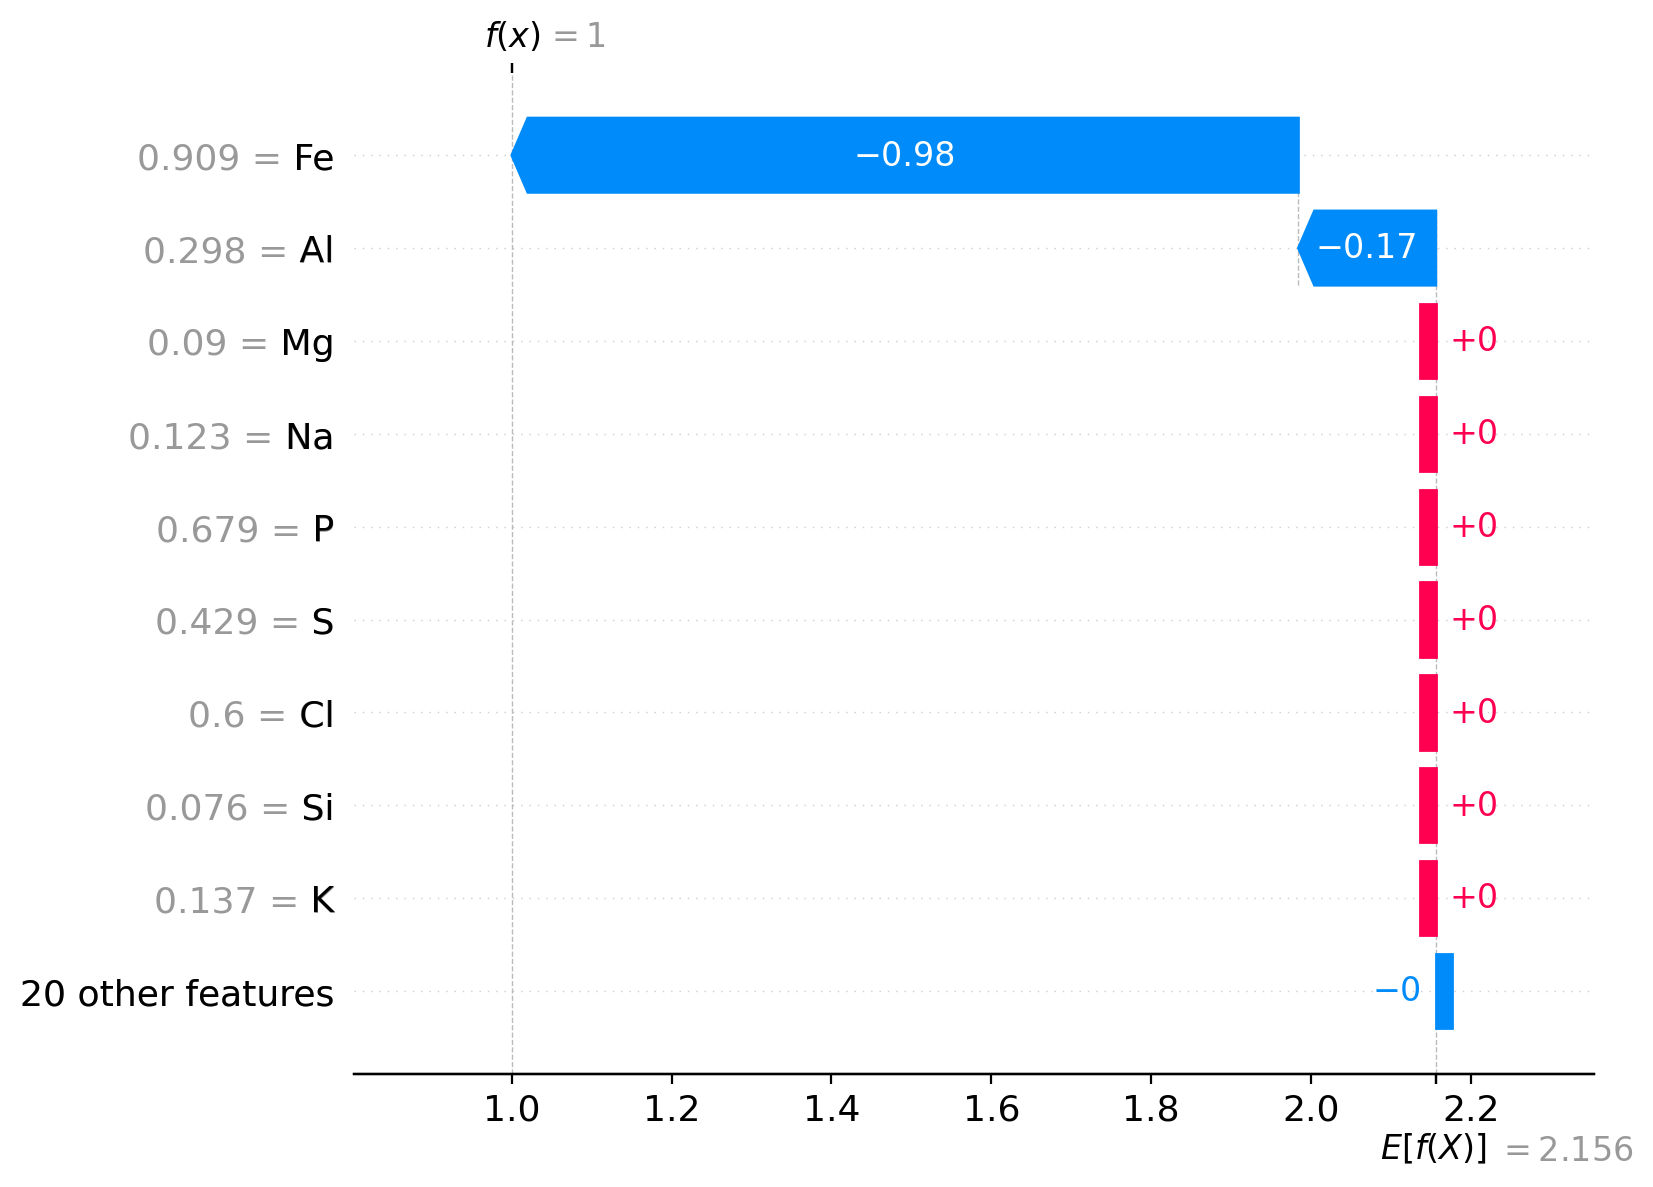

In [ ]:
#Waterfall plot
shap.plots.waterfall(shap_values[3])
#The waterfall plot has the same information, represented in a different manner.
#Here we can see how the sum of all the SHAP values equals the difference between
#the prediction f(x) and the expected value E[f(x)].

In [ ]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(rfc)
multi_shap_values = explainer.shap_values(x)

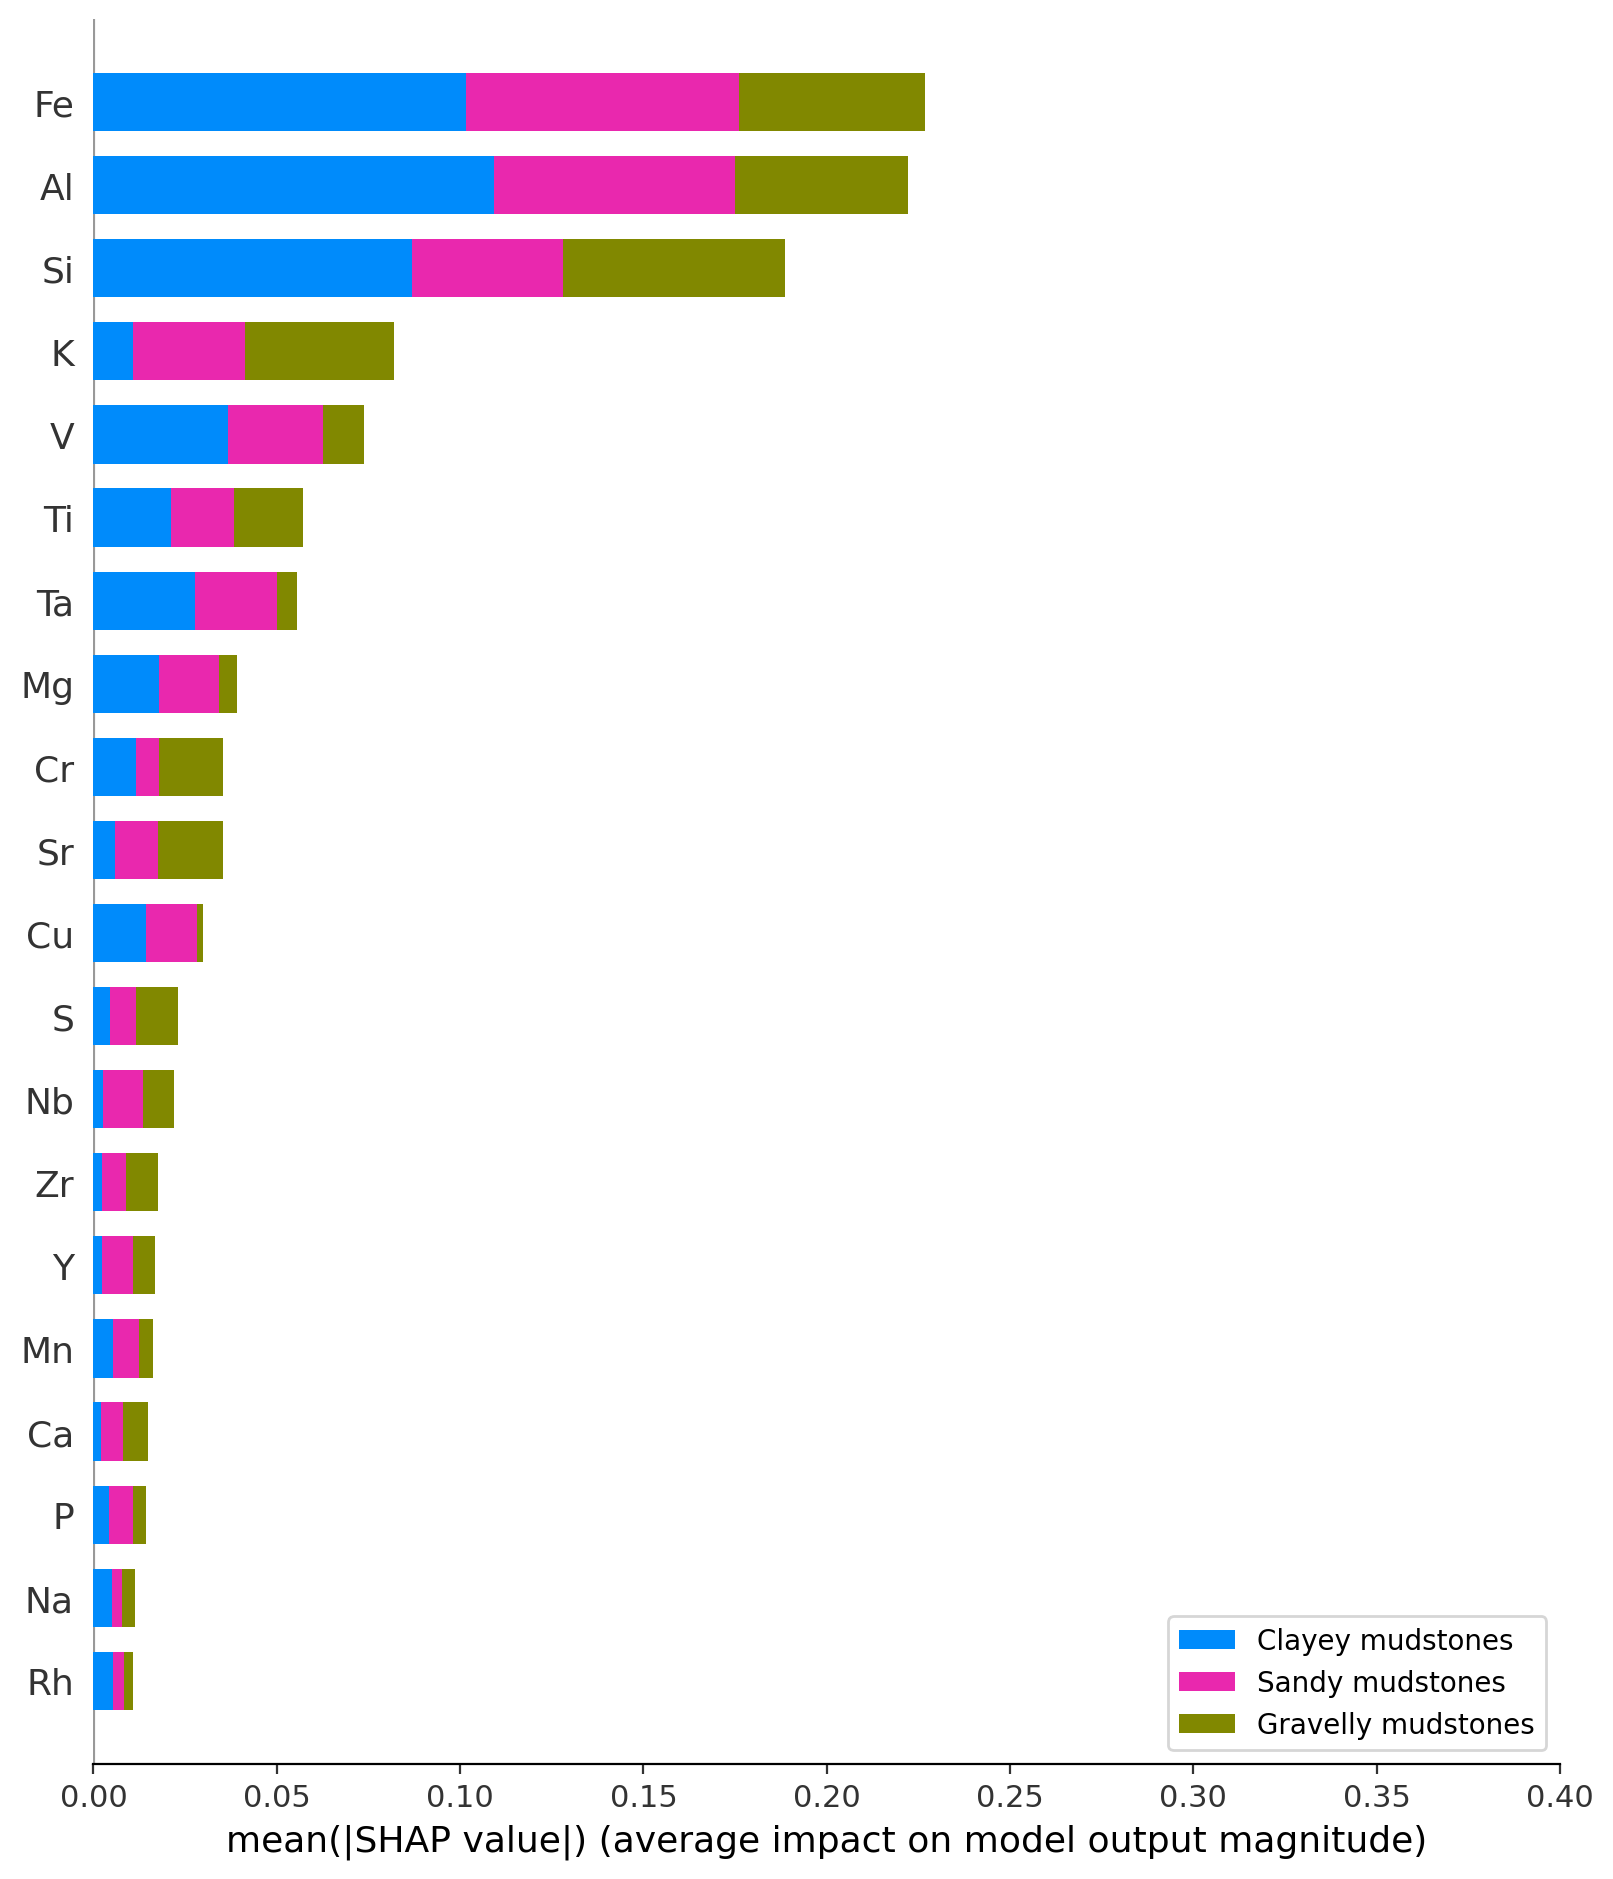

In [ ]:
shap.summary_plot(multi_shap_values, x_test, plot_type="bar",class_names=['Gravelly mudstones', 'Sandy mudstones', 'Clayey mudstones'], show=False)

ax = plt.gca()

# You can change the min and max value of xaxis by changing the arguments of:
ax.set_xlim(0, 0.4)
ax.legend(loc='lower right')
plt.show()

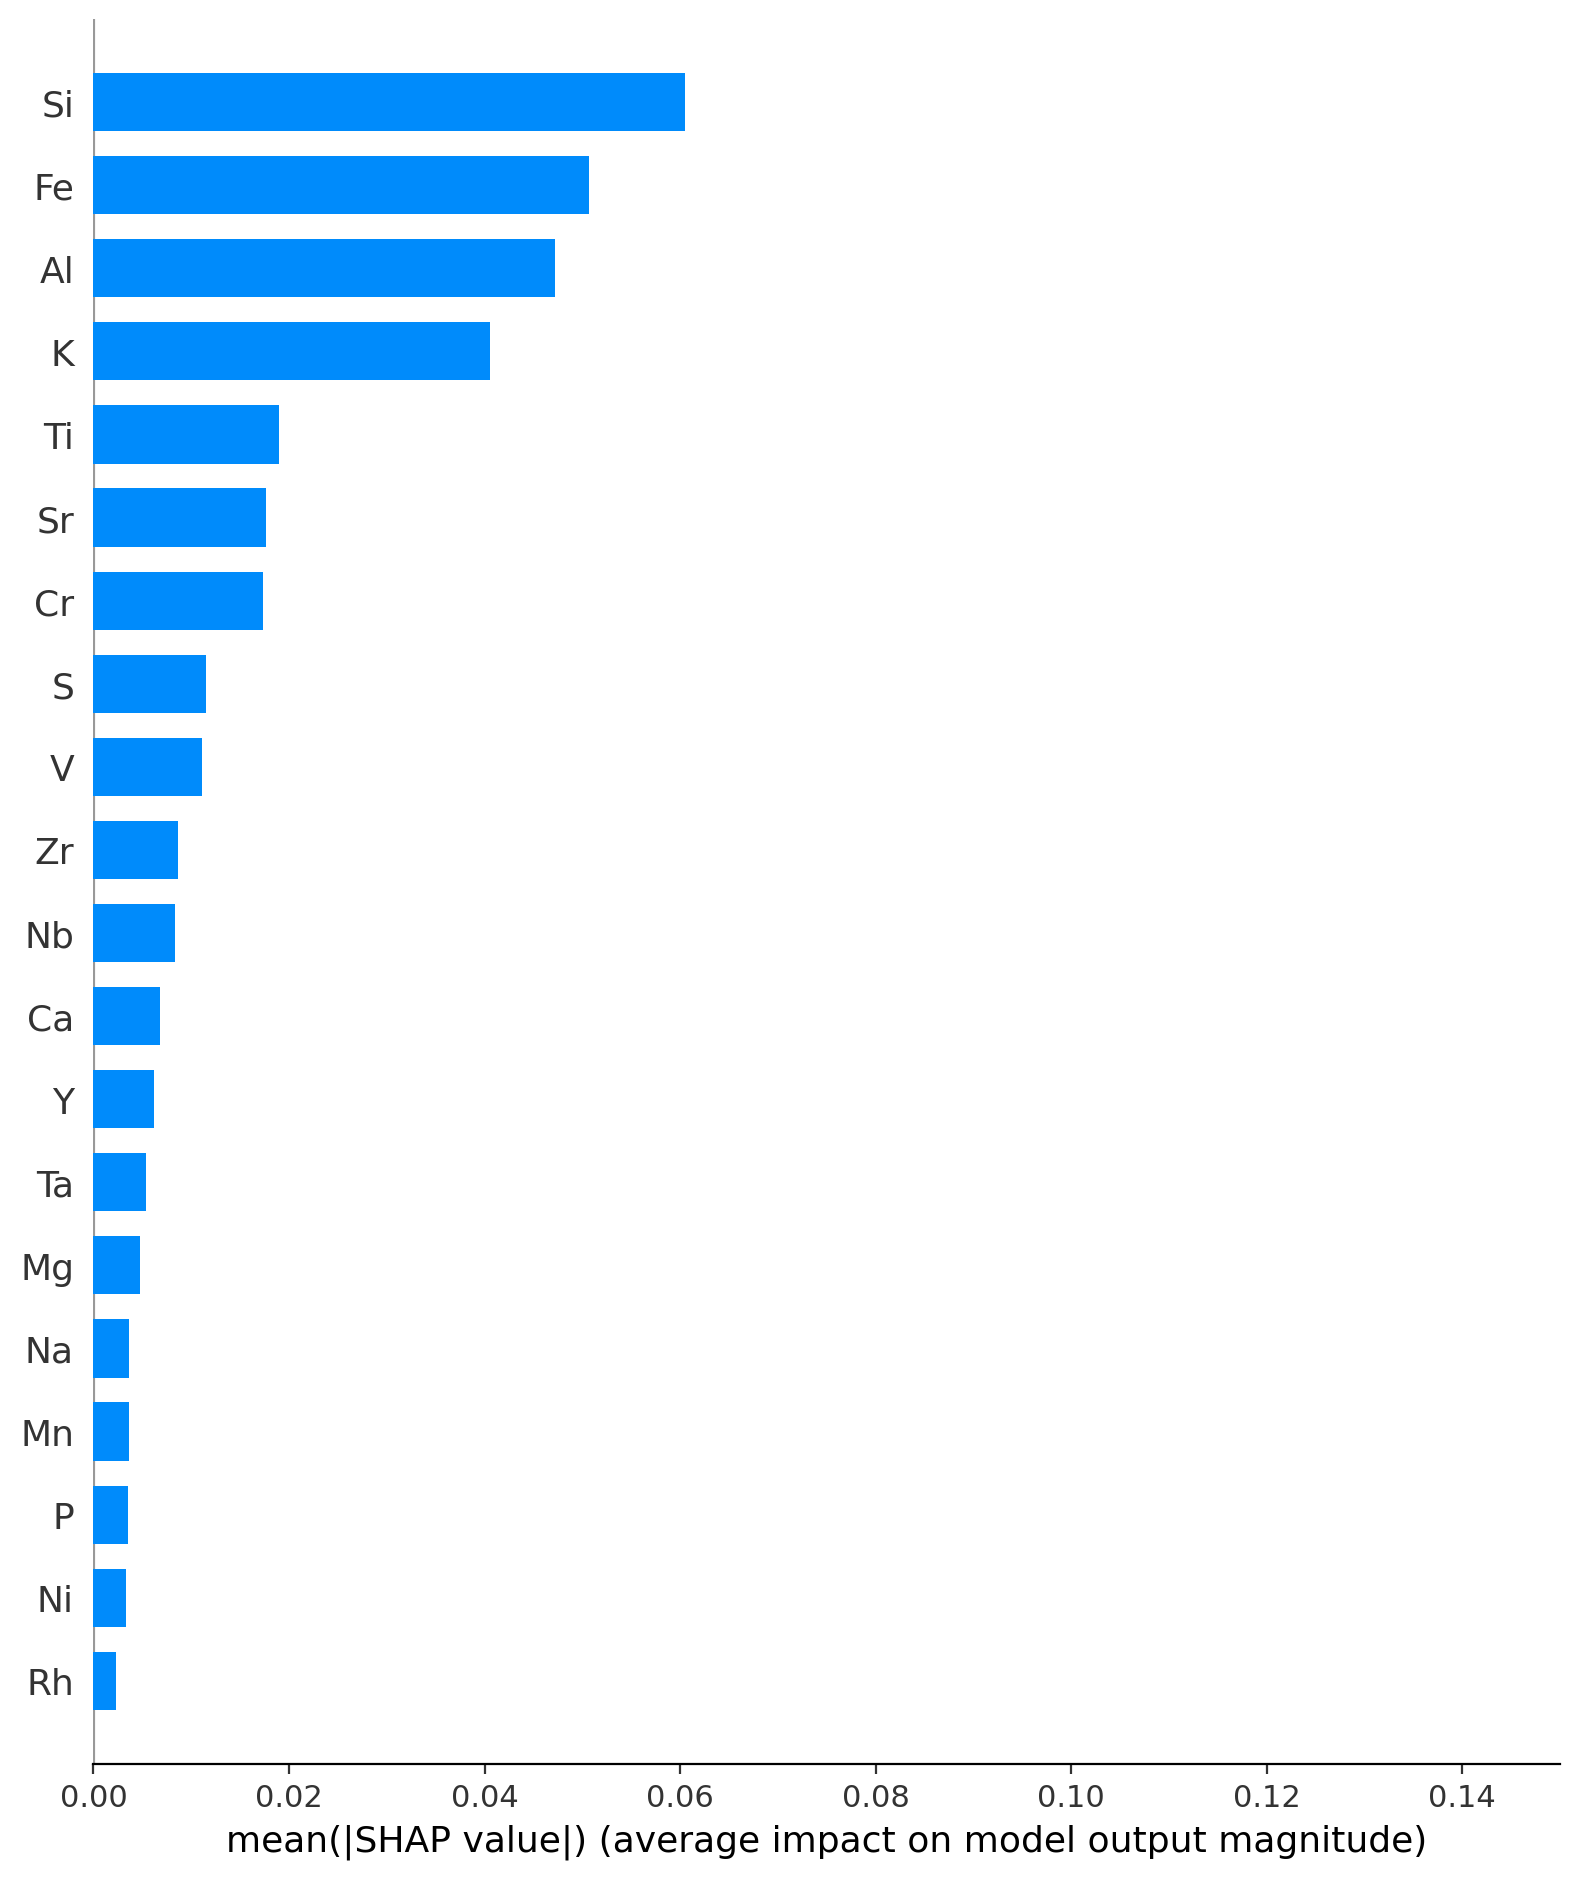

In [ ]:
shap.summary_plot(multi_shap_values[:,:,0], x_test, plot_type="bar",class_names=['Silts', 'Clayey silts', 'Silty Clays'], show=False)
ax = plt.gca()
ax.set_xlim(0, 0.15)
plt.show()

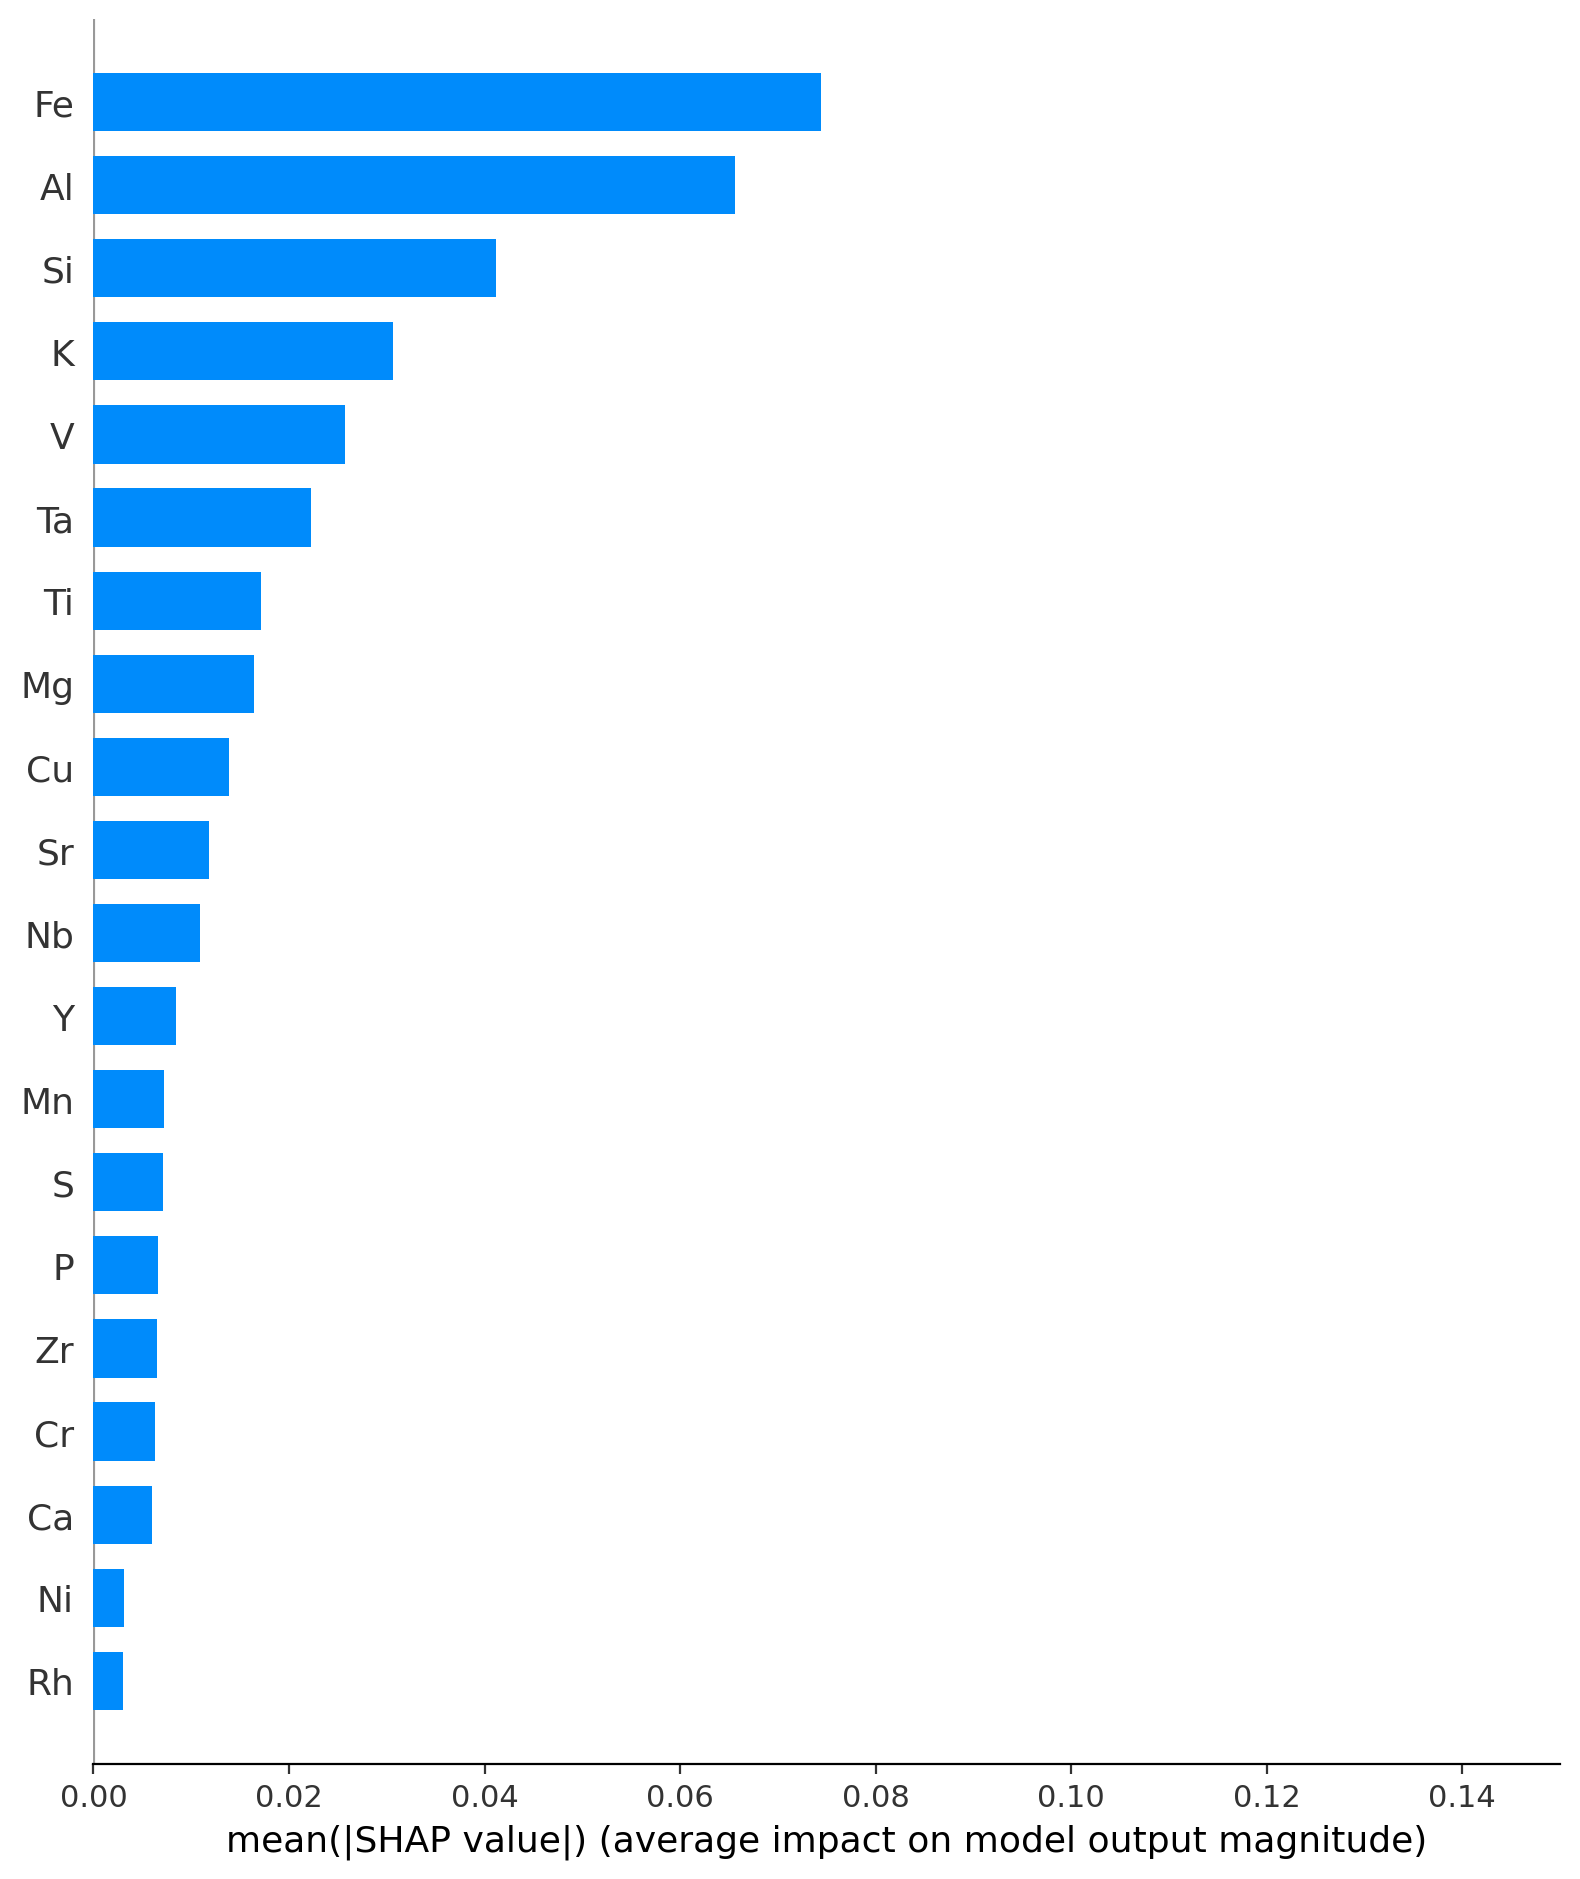

In [ ]:
shap.summary_plot(multi_shap_values[:,:,1], x_test, plot_type="bar",class_names=['Gravelly mudstones', 'Sandy mudstones', 'Clayey mudstones'], show=False)
ax = plt.gca()
ax.set_xlim(0, 0.15)
plt.show()

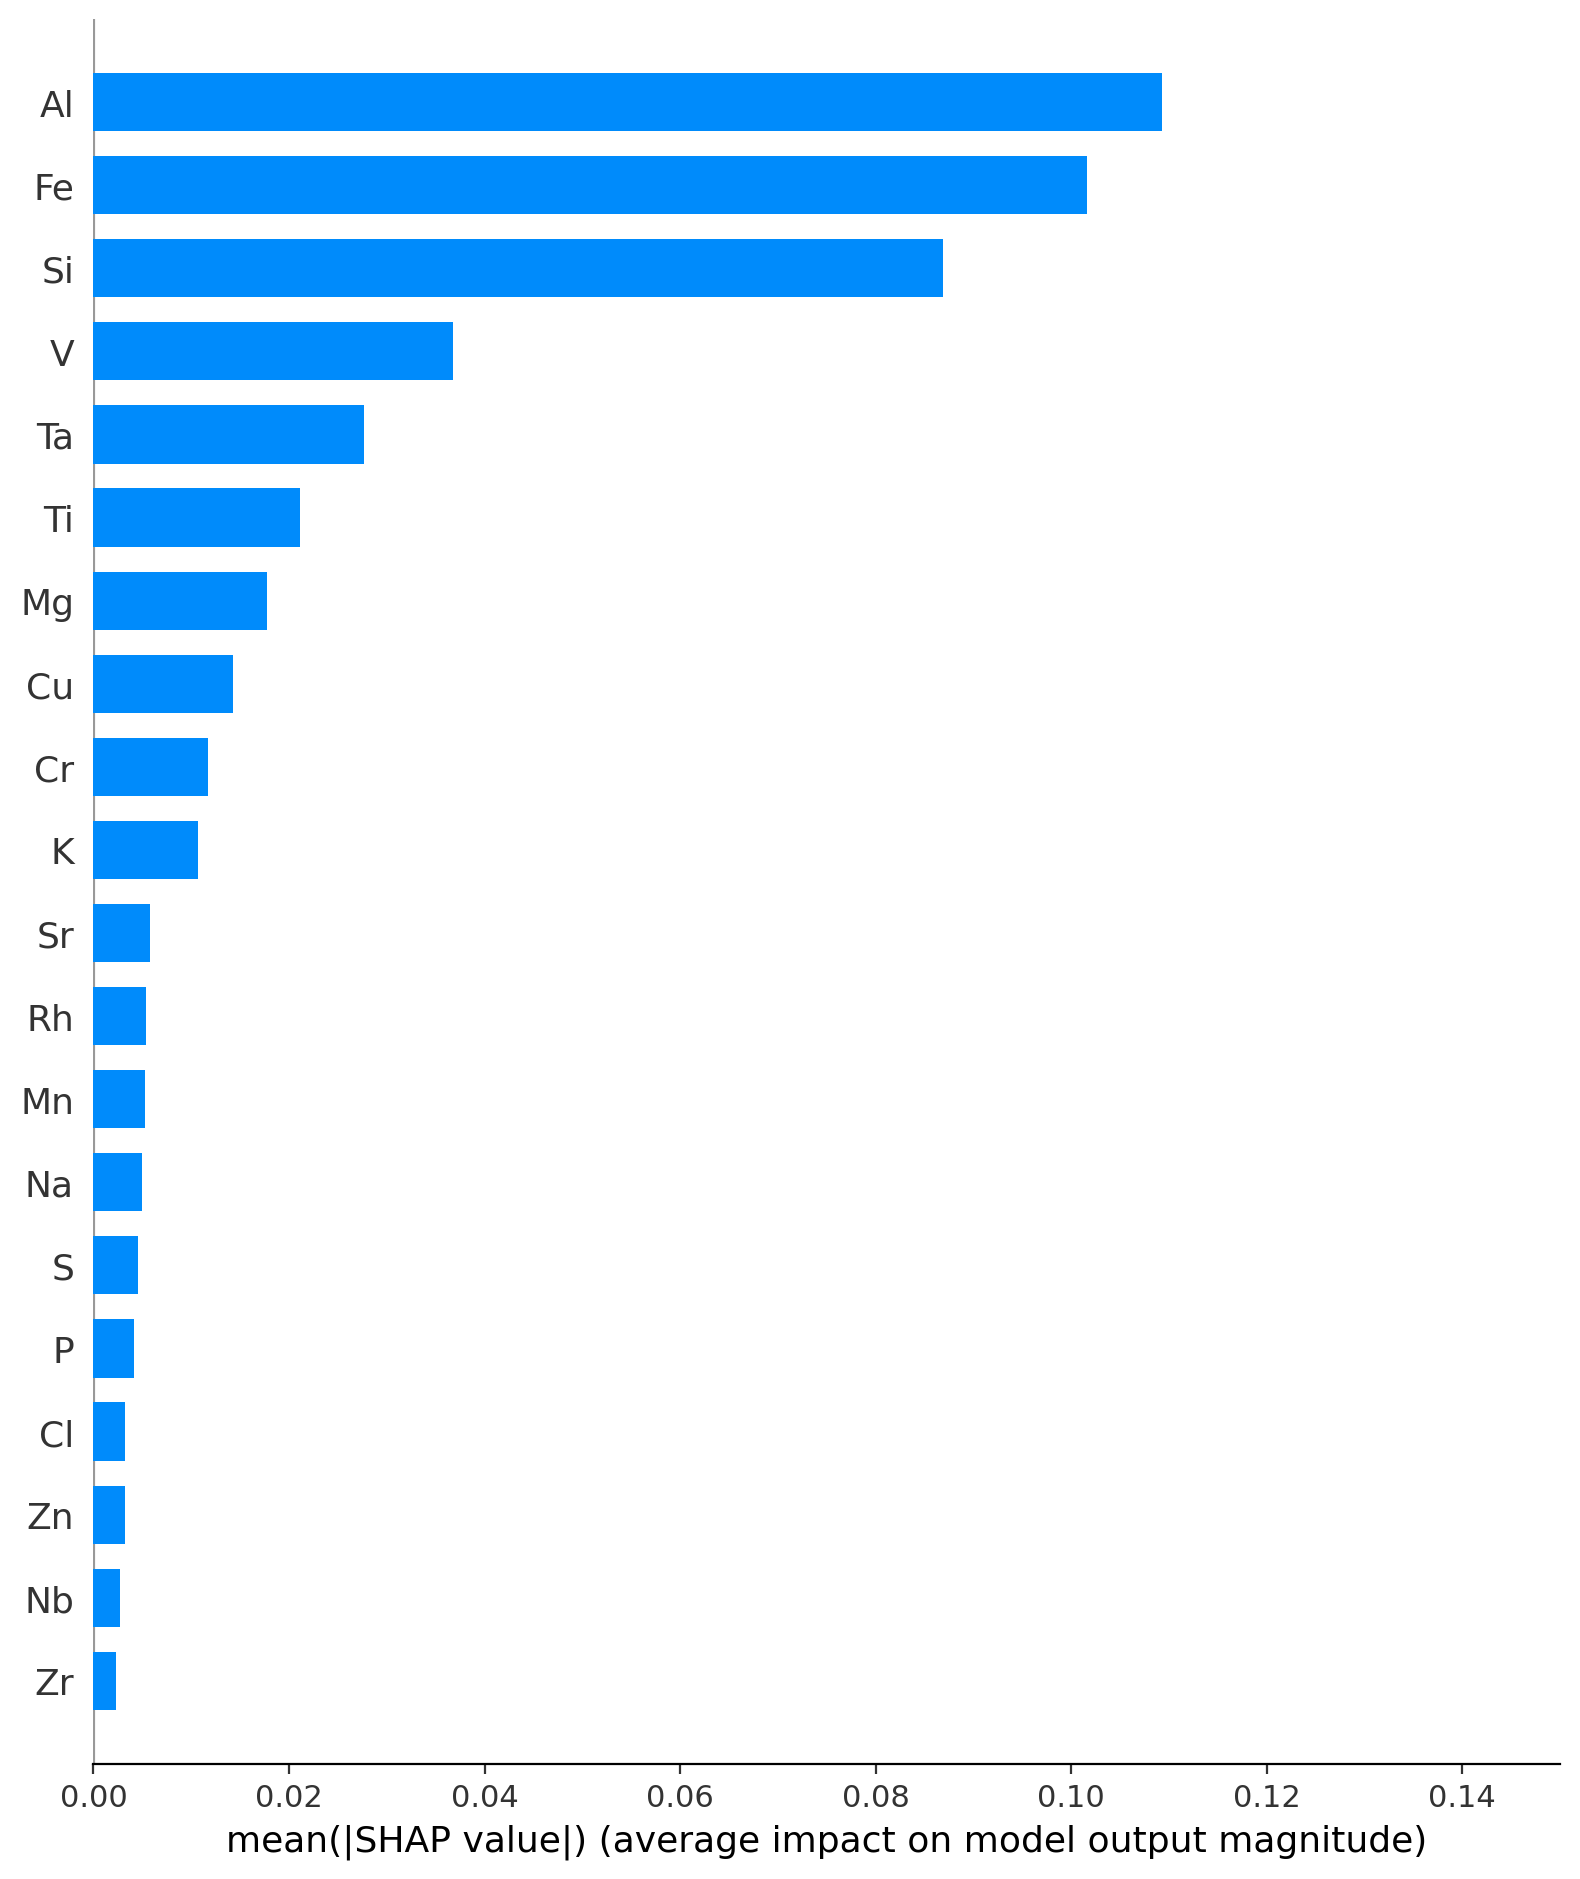

In [ ]:
shap.summary_plot(multi_shap_values[:,:,2], x_test, plot_type="bar",class_names=['Gravelly mudstones', 'Sandy mudstones', 'Clayey mudstones'], show=False)
ax = plt.gca()
ax.set_xlim(0, 0.15)
plt.show()

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], multi_shap_values[:,:,0], x)

In [ ]:
# visualize the first prediction's explaination with default colors
shap.initjs()
shap.force_plot(explainer.expected_value[0], multi_shap_values[:,:,0][0,:], x.iloc[0,:])

In [ ]:
# visualize the first prediction's explaination with default colors
shap.initjs()
shap.force_plot(explainer.expected_value[1], multi_shap_values[:,:,1][0,:], x.iloc[0,:])

In [ ]:
# visualize the first prediction's explaination with default colors
shap.initjs()

shap.force_plot(explainer.expected_value[2], multi_shap_values[:,:,2][0,:], x.iloc[0,:])

# Testing the model in the BC core samples

In [ ]:
# LOADING THE DATASET
my_sheet = 'S2-BC' # change it to your sheet name, you can find your sheet name at the bottom left of your excel file
file_name = 'FRX-sondeo-lagunaCopia de 53572_results-MJ.xlsx' # change it to the name of your excel file
df_bc = read_excel(file_name, sheet_name = my_sheet)

In [ ]:
df_bc.drop(['Unnamed: 0', 'Cm muestreo' ], axis = 'columns', inplace=True)
#drop the elementes
df_bc.drop(['Ba'], axis = 'columns', inplace=True)
df_bc

Na      Mg      Al      Si       P       S      Cl       K      Ca  \
0      NaN  0.0118  0.2008  0.3811  0.0040  0.0015  0.0205  0.0139  0.0644   
1   0.0006  0.0074  0.1197  0.6459  0.0048  0.0014  0.0025  0.0193  0.0130   
2   0.0077  0.0074  0.1523  0.5657  0.0031  0.0013  0.0023  0.0542  0.0100   
3   0.0028  0.0062  0.1151  0.3056  0.0091  0.0007  0.0011  0.0214  0.0050   
4   0.0014  0.0123  0.1978  0.3506  0.0038  0.0008  0.0014  0.0205  0.0138   
5   0.0064  0.0072  0.1490  0.5941  0.0037  0.0013  0.0023  0.0429  0.0115   
6   0.0000  0.0069  0.1362  0.2046  0.0075  0.0007  0.0009  0.0120  0.0037   
7      NaN  0.0071  0.2019  0.2263  0.0059  0.0006  0.0010  0.0090  0.0043   
8      NaN  0.0076  0.1828  0.2091  0.0048  0.0006  0.0009  0.0086  0.0036   
9   0.0000  0.0097  0.1762  0.2035  0.0042  0.0005  0.0009  0.0070  0.0036   
10  0.0000  0.0074  0.1770  0.2158  0.0055  0.0005  0.0010  0.0067  0.0042   
11  0.0098  0.0139  0.1864  0.2821  0.0077  0.0005  0.0010  0.0222  0.0334   
12  0.0137  0.0190  0.1990  0.3247  0.0073  0.0005  0.0014  0.0335  0.0680   
13  0.0067  0.0109  0.1951  0.2651  0.0069  0.0004  0.0011  0.0165  0.0203   
14  0.0144  0.0172  0.2043  0.3232  0.0074  0.0004  0.0013  0.0299  0.0554   

        Sc  ...      Rb      Sr       Y      Zr      Nb  Rh  Hf      Ta  Au  \
0   0.0006  ...     NaN     NaN     NaN     NaN  0.0007 NaN NaN     NaN NaN   
1   0.0000  ...  0.0003  0.0006  0.0000  0.0018  0.0004 NaN NaN     NaN NaN   
2   0.0000  ...  0.0005  0.0012  0.0001  0.0044  0.0008 NaN NaN     NaN NaN   
3   0.0000  ...  0.0003  0.0003  0.0000  0.0024  0.0004 NaN NaN  0.0003 NaN   
4   0.0000  ...  0.0003  0.0007  0.0000  0.0033  0.0006 NaN NaN  0.0003 NaN   
5   0.0000  ...  0.0005  0.0010  0.0000  0.0032  0.0007 NaN NaN     NaN NaN   
6   0.0000  ...  0.0002  0.0002  0.0000  0.0023  0.0004 NaN NaN  0.0003 NaN   
7   0.0000  ...  0.0001  0.0002  0.0000  0.0030  0.0007 NaN NaN  0.0004 NaN   
8   0.0000  ...  0.0001  0.0002  0.0000  0.0029  0.0006 NaN NaN  0.0004 NaN   
9   0.0000  ...  0.0001  0.0001  0.0000  0.0027  0.0006 NaN NaN  0.0004 NaN   
10  0.0000  ...  0.0000  0.0001  0.0000  0.0028  0.0006 NaN NaN  0.0004 NaN   
11  0.0000  ...  0.0001  0.0011  0.0000  0.0018  0.0004 NaN NaN  0.0003 NaN   
12  0.0001  ...  0.0001  0.0023  0.0000  0.0018  0.0004 NaN NaN  0.0002 NaN   
13  0.0000  ...  0.0001  0.0007  0.0000  0.0019  0.0004 NaN NaN  0.0003 NaN   
14  0.0000  ...  0.0000  0.0017  0.0000  0.0019  0.0005 NaN NaN  0.0002 NaN   

     Bi  
0   NaN  
1   NaN  
2   NaN  
3   0.0  
4   0.0  
5   NaN  
6   0.0  
7   0.0  
8   0.0  
9   0.0  
10  0.0  
11  0.0  
12  0.0  
13  0.0  
14  0.0  

[15 rows x 29 columns]

In [ ]:
df_bc.iloc[8:11].plot.bar(rot=0)

<Axes: >

In [ ]:
from sklearn.preprocessing import MinMaxScaler
minmax=MinMaxScaler()
data=pd.DataFrame(minmax.fit_transform(df_bc),columns=df_bc.columns)
x = data.fillna(0)
x.head()

Na        Mg        Al        Si         P         S        Cl  \
0  0.000000  0.437500  0.960762  0.401447  0.150000  1.000000  1.000000   
1  0.041667  0.093750  0.051570  1.000000  0.283333  0.909091  0.081633   
2  0.534722  0.093750  0.417040  0.818716  0.000000  0.818182  0.071429   
3  0.194444  0.000000  0.000000  0.230787  1.000000  0.272727  0.010204   
4  0.097222  0.476562  0.927130  0.332505  0.116667  0.363636  0.025510   

          K        Ca   Sc  ...   Rb        Sr    Y        Zr    Nb   Rh   Hf  \
0  0.151579  0.944099  1.0  ...  0.0  0.000000  0.0  0.000000  0.75  0.0  0.0   
1  0.265263  0.145963  0.0  ...  0.6  0.227273  0.0  0.000000  0.00  0.0  0.0   
2  1.000000  0.099379  0.0  ...  1.0  0.500000  1.0  1.000000  1.00  0.0  0.0   
3  0.309474  0.021739  0.0  ...  0.6  0.090909  0.0  0.230769  0.00  0.0  0.0   
4  0.290526  0.158385  0.0  ...  0.6  0.272727  0.0  0.576923  0.50  0.0  0.0   

    Ta   Au   Bi  
0  0.0  0.0  0.0  
1  0.0  0.0  0.0  
2  0.0  0.0  0.0  
3  0.5  0.0  0.0  
4  0.5  0.0  0.0  

[5 rows x 29 columns]

In [ ]:
x.iloc[13]

Na    0.465278
Mg    0.367188
Al    0.896861
Si    0.139241
P     0.633333
S     0.000000
Cl    0.010204
K     0.206316
Ca    0.259317
Sc    0.000000
Ti    0.532680
V     0.000686
Cr    0.285714
Mn    0.232227
Fe    0.732587
Ni    0.800000
Cu    0.000000
Zn    0.096774
Ga    0.000000
Rb    0.200000
Sr    0.272727
Y     0.000000
Zr    0.038462
Nb    0.000000
Rh    0.000000
Hf    0.000000
Ta    0.500000
Au    0.000000
Bi    0.000000
Name: 13, dtype: float64

In [ ]:
x.iloc[14].plot.bar(subplots=True)

array([<Axes: title={'center': '14'}>], dtype=object)

In [ ]:
#prediction in %
np.round(adb.predict_proba(x),2)*100

array([[25., 33., 41.],
       [26., 39., 35.],
       [26., 39., 35.],
       [39., 36., 26.],
       [26., 39., 35.],
       [26., 39., 35.],
       [39., 36., 26.],
       [26., 39., 35.],
       [39., 31., 31.],
       [39., 31., 31.],
       [39., 31., 31.],
       [26., 39., 35.],
       [25., 33., 41.],
       [26., 39., 35.],
       [26., 39., 35.]])

In [ ]:
#prediction in %
np.round(rfc.predict_proba(x),2)*100

array([[17., 27., 57.],
       [16., 24., 60.],
       [ 9., 32., 59.],
       [44., 34., 23.],
       [13., 42., 44.],
       [ 6., 34., 60.],
       [58., 21., 21.],
       [34., 34., 32.],
       [46., 26., 27.],
       [45., 27., 28.],
       [47., 24., 30.],
       [18., 35., 47.],
       [ 3., 33., 64.],
       [22., 32., 46.],
       [ 6., 42., 52.]])

In [ ]:
rfc.predict(x)

array([3, 3, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3])

In [ ]:
adb.predict(x)

array([3, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 3, 2, 2])

# Testing the model in the LV core samples

In [ ]:
# LOADING THE DATASET
my_sheet = 'S3-LV' # change it to your sheet name, you can find your sheet name at the bottom left of your excel file
file_name = 'FRX-sondeo-lagunaCopia de 53572_results-MJ.xlsx' # change it to the name of your excel file
df_lv = read_excel(file_name, sheet_name = my_sheet)

In [ ]:
df_lv

Unnamed: 0  Cm muestreo      Na      Mg      Al      Si       P  \
0    TEN20-S3-LV-10           10  0.0012  0.0153  0.1961  0.2901  0.0041   
1    TEN20-S3-LV-55           55  0.0000  0.0180  0.1839  0.3555  0.0029   
2   TEN20-S3-LV-110          110  0.0005  0.0155  0.1780  0.3666  0.0025   
3   TEN20-S3-LV-145          145  0.0009  0.0146  0.2232  0.3857  0.0028   
4   TEN20-S3-LV-190          190  0.0005  0.0125  0.2133  0.3302  0.0031   
5   TEN20-S3-LV-240          240  0.0005  0.0136  0.2293  0.3566  0.0029   
6   TEN20-S3-LV-280          280  0.0017  0.0114  0.2314  0.2726  0.0051   
7   TEN20-S3-LV-330          330  0.0031  0.0112  0.2317  0.2833  0.0053   
8   TEN20-S3-LV-350          350  0.0019  0.0115  0.2274  0.2756  0.0057   
9   TEN20-S3-LV-375          375  0.0082  0.0197  0.1972  0.2942  0.0083   
10  TEN20-S3-LV-400          400  0.0053  0.0118  0.1997  0.2677  0.0049   
11  TEN20-S3-LV-430          530  0.0013  0.0116  0.2425  0.3101  0.0050   

         S      Cl       K  ...      Sr       Y      Zr      Nb      Rh  Ba  \
0   0.0006  0.0013  0.0117  ...  0.0012  0.0001  0.0023  0.0005  0.0001 NaN   
1   0.0009  0.0018  0.0112  ...  0.0010  0.0001  0.0023     NaN  0.0001 NaN   
2   0.0007  0.0021  0.0087  ...  0.0009  0.0001  0.0025     NaN     NaN NaN   
3   0.0010  0.0021  0.0075  ...  0.0010  0.0001  0.0028     NaN     NaN NaN   
4   0.0008  0.0017  0.0070  ...  0.0008  0.0002  0.0036  0.0007  0.0001 NaN   
5   0.0010  0.0017  0.0081  ...  0.0010  0.0001  0.0041  0.0008  0.0001 NaN   
6   0.0006  0.0012  0.0068  ...  0.0011  0.0003  0.0041  0.0007     NaN NaN   
7   0.0006  0.0014  0.0103  ...  0.0012  0.0003  0.0048  0.0008     NaN NaN   
8   0.0007  0.0013  0.0087  ...  0.0013  0.0002  0.0043  0.0007     NaN NaN   
9   0.0005  0.0015  0.0153  ...  0.0027  0.0001  0.0023  0.0004  0.0001 NaN   
10  0.0005  0.0011  0.0146  ...  0.0005  0.0000  0.0024  0.0005     NaN NaN   
11  0.0007  0.0015  0.0103  ...  0.0012  0.0001  0.0039  0.0006     NaN NaN   

    Hf      Ta   Au   Bi  
0  NaN  0.0003  NaN  0.0  
1  NaN  0.0002  NaN  0.0  
2  NaN  0.0003  NaN  0.0  
3  NaN  0.0003  NaN  0.0  
4  NaN  0.0004  NaN  0.0  
5  NaN  0.0003  NaN  0.0  
6  NaN  0.0004  NaN  0.0  
7  NaN  0.0004  NaN  0.0  
8  NaN  0.0004  0.0  NaN  
9  NaN  0.0002  NaN  0.0  
10 NaN  0.0003  NaN  0.0  
11 NaN  0.0003  NaN  0.0  

[12 rows x 33 columns]

In [ ]:
df_lv.drop(['Unnamed: 0', 'Cm muestreo' ], axis = 'columns', inplace=True)
#drop the elementes
df_lv.drop(['Ba','Co'], axis = 'columns', inplace=True)
df_lv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Na      12 non-null     float64
 1   Mg      12 non-null     float64
 2   Al      12 non-null     float64
 3   Si      12 non-null     float64
 4   P       12 non-null     float64
 5   S       12 non-null     float64
 6   Cl      12 non-null     float64
 7   K       12 non-null     float64
 8   Ca      12 non-null     float64
 9   Sc      12 non-null     float64
 10  Ti      12 non-null     float64
 11  V       12 non-null     float64
 12  Cr      12 non-null     float64
 13  Mn      12 non-null     float64
 14  Fe      12 non-null     float64
 15  Ni      12 non-null     float64
 16  Cu      7 non-null      float64
 17  Zn      12 non-null     float64
 18  Ga      1 non-null      float64
 19  Rb      12 non-null     float64
 20  Sr      12 non-null     float64
 21  Y       12 non-null     float64
 22  Zr  

In [ ]:
from sklearn.preprocessing import MinMaxScaler
minmax=MinMaxScaler()
data=pd.DataFrame(minmax.fit_transform(df_lv),columns=df_lv.columns)
x = data.fillna(0)
x.head()

Na        Mg        Al        Si         P    S   Cl         K  \
0  0.146341  0.482353  0.280620  0.189831  0.275862  0.2  0.2  0.576471   
1  0.000000  0.800000  0.091473  0.744068  0.068966  0.8  0.7  0.517647   
2  0.060976  0.505882  0.000000  0.838136  0.000000  0.4  1.0  0.223529   
3  0.109756  0.400000  0.700775  1.000000  0.051724  1.0  1.0  0.082353   
4  0.060976  0.152941  0.547287  0.529661  0.103448  0.6  0.6  0.023529   

         Ca   Sc  ...   Rb        Sr         Y    Zr    Nb   Rh   Hf   Ta  \
0  0.082718  0.0  ...  1.0  0.318182  0.333333  0.00  0.25  0.0  0.0  0.5   
1  0.110783  0.0  ...  0.0  0.227273  0.333333  0.00  0.00  0.0  0.0  0.0   
2  0.079764  0.0  ...  0.0  0.181818  0.333333  0.08  0.00  0.0  0.0  0.5   
3  0.097489  0.0  ...  0.0  0.227273  0.333333  0.20  0.00  0.0  0.0  0.5   
4  0.022157  0.0  ...  0.0  0.136364  0.666667  0.52  0.75  0.0  0.0  1.0   

    Au   Bi  
0  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0  
3  0.0  0.0  
4  0.0  0.0  

[5 rows x 29 columns]

In [ ]:
#prediction in %
np.round(adb.predict_proba(x),2)*100

array([[25., 46., 29.],
       [26., 39., 35.],
       [26., 39., 35.],
       [25., 33., 41.],
       [26., 39., 35.],
       [25., 33., 41.],
       [26., 39., 35.],
       [26., 39., 35.],
       [26., 39., 35.],
       [26., 39., 35.],
       [39., 36., 26.],
       [25., 33., 41.]])

In [ ]:
#prediction in %
np.round(rfc.predict_proba(x),2)*100

array([[27., 61., 12.],
       [16., 35., 50.],
       [20., 38., 42.],
       [ 8., 13., 78.],
       [18., 54., 28.],
       [12., 16., 73.],
       [28., 37., 35.],
       [10., 48., 43.],
       [21., 38., 40.],
       [ 3., 46., 52.],
       [47., 31., 22.],
       [ 1., 38., 61.]])

In [ ]:
rfc.predict(x)

array([2, 3, 3, 3, 2, 3, 2, 2, 3, 3, 1, 3])

In [ ]:
adb.predict(x)

array([2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 1, 3])